In [17]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [18]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [19]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

In [20]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('UNH', str):
    # load it from yahoo_fin library
    df = si.get_data('UNH')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


# 是否將特徵資料標準化？

In [21]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,1984-11-13,0.000,0.141,0.137,0.137,0.112,464000,UNH,0.137,0.145,...,33.333,1.301,5.202,-0.002,-0.002,0.148,0.141,0.134,0,1
1,1984-11-14,0.000,0.141,0.133,0.133,0.108,1523200,UNH,0.133,0.145,...,25.000,0.867,3.757,-0.002,-0.002,0.148,0.140,0.133,1,0
2,1984-11-15,0.000,0.137,0.133,0.133,0.108,156800,UNH,0.133,0.141,...,25.000,0.578,2.697,-0.003,-0.002,0.146,0.139,0.132,0,1
3,1984-11-16,0.000,0.137,0.125,0.125,0.102,579200,UNH,0.125,0.141,...,0.000,0.385,1.927,-0.003,-0.002,0.147,0.138,0.129,0,1
4,1984-11-19,0.000,0.137,0.125,0.125,0.102,358400,UNH,0.125,0.141,...,0.000,0.257,1.370,-0.004,-0.003,0.148,0.137,0.127,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,2023-02-24,489.580,492.510,483.010,484.330,484.330,2940400,UNH,483.010,501.400,...,56.362,37.040,53.329,-1.858,-2.951,503.917,487.414,470.911,0,1
9648,2023-02-27,488.770,490.940,481.960,483.320,483.320,3006200,UNH,481.960,501.400,...,50.094,27.025,44.561,-2.196,-2.800,503.868,487.277,470.687,0,1
9649,2023-02-28,482.670,483.360,473.920,475.940,475.940,3902100,UNH,473.920,501.400,...,41.573,20.467,36.530,-3.026,-2.845,504.092,486.785,469.478,1,0
9650,2023-03-01,473.610,478.410,472.000,475.220,475.220,2996900,UNH,472.000,501.400,...,31.080,17.296,30.118,-3.698,-3.016,502.609,485.586,468.564,0,1


# 查找DF的標籤

In [22]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

8855

In [23]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

9610

In [24]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
8855,2020-01-02,293.980,295.700,289.790,292.500,280.186,2543400,UNH,289.790,300.000,...,65.600,44.352,58.611,6.534,7.393,301.613,288.618,275.622,1,0
8856,2020-01-03,287.270,291.880,284.360,289.540,277.351,2711400,UNH,284.360,300.000,...,43.416,40.608,52.610,5.851,7.084,301.406,289.129,276.851,1,0
8857,2020-01-06,288.000,291.660,287.220,291.550,279.276,3079100,UNH,284.360,296.540,...,52.789,46.749,50.656,5.410,6.749,301.473,289.606,277.739,1,0
8858,2020-01-07,290.700,291.490,287.580,289.790,277.590,2492900,UNH,284.360,296.540,...,41.680,46.027,49.113,4.862,6.372,301.140,290.086,279.032,0,1
8859,2020-01-08,291.500,297.380,290.040,295.900,283.443,3379200,UNH,284.360,297.380,...,52.773,60.229,52.818,4.865,6.071,300.704,291.004,281.304,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606,2022-12-23,524.100,531.310,522.900,531.310,531.310,1292300,UNH,515.720,550.990,...,40.055,33.662,31.302,-1.298,-0.036,550.487,534.453,518.419,0,1
9607,2022-12-27,533.930,535.840,529.850,531.990,531.990,1596700,UNH,515.720,543.480,...,35.247,41.978,34.861,-1.065,-0.242,550.481,534.439,518.397,0,1
9608,2022-12-28,535.070,538.150,527.730,528.450,528.450,1694200,UNH,515.720,538.150,...,38.988,46.904,38.875,-1.154,-0.424,550.469,534.461,518.454,0,1
9609,2022-12-29,532.540,533.680,528.860,529.880,529.880,1379700,UNH,515.720,538.150,...,31.666,52.312,43.354,-1.095,-0.558,548.463,533.567,518.672,0,1


In [25]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['RSI']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


----------------------------------
| explained_variance | -0.000787 |
| fps                | 15        |
| nupdates           | 1         |
| policy_entropy     | 0.663     |
| total_timesteps    | 5         |
| value_loss         | 12.3      |
----------------------------------
---------------------------------
| explained_variance | 0.00458  |
| fps                | 368      |
| nupdates           | 100      |
| policy_entropy     | 0.674    |
| total_timesteps    | 500      |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance |

----------------------------------
| explained_variance | -0.000177 |
| fps                | 448       |
| nupdates           | 1500      |
| policy_entropy     | 0.00935   |
| total_timesteps    | 7500      |
| value_loss         | 10        |
----------------------------------
---------------------------------
| explained_variance | 0.00256  |
| fps                | 451      |
| nupdates           | 1600     |
| policy_entropy     | 0.00676  |
| total_timesteps    | 8000     |
| value_loss         | 7.63     |
---------------------------------
---------------------------------
| explained_variance | 0.000187 |
| fps                | 455      |
| nupdates           | 1700     |
| policy_entropy     | 0.007    |
| total_timesteps    | 8500     |
| value_loss         | 25.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00238 |
| fps                | 458      |
| nupdates           | 1800     |
| policy_entropy     | 0.00823  |
| tota

---------------------------------
| explained_variance | -0.00184 |
| fps                | 477      |
| nupdates           | 4500     |
| policy_entropy     | 0.0102   |
| total_timesteps    | 22500    |
| value_loss         | 5.15     |
---------------------------------
---------------------------------
| explained_variance | 0.00471  |
| fps                | 478      |
| nupdates           | 4600     |
| policy_entropy     | 0.0108   |
| total_timesteps    | 23000    |
| value_loss         | 4.44     |
---------------------------------
---------------------------------
| explained_variance | 0.00253  |
| fps                | 478      |
| nupdates           | 4700     |
| policy_entropy     | 0.0197   |
| total_timesteps    | 23500    |
| value_loss         | 263      |
---------------------------------
----------------------------------
| explained_variance | -0.000581 |
| fps                | 479       |
| nupdates           | 4800      |
| policy_entropy     | 0.0129    |
| total_t

---------------------------------
| explained_variance | 0.00449  |
| fps                | 477      |
| nupdates           | 7600     |
| policy_entropy     | 0.0294   |
| total_timesteps    | 38000    |
| value_loss         | 97.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00551 |
| fps                | 477      |
| nupdates           | 7700     |
| policy_entropy     | 0.017    |
| total_timesteps    | 38500    |
| value_loss         | 7.85     |
---------------------------------
---------------------------------
| explained_variance | -0.0192  |
| fps                | 478      |
| nupdates           | 7800     |
| policy_entropy     | 0.0124   |
| total_timesteps    | 39000    |
| value_loss         | 2.5      |
---------------------------------
---------------------------------
| explained_variance | 0.000563 |
| fps                | 478      |
| nupdates           | 7900     |
| policy_entropy     | 0.0126   |
| total_timest

---------------------------------
| explained_variance | 0.00774  |
| fps                | 474      |
| nupdates           | 10700    |
| policy_entropy     | 0.00292  |
| total_timesteps    | 53500    |
| value_loss         | 36.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000552 |
| fps                | 474       |
| nupdates           | 10800     |
| policy_entropy     | 0.003     |
| total_timesteps    | 54000     |
| value_loss         | 48        |
----------------------------------
---------------------------------
| explained_variance | 0.0439   |
| fps                | 474      |
| nupdates           | 10900    |
| policy_entropy     | 0.00618  |
| total_timesteps    | 54500    |
| value_loss         | 124      |
---------------------------------
---------------------------------
| explained_variance | 0.0046   |
| fps                | 473      |
| nupdates           | 11000    |
| policy_entropy     | 0.00296  |
| tota

---------------------------------
| explained_variance | -0.612   |
| fps                | 448      |
| nupdates           | 13800    |
| policy_entropy     | 0.00241  |
| total_timesteps    | 69000    |
| value_loss         | 1.24     |
---------------------------------
---------------------------------
| explained_variance | 0.0143   |
| fps                | 448      |
| nupdates           | 13900    |
| policy_entropy     | 0.00285  |
| total_timesteps    | 69500    |
| value_loss         | 296      |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 448      |
| nupdates           | 14000    |
| policy_entropy     | 0.00214  |
| total_timesteps    | 70000    |
| value_loss         | 1.43     |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 449      |
| nupdates           | 14100    |
| policy_entropy     | 0.00196  |
| total_timest

---------------------------------
| explained_variance | 0.0414   |
| fps                | 454      |
| nupdates           | 16900    |
| policy_entropy     | 0.00172  |
| total_timesteps    | 84500    |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | 0.238    |
| fps                | 454      |
| nupdates           | 17000    |
| policy_entropy     | 0.00172  |
| total_timesteps    | 85000    |
| value_loss         | 1.91     |
---------------------------------
---------------------------------
| explained_variance | -0.0529  |
| fps                | 454      |
| nupdates           | 17100    |
| policy_entropy     | 0.0018   |
| total_timesteps    | 85500    |
| value_loss         | 73       |
---------------------------------
---------------------------------
| explained_variance | 0.335    |
| fps                | 454      |
| nupdates           | 17200    |
| policy_entropy     | 0.00159  |
| total_timest

---------------------------------
| explained_variance | -0.00128 |
| fps                | 455      |
| nupdates           | 20000    |
| policy_entropy     | 0.00257  |
| total_timesteps    | 100000   |
| value_loss         | 82.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0733   |
| fps                | 455      |
| nupdates           | 20100    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 100500   |
| value_loss         | 33       |
---------------------------------
---------------------------------
| explained_variance | 0.0687   |
| fps                | 455      |
| nupdates           | 20200    |
| policy_entropy     | 0.00315  |
| total_timesteps    | 101000   |
| value_loss         | 283      |
---------------------------------
---------------------------------
| explained_variance | 0.262    |
| fps                | 455      |
| nupdates           | 20300    |
| policy_entropy     | 0.00488  |
| total_timest

---------------------------------
| explained_variance | -0.0239  |
| fps                | 444      |
| nupdates           | 23100    |
| policy_entropy     | 0.00783  |
| total_timesteps    | 115500   |
| value_loss         | 5.53     |
---------------------------------
---------------------------------
| explained_variance | -0.236   |
| fps                | 444      |
| nupdates           | 23200    |
| policy_entropy     | 0.0141   |
| total_timesteps    | 116000   |
| value_loss         | 4.62     |
---------------------------------
---------------------------------
| explained_variance | 0.0739   |
| fps                | 444      |
| nupdates           | 23300    |
| policy_entropy     | 0.019    |
| total_timesteps    | 116500   |
| value_loss         | 21.5     |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 444      |
| nupdates           | 23400    |
| policy_entropy     | 0.0171   |
| total_timest

---------------------------------
| explained_variance | -0.0482  |
| fps                | 440      |
| nupdates           | 26200    |
| policy_entropy     | 0.00463  |
| total_timesteps    | 131000   |
| value_loss         | 77.7     |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 440      |
| nupdates           | 26300    |
| policy_entropy     | 0.0125   |
| total_timesteps    | 131500   |
| value_loss         | 35.6     |
---------------------------------
---------------------------------
| explained_variance | 0.541    |
| fps                | 440      |
| nupdates           | 26400    |
| policy_entropy     | 0.00987  |
| total_timesteps    | 132000   |
| value_loss         | 2.99     |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 440      |
| nupdates           | 26500    |
| policy_entropy     | 0.015    |
| total_timest

---------------------------------
| explained_variance | 0.135    |
| fps                | 439      |
| nupdates           | 29300    |
| policy_entropy     | 0.00474  |
| total_timesteps    | 146500   |
| value_loss         | 294      |
---------------------------------
---------------------------------
| explained_variance | -1.22    |
| fps                | 440      |
| nupdates           | 29400    |
| policy_entropy     | 0.00895  |
| total_timesteps    | 147000   |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | -0.459   |
| fps                | 440      |
| nupdates           | 29500    |
| policy_entropy     | 0.025    |
| total_timesteps    | 147500   |
| value_loss         | 78.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0413   |
| fps                | 440      |
| nupdates           | 29600    |
| policy_entropy     | 0.00882  |
| total_timest

---------------------------------
| explained_variance | 0.158    |
| fps                | 441      |
| nupdates           | 32400    |
| policy_entropy     | 0.00211  |
| total_timesteps    | 162000   |
| value_loss         | 952      |
---------------------------------
---------------------------------
| explained_variance | -0.113   |
| fps                | 441      |
| nupdates           | 32500    |
| policy_entropy     | 0.00451  |
| total_timesteps    | 162500   |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | 0.595    |
| fps                | 441      |
| nupdates           | 32600    |
| policy_entropy     | 0.00402  |
| total_timesteps    | 163000   |
| value_loss         | 0.812    |
---------------------------------
---------------------------------
| explained_variance | -1.22    |
| fps                | 442      |
| nupdates           | 32700    |
| policy_entropy     | 0.00234  |
| total_timest

---------------------------------
| explained_variance | 0.28     |
| fps                | 440      |
| nupdates           | 35500    |
| policy_entropy     | 0.00235  |
| total_timesteps    | 177500   |
| value_loss         | 8.46     |
---------------------------------
---------------------------------
| explained_variance | 0.0464   |
| fps                | 440      |
| nupdates           | 35600    |
| policy_entropy     | 0.00278  |
| total_timesteps    | 178000   |
| value_loss         | 1.1      |
---------------------------------
---------------------------------
| explained_variance | -0.259   |
| fps                | 440      |
| nupdates           | 35700    |
| policy_entropy     | 0.00386  |
| total_timesteps    | 178500   |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.241    |
| fps                | 440      |
| nupdates           | 35800    |
| policy_entropy     | 0.00125  |
| total_timest

---------------------------------
| explained_variance | 0.0618   |
| fps                | 441      |
| nupdates           | 38600    |
| policy_entropy     | 0.0109   |
| total_timesteps    | 193000   |
| value_loss         | 87       |
---------------------------------
---------------------------------
| explained_variance | -0.558   |
| fps                | 441      |
| nupdates           | 38700    |
| policy_entropy     | 0.00556  |
| total_timesteps    | 193500   |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | -0.236   |
| fps                | 441      |
| nupdates           | 38800    |
| policy_entropy     | 0.00362  |
| total_timesteps    | 194000   |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 440      |
| nupdates           | 38900    |
| policy_entropy     | 0.00413  |
| total_timest

---------------------------------
| explained_variance | 0.015    |
| fps                | 442      |
| nupdates           | 41700    |
| policy_entropy     | 0.0085   |
| total_timesteps    | 208500   |
| value_loss         | 56.5     |
---------------------------------
---------------------------------
| explained_variance | 0.633    |
| fps                | 442      |
| nupdates           | 41800    |
| policy_entropy     | 0.00402  |
| total_timesteps    | 209000   |
| value_loss         | 4.79     |
---------------------------------
---------------------------------
| explained_variance | -0.0621  |
| fps                | 442      |
| nupdates           | 41900    |
| policy_entropy     | 0.00482  |
| total_timesteps    | 209500   |
| value_loss         | 45.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0507   |
| fps                | 442      |
| nupdates           | 42000    |
| policy_entropy     | 0.00192  |
| total_timest

---------------------------------
| explained_variance | -0.181   |
| fps                | 444      |
| nupdates           | 44800    |
| policy_entropy     | 0.00578  |
| total_timesteps    | 224000   |
| value_loss         | 5.2      |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 445      |
| nupdates           | 44900    |
| policy_entropy     | 0.00264  |
| total_timesteps    | 224500   |
| value_loss         | 24.1     |
---------------------------------
---------------------------------
| explained_variance | 0.396    |
| fps                | 445      |
| nupdates           | 45000    |
| policy_entropy     | 0.000709 |
| total_timesteps    | 225000   |
| value_loss         | 0.928    |
---------------------------------
---------------------------------
| explained_variance | -0.00337 |
| fps                | 445      |
| nupdates           | 45100    |
| policy_entropy     | 0.000509 |
| total_timest

---------------------------------
| explained_variance | -0.138   |
| fps                | 442      |
| nupdates           | 47900    |
| policy_entropy     | 0.00101  |
| total_timesteps    | 239500   |
| value_loss         | 8.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0496   |
| fps                | 442      |
| nupdates           | 48000    |
| policy_entropy     | 0.000804 |
| total_timesteps    | 240000   |
| value_loss         | 0.661    |
---------------------------------
---------------------------------
| explained_variance | -0.0552  |
| fps                | 442      |
| nupdates           | 48100    |
| policy_entropy     | 0.001    |
| total_timesteps    | 240500   |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 442      |
| nupdates           | 48200    |
| policy_entropy     | 0.00292  |
| total_timest

---------------------------------
| explained_variance | 0.541    |
| fps                | 441      |
| nupdates           | 51000    |
| policy_entropy     | 0.00077  |
| total_timesteps    | 255000   |
| value_loss         | 8.33     |
---------------------------------
---------------------------------
| explained_variance | -0.017   |
| fps                | 441      |
| nupdates           | 51100    |
| policy_entropy     | 0.000607 |
| total_timesteps    | 255500   |
| value_loss         | 38       |
---------------------------------
---------------------------------
| explained_variance | -0.175   |
| fps                | 441      |
| nupdates           | 51200    |
| policy_entropy     | 0.000393 |
| total_timesteps    | 256000   |
| value_loss         | 4.28     |
---------------------------------
---------------------------------
| explained_variance | 0.0682   |
| fps                | 441      |
| nupdates           | 51300    |
| policy_entropy     | 0.000665 |
| total_timest

---------------------------------
| explained_variance | 0.0862   |
| fps                | 438      |
| nupdates           | 54100    |
| policy_entropy     | 0.000825 |
| total_timesteps    | 270500   |
| value_loss         | 76.2     |
---------------------------------
---------------------------------
| explained_variance | -0.874   |
| fps                | 438      |
| nupdates           | 54200    |
| policy_entropy     | 0.000535 |
| total_timesteps    | 271000   |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | 0.497    |
| fps                | 438      |
| nupdates           | 54300    |
| policy_entropy     | 0.00129  |
| total_timesteps    | 271500   |
| value_loss         | 32.8     |
---------------------------------
---------------------------------
| explained_variance | 0.289    |
| fps                | 439      |
| nupdates           | 54400    |
| policy_entropy     | 0.00318  |
| total_timest

---------------------------------
| explained_variance | 0.767    |
| fps                | 439      |
| nupdates           | 57200    |
| policy_entropy     | 0.0011   |
| total_timesteps    | 286000   |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 0.32     |
| fps                | 439      |
| nupdates           | 57300    |
| policy_entropy     | 0.00181  |
| total_timesteps    | 286500   |
| value_loss         | 5.73     |
---------------------------------
---------------------------------
| explained_variance | 0.0712   |
| fps                | 439      |
| nupdates           | 57400    |
| policy_entropy     | 0.00066  |
| total_timesteps    | 287000   |
| value_loss         | 4.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0963   |
| fps                | 439      |
| nupdates           | 57500    |
| policy_entropy     | 0.0023   |
| total_timest

---------------------------------
| explained_variance | -0.15    |
| fps                | 438      |
| nupdates           | 60300    |
| policy_entropy     | 0.00148  |
| total_timesteps    | 301500   |
| value_loss         | 3.17     |
---------------------------------
---------------------------------
| explained_variance | 0.467    |
| fps                | 438      |
| nupdates           | 60400    |
| policy_entropy     | 0.00059  |
| total_timesteps    | 302000   |
| value_loss         | 9.79     |
---------------------------------
---------------------------------
| explained_variance | -0.946   |
| fps                | 438      |
| nupdates           | 60500    |
| policy_entropy     | 0.00448  |
| total_timesteps    | 302500   |
| value_loss         | 79.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0451  |
| fps                | 438      |
| nupdates           | 60600    |
| policy_entropy     | 0.00131  |
| total_timest

---------------------------------
| explained_variance | 0.669    |
| fps                | 438      |
| nupdates           | 63400    |
| policy_entropy     | 0.281    |
| total_timesteps    | 317000   |
| value_loss         | 8.94     |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 438      |
| nupdates           | 63500    |
| policy_entropy     | 0.627    |
| total_timesteps    | 317500   |
| value_loss         | 55.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0455  |
| fps                | 438      |
| nupdates           | 63600    |
| policy_entropy     | 0.00323  |
| total_timesteps    | 318000   |
| value_loss         | 35.9     |
---------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 438      |
| nupdates           | 63700    |
| policy_entropy     | 0.264    |
| total_timest

---------------------------------
| explained_variance | 0.316    |
| fps                | 435      |
| nupdates           | 66500    |
| policy_entropy     | 0.000699 |
| total_timesteps    | 332500   |
| value_loss         | 211      |
---------------------------------
---------------------------------
| explained_variance | -0.222   |
| fps                | 435      |
| nupdates           | 66600    |
| policy_entropy     | 0.000844 |
| total_timesteps    | 333000   |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 435      |
| nupdates           | 66700    |
| policy_entropy     | 0.000775 |
| total_timesteps    | 333500   |
| value_loss         | 2.38     |
---------------------------------
---------------------------------
| explained_variance | -0.0308  |
| fps                | 435      |
| nupdates           | 66800    |
| policy_entropy     | 0.000728 |
| total_timest

---------------------------------
| explained_variance | -0.43    |
| fps                | 432      |
| nupdates           | 69600    |
| policy_entropy     | 0.000896 |
| total_timesteps    | 348000   |
| value_loss         | 3.38     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 432      |
| nupdates           | 69700    |
| policy_entropy     | 0.000936 |
| total_timesteps    | 348500   |
| value_loss         | 16.5     |
---------------------------------
---------------------------------
| explained_variance | 0.273    |
| fps                | 432      |
| nupdates           | 69800    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 349000   |
| value_loss         | 18.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0262   |
| fps                | 432      |
| nupdates           | 69900    |
| policy_entropy     | 0.00903  |
| total_timest

---------------------------------
| explained_variance | -0.0123  |
| fps                | 433      |
| nupdates           | 72700    |
| policy_entropy     | 0.000456 |
| total_timesteps    | 363500   |
| value_loss         | 146      |
---------------------------------
---------------------------------
| explained_variance | 0.0927   |
| fps                | 433      |
| nupdates           | 72800    |
| policy_entropy     | 0.00141  |
| total_timesteps    | 364000   |
| value_loss         | 1.97     |
---------------------------------
---------------------------------
| explained_variance | -0.498   |
| fps                | 433      |
| nupdates           | 72900    |
| policy_entropy     | 0.000522 |
| total_timesteps    | 364500   |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0889   |
| fps                | 433      |
| nupdates           | 73000    |
| policy_entropy     | 0.000698 |
| total_timest

---------------------------------
| explained_variance | 0.263    |
| fps                | 433      |
| nupdates           | 75800    |
| policy_entropy     | 0.000581 |
| total_timesteps    | 379000   |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | -0.952   |
| fps                | 433      |
| nupdates           | 75900    |
| policy_entropy     | 0.000684 |
| total_timesteps    | 379500   |
| value_loss         | 141      |
---------------------------------
---------------------------------
| explained_variance | 0.596    |
| fps                | 433      |
| nupdates           | 76000    |
| policy_entropy     | 0.00142  |
| total_timesteps    | 380000   |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 0.319    |
| fps                | 433      |
| nupdates           | 76100    |
| policy_entropy     | 0.0081   |
| total_timest

---------------------------------
| explained_variance | 0.214    |
| fps                | 433      |
| nupdates           | 78900    |
| policy_entropy     | 0.000508 |
| total_timesteps    | 394500   |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.231    |
| fps                | 433      |
| nupdates           | 79000    |
| policy_entropy     | 0.000474 |
| total_timesteps    | 395000   |
| value_loss         | 2.75     |
---------------------------------
---------------------------------
| explained_variance | 0.402    |
| fps                | 433      |
| nupdates           | 79100    |
| policy_entropy     | 0.000805 |
| total_timesteps    | 395500   |
| value_loss         | 34.9     |
---------------------------------
---------------------------------
| explained_variance | -0.312   |
| fps                | 433      |
| nupdates           | 79200    |
| policy_entropy     | 0.000426 |
| total_timest

---------------------------------
| explained_variance | 0.525    |
| fps                | 434      |
| nupdates           | 82000    |
| policy_entropy     | 0.00256  |
| total_timesteps    | 410000   |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | -0.055   |
| fps                | 434      |
| nupdates           | 82100    |
| policy_entropy     | 0.00596  |
| total_timesteps    | 410500   |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0297  |
| fps                | 434      |
| nupdates           | 82200    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 411000   |
| value_loss         | 2.38     |
---------------------------------
---------------------------------
| explained_variance | 0.492    |
| fps                | 434      |
| nupdates           | 82300    |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0.606    |
| fps                | 434      |
| nupdates           | 85100    |
| policy_entropy     | 0.0163   |
| total_timesteps    | 425500   |
| value_loss         | 3.2      |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 434      |
| nupdates           | 85200    |
| policy_entropy     | 0.00159  |
| total_timesteps    | 426000   |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | -0.143   |
| fps                | 434      |
| nupdates           | 85300    |
| policy_entropy     | 0.00106  |
| total_timesteps    | 426500   |
| value_loss         | 30.9     |
---------------------------------
---------------------------------
| explained_variance | 0.2      |
| fps                | 434      |
| nupdates           | 85400    |
| policy_entropy     | 0.000795 |
| total_timest

---------------------------------
| explained_variance | 0.685    |
| fps                | 433      |
| nupdates           | 88200    |
| policy_entropy     | 0.0456   |
| total_timesteps    | 441000   |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | 0.382    |
| fps                | 433      |
| nupdates           | 88300    |
| policy_entropy     | 0.0196   |
| total_timesteps    | 441500   |
| value_loss         | 5.13     |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 433      |
| nupdates           | 88400    |
| policy_entropy     | 0.00253  |
| total_timesteps    | 442000   |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0852  |
| fps                | 433      |
| nupdates           | 88500    |
| policy_entropy     | 0.00224  |
| total_timest

---------------------------------
| explained_variance | -0.151   |
| fps                | 433      |
| nupdates           | 91300    |
| policy_entropy     | 0.0095   |
| total_timesteps    | 456500   |
| value_loss         | 87.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0829  |
| fps                | 432      |
| nupdates           | 91400    |
| policy_entropy     | 0.0113   |
| total_timesteps    | 457000   |
| value_loss         | 2.13     |
---------------------------------
---------------------------------
| explained_variance | -3.35    |
| fps                | 432      |
| nupdates           | 91500    |
| policy_entropy     | 0.00441  |
| total_timesteps    | 457500   |
| value_loss         | 15.2     |
---------------------------------
---------------------------------
| explained_variance | -0.062   |
| fps                | 432      |
| nupdates           | 91600    |
| policy_entropy     | 0.00491  |
| total_timest

---------------------------------
| explained_variance | -0.312   |
| fps                | 431      |
| nupdates           | 94400    |
| policy_entropy     | 0.00204  |
| total_timesteps    | 472000   |
| value_loss         | 79.7     |
---------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 431      |
| nupdates           | 94500    |
| policy_entropy     | 0.00229  |
| total_timesteps    | 472500   |
| value_loss         | 319      |
---------------------------------
---------------------------------
| explained_variance | -0.309   |
| fps                | 430      |
| nupdates           | 94600    |
| policy_entropy     | 0.00112  |
| total_timesteps    | 473000   |
| value_loss         | 20.4     |
---------------------------------
---------------------------------
| explained_variance | 0.311    |
| fps                | 430      |
| nupdates           | 94700    |
| policy_entropy     | 0.00123  |
| total_timest

---------------------------------
| explained_variance | 0.194    |
| fps                | 429      |
| nupdates           | 97500    |
| policy_entropy     | 0.00101  |
| total_timesteps    | 487500   |
| value_loss         | 145      |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 429      |
| nupdates           | 97600    |
| policy_entropy     | 0.00107  |
| total_timesteps    | 488000   |
| value_loss         | 0.262    |
---------------------------------
---------------------------------
| explained_variance | 0.0497   |
| fps                | 429      |
| nupdates           | 97700    |
| policy_entropy     | 0.00182  |
| total_timesteps    | 488500   |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | 0.407    |
| fps                | 429      |
| nupdates           | 97800    |
| policy_entropy     | 0.00216  |
| total_timest

---------------------------------
| explained_variance | 0.298    |
| fps                | 430      |
| nupdates           | 100600   |
| policy_entropy     | 0.00042  |
| total_timesteps    | 503000   |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0118  |
| fps                | 430      |
| nupdates           | 100700   |
| policy_entropy     | 0.00127  |
| total_timesteps    | 503500   |
| value_loss         | 122      |
---------------------------------
---------------------------------
| explained_variance | -0.154   |
| fps                | 430      |
| nupdates           | 100800   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 504000   |
| value_loss         | 32.2     |
---------------------------------
---------------------------------
| explained_variance | 0.414    |
| fps                | 430      |
| nupdates           | 100900   |
| policy_entropy     | 0.000569 |
| total_timest

---------------------------------
| explained_variance | 0.0161   |
| fps                | 430      |
| nupdates           | 103700   |
| policy_entropy     | 0.000484 |
| total_timesteps    | 518500   |
| value_loss         | 253      |
---------------------------------
---------------------------------
| explained_variance | -1.32    |
| fps                | 430      |
| nupdates           | 103800   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 519000   |
| value_loss         | 4.01     |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 430      |
| nupdates           | 103900   |
| policy_entropy     | 0.000444 |
| total_timesteps    | 519500   |
| value_loss         | 4.4      |
---------------------------------
---------------------------------
| explained_variance | 0.723    |
| fps                | 430      |
| nupdates           | 104000   |
| policy_entropy     | 0.000559 |
| total_timest

---------------------------------
| explained_variance | -0.62    |
| fps                | 431      |
| nupdates           | 106800   |
| policy_entropy     | 0.000306 |
| total_timesteps    | 534000   |
| value_loss         | 9.76     |
---------------------------------
---------------------------------
| explained_variance | -0.387   |
| fps                | 431      |
| nupdates           | 106900   |
| policy_entropy     | 0.000361 |
| total_timesteps    | 534500   |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | -0.347   |
| fps                | 431      |
| nupdates           | 107000   |
| policy_entropy     | 0.000393 |
| total_timesteps    | 535000   |
| value_loss         | 62.6     |
---------------------------------
---------------------------------
| explained_variance | 0.334    |
| fps                | 431      |
| nupdates           | 107100   |
| policy_entropy     | 0.00116  |
| total_timest

---------------------------------
| explained_variance | 0.0163   |
| fps                | 426      |
| nupdates           | 109900   |
| policy_entropy     | 0.000328 |
| total_timesteps    | 549500   |
| value_loss         | 54.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0913   |
| fps                | 425      |
| nupdates           | 110000   |
| policy_entropy     | 0.000298 |
| total_timesteps    | 550000   |
| value_loss         | 6.38     |
---------------------------------
---------------------------------
| explained_variance | -0.316   |
| fps                | 425      |
| nupdates           | 110100   |
| policy_entropy     | 0.000433 |
| total_timesteps    | 550500   |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00328 |
| fps                | 425      |
| nupdates           | 110200   |
| policy_entropy     | 0.000346 |
| total_timest

---------------------------------
| explained_variance | 0.602    |
| fps                | 418      |
| nupdates           | 113000   |
| policy_entropy     | 0.00044  |
| total_timesteps    | 565000   |
| value_loss         | 0.868    |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 418      |
| nupdates           | 113100   |
| policy_entropy     | 0.000619 |
| total_timesteps    | 565500   |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0018   |
| fps                | 417      |
| nupdates           | 113200   |
| policy_entropy     | 0.00253  |
| total_timesteps    | 566000   |
| value_loss         | 39.7     |
---------------------------------
---------------------------------
| explained_variance | -0.192   |
| fps                | 417      |
| nupdates           | 113300   |
| policy_entropy     | 0.000809 |
| total_timest

---------------------------------
| explained_variance | 0.229    |
| fps                | 414      |
| nupdates           | 116100   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 580500   |
| value_loss         | 22.7     |
---------------------------------
---------------------------------
| explained_variance | -0.281   |
| fps                | 414      |
| nupdates           | 116200   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 581000   |
| value_loss         | 35.3     |
---------------------------------
---------------------------------
| explained_variance | -0.148   |
| fps                | 414      |
| nupdates           | 116300   |
| policy_entropy     | 0.000799 |
| total_timesteps    | 581500   |
| value_loss         | 40.4     |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 413      |
| nupdates           | 116400   |
| policy_entropy     | 0.000371 |
| total_timest

---------------------------------
| explained_variance | 0.119    |
| fps                | 412      |
| nupdates           | 119200   |
| policy_entropy     | 0.000983 |
| total_timesteps    | 596000   |
| value_loss         | 7.31     |
---------------------------------
---------------------------------
| explained_variance | -3.23    |
| fps                | 412      |
| nupdates           | 119300   |
| policy_entropy     | 0.000559 |
| total_timesteps    | 596500   |
| value_loss         | 27.6     |
---------------------------------
---------------------------------
| explained_variance | 0.39     |
| fps                | 412      |
| nupdates           | 119400   |
| policy_entropy     | 0.000759 |
| total_timesteps    | 597000   |
| value_loss         | 5.55     |
---------------------------------
---------------------------------
| explained_variance | 0.233    |
| fps                | 412      |
| nupdates           | 119500   |
| policy_entropy     | 0.000419 |
| total_timest

---------------------------------
| explained_variance | 0.0986   |
| fps                | 411      |
| nupdates           | 122300   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 611500   |
| value_loss         | 1.75     |
---------------------------------
---------------------------------
| explained_variance | 0.772    |
| fps                | 411      |
| nupdates           | 122400   |
| policy_entropy     | 0.0018   |
| total_timesteps    | 612000   |
| value_loss         | 2.23     |
---------------------------------
---------------------------------
| explained_variance | -2.02    |
| fps                | 410      |
| nupdates           | 122500   |
| policy_entropy     | 0.000803 |
| total_timesteps    | 612500   |
| value_loss         | 9.14     |
---------------------------------
---------------------------------
| explained_variance | 0.00272  |
| fps                | 410      |
| nupdates           | 122600   |
| policy_entropy     | 0.000838 |
| total_timest

---------------------------------
| explained_variance | 0.808    |
| fps                | 409      |
| nupdates           | 125400   |
| policy_entropy     | 0.00364  |
| total_timesteps    | 627000   |
| value_loss         | 1.66     |
---------------------------------
---------------------------------
| explained_variance | 0.0893   |
| fps                | 409      |
| nupdates           | 125500   |
| policy_entropy     | 0.000649 |
| total_timesteps    | 627500   |
| value_loss         | 24.6     |
---------------------------------
---------------------------------
| explained_variance | -0.289   |
| fps                | 409      |
| nupdates           | 125600   |
| policy_entropy     | 0.00082  |
| total_timesteps    | 628000   |
| value_loss         | 82.6     |
---------------------------------
---------------------------------
| explained_variance | -0.34    |
| fps                | 409      |
| nupdates           | 125700   |
| policy_entropy     | 0.00103  |
| total_timest

---------------------------------
| explained_variance | 0.52     |
| fps                | 407      |
| nupdates           | 128500   |
| policy_entropy     | 0.000485 |
| total_timesteps    | 642500   |
| value_loss         | 29.3     |
---------------------------------
---------------------------------
| explained_variance | -1.05    |
| fps                | 407      |
| nupdates           | 128600   |
| policy_entropy     | 0.000502 |
| total_timesteps    | 643000   |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | -0.381   |
| fps                | 407      |
| nupdates           | 128700   |
| policy_entropy     | 0.000441 |
| total_timesteps    | 643500   |
| value_loss         | 3.15     |
---------------------------------
---------------------------------
| explained_variance | -0.13    |
| fps                | 407      |
| nupdates           | 128800   |
| policy_entropy     | 0.000556 |
| total_timest

---------------------------------
| explained_variance | 0.554    |
| fps                | 404      |
| nupdates           | 131600   |
| policy_entropy     | 0.00204  |
| total_timesteps    | 658000   |
| value_loss         | 8.64     |
---------------------------------
---------------------------------
| explained_variance | 0.468    |
| fps                | 404      |
| nupdates           | 131700   |
| policy_entropy     | 0.000665 |
| total_timesteps    | 658500   |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | -0.205   |
| fps                | 404      |
| nupdates           | 131800   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 659000   |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 0.571    |
| fps                | 404      |
| nupdates           | 131900   |
| policy_entropy     | 0.000652 |
| total_timest

---------------------------------
| explained_variance | -1.49    |
| fps                | 401      |
| nupdates           | 134700   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 673500   |
| value_loss         | 8.17     |
---------------------------------
---------------------------------
| explained_variance | -9.76    |
| fps                | 401      |
| nupdates           | 134800   |
| policy_entropy     | 0.000478 |
| total_timesteps    | 674000   |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | 0.281    |
| fps                | 401      |
| nupdates           | 134900   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 674500   |
| value_loss         | 22.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0124  |
| fps                | 401      |
| nupdates           | 135000   |
| policy_entropy     | 0.000497 |
| total_timest

---------------------------------
| explained_variance | -1.41    |
| fps                | 398      |
| nupdates           | 137800   |
| policy_entropy     | 0.000427 |
| total_timesteps    | 689000   |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | 0.783    |
| fps                | 398      |
| nupdates           | 137900   |
| policy_entropy     | 0.0005   |
| total_timesteps    | 689500   |
| value_loss         | 5.5      |
---------------------------------
---------------------------------
| explained_variance | 0.289    |
| fps                | 398      |
| nupdates           | 138000   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 690000   |
| value_loss         | 92.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0642   |
| fps                | 398      |
| nupdates           | 138100   |
| policy_entropy     | 0.00207  |
| total_timest

---------------------------------
| explained_variance | -5.22    |
| fps                | 396      |
| nupdates           | 140900   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 704500   |
| value_loss         | 63       |
---------------------------------
---------------------------------
| explained_variance | -2.17    |
| fps                | 396      |
| nupdates           | 141000   |
| policy_entropy     | 0.000274 |
| total_timesteps    | 705000   |
| value_loss         | 0.657    |
---------------------------------
---------------------------------
| explained_variance | -0.682   |
| fps                | 396      |
| nupdates           | 141100   |
| policy_entropy     | 0.000367 |
| total_timesteps    | 705500   |
| value_loss         | 4.11     |
---------------------------------
---------------------------------
| explained_variance | -0.664   |
| fps                | 396      |
| nupdates           | 141200   |
| policy_entropy     | 0.000336 |
| total_timest

---------------------------------
| explained_variance | 0.934    |
| fps                | 395      |
| nupdates           | 144000   |
| policy_entropy     | 0.000454 |
| total_timesteps    | 720000   |
| value_loss         | 0.219    |
---------------------------------
---------------------------------
| explained_variance | -0.213   |
| fps                | 395      |
| nupdates           | 144100   |
| policy_entropy     | 0.000415 |
| total_timesteps    | 720500   |
| value_loss         | 3.16     |
---------------------------------
---------------------------------
| explained_variance | 0.019    |
| fps                | 395      |
| nupdates           | 144200   |
| policy_entropy     | 0.000344 |
| total_timesteps    | 721000   |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 395      |
| nupdates           | 144300   |
| policy_entropy     | 0.00124  |
| total_timest

---------------------------------
| explained_variance | 0.382    |
| fps                | 393      |
| nupdates           | 147100   |
| policy_entropy     | 0.000626 |
| total_timesteps    | 735500   |
| value_loss         | 8.54     |
---------------------------------
---------------------------------
| explained_variance | -0.0841  |
| fps                | 393      |
| nupdates           | 147200   |
| policy_entropy     | 0.000484 |
| total_timesteps    | 736000   |
| value_loss         | 9.47     |
---------------------------------
---------------------------------
| explained_variance | 0.847    |
| fps                | 393      |
| nupdates           | 147300   |
| policy_entropy     | 0.00043  |
| total_timesteps    | 736500   |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | 0.709    |
| fps                | 393      |
| nupdates           | 147400   |
| policy_entropy     | 0.000476 |
| total_timest

---------------------------------
| explained_variance | 0.682    |
| fps                | 391      |
| nupdates           | 150200   |
| policy_entropy     | 0.000559 |
| total_timesteps    | 751000   |
| value_loss         | 0.53     |
---------------------------------
---------------------------------
| explained_variance | 0.319    |
| fps                | 391      |
| nupdates           | 150300   |
| policy_entropy     | 0.000557 |
| total_timesteps    | 751500   |
| value_loss         | 109      |
---------------------------------
---------------------------------
| explained_variance | 0.525    |
| fps                | 391      |
| nupdates           | 150400   |
| policy_entropy     | 0.000493 |
| total_timesteps    | 752000   |
| value_loss         | 17       |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 391      |
| nupdates           | 150500   |
| policy_entropy     | 0.00444  |
| total_timest

---------------------------------
| explained_variance | -0.126   |
| fps                | 390      |
| nupdates           | 153300   |
| policy_entropy     | 0.000512 |
| total_timesteps    | 766500   |
| value_loss         | 7.93     |
---------------------------------
---------------------------------
| explained_variance | 0.32     |
| fps                | 390      |
| nupdates           | 153400   |
| policy_entropy     | 0.000356 |
| total_timesteps    | 767000   |
| value_loss         | 1.28     |
---------------------------------
---------------------------------
| explained_variance | 0.546    |
| fps                | 390      |
| nupdates           | 153500   |
| policy_entropy     | 0.000956 |
| total_timesteps    | 767500   |
| value_loss         | 0.824    |
---------------------------------
---------------------------------
| explained_variance | -1.64    |
| fps                | 389      |
| nupdates           | 153600   |
| policy_entropy     | 0.000524 |
| total_timest

---------------------------------
| explained_variance | -4.21    |
| fps                | 387      |
| nupdates           | 156400   |
| policy_entropy     | 0.000587 |
| total_timesteps    | 782000   |
| value_loss         | 3.59     |
---------------------------------
---------------------------------
| explained_variance | 0.482    |
| fps                | 387      |
| nupdates           | 156500   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 782500   |
| value_loss         | 21.8     |
---------------------------------
---------------------------------
| explained_variance | 0.255    |
| fps                | 387      |
| nupdates           | 156600   |
| policy_entropy     | 0.000639 |
| total_timesteps    | 783000   |
| value_loss         | 7.2      |
---------------------------------
---------------------------------
| explained_variance | -1.31    |
| fps                | 387      |
| nupdates           | 156700   |
| policy_entropy     | 0.000814 |
| total_timest

---------------------------------
| explained_variance | 0.87     |
| fps                | 386      |
| nupdates           | 159500   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 797500   |
| value_loss         | 5.4      |
---------------------------------
---------------------------------
| explained_variance | -3.04    |
| fps                | 386      |
| nupdates           | 159600   |
| policy_entropy     | 0.000678 |
| total_timesteps    | 798000   |
| value_loss         | 3.76     |
---------------------------------
---------------------------------
| explained_variance | -0.609   |
| fps                | 386      |
| nupdates           | 159700   |
| policy_entropy     | 0.00061  |
| total_timesteps    | 798500   |
| value_loss         | 6.02     |
---------------------------------
---------------------------------
| explained_variance | -1.34    |
| fps                | 386      |
| nupdates           | 159800   |
| policy_entropy     | 0.000453 |
| total_timest

---------------------------------
| explained_variance | 0.0848   |
| fps                | 384      |
| nupdates           | 162600   |
| policy_entropy     | 0.000913 |
| total_timesteps    | 813000   |
| value_loss         | 15.7     |
---------------------------------
---------------------------------
| explained_variance | 0.5      |
| fps                | 384      |
| nupdates           | 162700   |
| policy_entropy     | 0.00226  |
| total_timesteps    | 813500   |
| value_loss         | 92.6     |
---------------------------------
---------------------------------
| explained_variance | -0.18    |
| fps                | 384      |
| nupdates           | 162800   |
| policy_entropy     | 0.000925 |
| total_timesteps    | 814000   |
| value_loss         | 285      |
---------------------------------
---------------------------------
| explained_variance | 0.65     |
| fps                | 384      |
| nupdates           | 162900   |
| policy_entropy     | 0.00131  |
| total_timest

---------------------------------
| explained_variance | 0.829    |
| fps                | 384      |
| nupdates           | 165700   |
| policy_entropy     | 0.00184  |
| total_timesteps    | 828500   |
| value_loss         | 8.13     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 384      |
| nupdates           | 165800   |
| policy_entropy     | 0.000343 |
| total_timesteps    | 829000   |
| value_loss         | 9.13     |
---------------------------------
---------------------------------
| explained_variance | -2.31    |
| fps                | 384      |
| nupdates           | 165900   |
| policy_entropy     | 0.000782 |
| total_timesteps    | 829500   |
| value_loss         | 16.2     |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 384      |
| nupdates           | 166000   |
| policy_entropy     | 0.000255 |
| total_timest

---------------------------------
| explained_variance | -9.1     |
| fps                | 383      |
| nupdates           | 168800   |
| policy_entropy     | 0.000425 |
| total_timesteps    | 844000   |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | 0.464    |
| fps                | 383      |
| nupdates           | 168900   |
| policy_entropy     | 0.00242  |
| total_timesteps    | 844500   |
| value_loss         | 690      |
---------------------------------
---------------------------------
| explained_variance | 0.467    |
| fps                | 383      |
| nupdates           | 169000   |
| policy_entropy     | 0.00357  |
| total_timesteps    | 845000   |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 383      |
| nupdates           | 169100   |
| policy_entropy     | 0.000534 |
| total_timest

---------------------------------
| explained_variance | 0.354    |
| fps                | 381      |
| nupdates           | 171900   |
| policy_entropy     | 0.0126   |
| total_timesteps    | 859500   |
| value_loss         | 5.06     |
---------------------------------
---------------------------------
| explained_variance | 0.24     |
| fps                | 381      |
| nupdates           | 172000   |
| policy_entropy     | 0.000403 |
| total_timesteps    | 860000   |
| value_loss         | 37.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0752  |
| fps                | 381      |
| nupdates           | 172100   |
| policy_entropy     | 0.000285 |
| total_timesteps    | 860500   |
| value_loss         | 2.34     |
---------------------------------
---------------------------------
| explained_variance | -1.84    |
| fps                | 380      |
| nupdates           | 172200   |
| policy_entropy     | 0.000862 |
| total_timest

---------------------------------
| explained_variance | -0.00528 |
| fps                | 380      |
| nupdates           | 175000   |
| policy_entropy     | 0.000596 |
| total_timesteps    | 875000   |
| value_loss         | 3.19     |
---------------------------------
---------------------------------
| explained_variance | -0.00261 |
| fps                | 380      |
| nupdates           | 175100   |
| policy_entropy     | 0.000673 |
| total_timesteps    | 875500   |
| value_loss         | 1.08e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.00369 |
| fps                | 380      |
| nupdates           | 175200   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 876000   |
| value_loss         | 60       |
---------------------------------
---------------------------------
| explained_variance | -0.113   |
| fps                | 380      |
| nupdates           | 175300   |
| policy_entropy     | 0.0373   |
| total_timest

---------------------------------
| explained_variance | -0.082   |
| fps                | 379      |
| nupdates           | 178100   |
| policy_entropy     | 0.0253   |
| total_timesteps    | 890500   |
| value_loss         | 92.7     |
---------------------------------
---------------------------------
| explained_variance | 0.701    |
| fps                | 379      |
| nupdates           | 178200   |
| policy_entropy     | 0.00224  |
| total_timesteps    | 891000   |
| value_loss         | 7.31     |
---------------------------------
---------------------------------
| explained_variance | -0.18    |
| fps                | 379      |
| nupdates           | 178300   |
| policy_entropy     | 0.00292  |
| total_timesteps    | 891500   |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.294    |
| fps                | 379      |
| nupdates           | 178400   |
| policy_entropy     | 0.00135  |
| total_timest

---------------------------------
| explained_variance | 0.0862   |
| fps                | 378      |
| nupdates           | 181200   |
| policy_entropy     | 0.00237  |
| total_timesteps    | 906000   |
| value_loss         | 8.08     |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 378      |
| nupdates           | 181300   |
| policy_entropy     | 0.0933   |
| total_timesteps    | 906500   |
| value_loss         | 62.4     |
---------------------------------
---------------------------------
| explained_variance | 0.16     |
| fps                | 378      |
| nupdates           | 181400   |
| policy_entropy     | 0.295    |
| total_timesteps    | 907000   |
| value_loss         | 16.5     |
---------------------------------
---------------------------------
| explained_variance | -0.304   |
| fps                | 378      |
| nupdates           | 181500   |
| policy_entropy     | 0.329    |
| total_timest

---------------------------------
| explained_variance | 0.145    |
| fps                | 377      |
| nupdates           | 184300   |
| policy_entropy     | 0.000321 |
| total_timesteps    | 921500   |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | 0.105    |
| fps                | 377      |
| nupdates           | 184400   |
| policy_entropy     | 0.000556 |
| total_timesteps    | 922000   |
| value_loss         | 31.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0225  |
| fps                | 377      |
| nupdates           | 184500   |
| policy_entropy     | 0.000278 |
| total_timesteps    | 922500   |
| value_loss         | 2.04     |
---------------------------------
---------------------------------
| explained_variance | -0.0552  |
| fps                | 377      |
| nupdates           | 184600   |
| policy_entropy     | 0.000384 |
| total_timest

---------------------------------
| explained_variance | 0.00232  |
| fps                | 377      |
| nupdates           | 187400   |
| policy_entropy     | 0.000129 |
| total_timesteps    | 937000   |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | -0.0029  |
| fps                | 377      |
| nupdates           | 187500   |
| policy_entropy     | 0.000152 |
| total_timesteps    | 937500   |
| value_loss         | 114      |
---------------------------------
---------------------------------
| explained_variance | -0.00021 |
| fps                | 377      |
| nupdates           | 187600   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 938000   |
| value_loss         | 5.49     |
---------------------------------
---------------------------------
| explained_variance | -0.00401 |
| fps                | 377      |
| nupdates           | 187700   |
| policy_entropy     | 0.000127 |
| total_timest

---------------------------------
| explained_variance | 0.00742  |
| fps                | 376      |
| nupdates           | 190500   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 952500   |
| value_loss         | 7.48     |
---------------------------------
---------------------------------
| explained_variance | 0.48     |
| fps                | 376      |
| nupdates           | 190600   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 953000   |
| value_loss         | 3.49     |
---------------------------------
---------------------------------
| explained_variance | 0.0816   |
| fps                | 376      |
| nupdates           | 190700   |
| policy_entropy     | 0.000164 |
| total_timesteps    | 953500   |
| value_loss         | 28.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0384   |
| fps                | 376      |
| nupdates           | 190800   |
| policy_entropy     | 0.000109 |
| total_timest

---------------------------------
| explained_variance | -0.147   |
| fps                | 375      |
| nupdates           | 193600   |
| policy_entropy     | 0.0597   |
| total_timesteps    | 968000   |
| value_loss         | 2.85     |
---------------------------------
---------------------------------
| explained_variance | -0.00159 |
| fps                | 375      |
| nupdates           | 193700   |
| policy_entropy     | 0.00973  |
| total_timesteps    | 968500   |
| value_loss         | 247      |
---------------------------------
---------------------------------
| explained_variance | -0.0541  |
| fps                | 375      |
| nupdates           | 193800   |
| policy_entropy     | 0.669    |
| total_timesteps    | 969000   |
| value_loss         | 6.59     |
---------------------------------
---------------------------------
| explained_variance | -0.255   |
| fps                | 375      |
| nupdates           | 193900   |
| policy_entropy     | 0.586    |
| total_timest

---------------------------------
| explained_variance | 0.00799  |
| fps                | 374      |
| nupdates           | 196700   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 983500   |
| value_loss         | 7.46     |
---------------------------------
---------------------------------
| explained_variance | -0.104   |
| fps                | 374      |
| nupdates           | 196800   |
| policy_entropy     | 0.000152 |
| total_timesteps    | 984000   |
| value_loss         | 2.38     |
---------------------------------
---------------------------------
| explained_variance | 0.0137   |
| fps                | 374      |
| nupdates           | 196900   |
| policy_entropy     | 0.000108 |
| total_timesteps    | 984500   |
| value_loss         | 3.96     |
---------------------------------
---------------------------------
| explained_variance | -0.0186  |
| fps                | 374      |
| nupdates           | 197000   |
| policy_entropy     | 0.000107 |
| total_timest

---------------------------------
| explained_variance | -0.0275  |
| fps                | 373      |
| nupdates           | 199800   |
| policy_entropy     | 6.75e-05 |
| total_timesteps    | 999000   |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0511   |
| fps                | 373      |
| nupdates           | 199900   |
| policy_entropy     | 0.349    |
| total_timesteps    | 999500   |
| value_loss         | 298      |
---------------------------------
---------------------------------
| explained_variance | -0.0349  |
| fps                | 373      |
| nupdates           | 200000   |
| policy_entropy     | 0.000711 |
| total_timesteps    | 1000000  |
| value_loss         | 6.33     |
---------------------------------
---------------------------------
| explained_variance | 0.0907   |
| fps                | 373      |
| nupdates           | 200100   |
| policy_entropy     | 0.001    |
| total_timest

---------------------------------
| explained_variance | 0.0546   |
| fps                | 372      |
| nupdates           | 202900   |
| policy_entropy     | 0.000129 |
| total_timesteps    | 1014500  |
| value_loss         | 292      |
---------------------------------
---------------------------------
| explained_variance | 0.0158   |
| fps                | 372      |
| nupdates           | 203000   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1015000  |
| value_loss         | 1.68     |
---------------------------------
---------------------------------
| explained_variance | -0.435   |
| fps                | 372      |
| nupdates           | 203100   |
| policy_entropy     | 0.000661 |
| total_timesteps    | 1015500  |
| value_loss         | 6.49     |
---------------------------------
---------------------------------
| explained_variance | 0.0385   |
| fps                | 372      |
| nupdates           | 203200   |
| policy_entropy     | 9.8e-05  |
| total_timest

---------------------------------
| explained_variance | 0.603    |
| fps                | 370      |
| nupdates           | 206000   |
| policy_entropy     | 0.000226 |
| total_timesteps    | 1030000  |
| value_loss         | 0.983    |
---------------------------------
---------------------------------
| explained_variance | -0.108   |
| fps                | 370      |
| nupdates           | 206100   |
| policy_entropy     | 9.38e-05 |
| total_timesteps    | 1030500  |
| value_loss         | 73.9     |
---------------------------------
---------------------------------
| explained_variance | 0.25     |
| fps                | 370      |
| nupdates           | 206200   |
| policy_entropy     | 0.000524 |
| total_timesteps    | 1031000  |
| value_loss         | 1.84     |
---------------------------------
---------------------------------
| explained_variance | -0.284   |
| fps                | 370      |
| nupdates           | 206300   |
| policy_entropy     | 0.000129 |
| total_timest

---------------------------------
| explained_variance | 0.213    |
| fps                | 369      |
| nupdates           | 209100   |
| policy_entropy     | 0.0744   |
| total_timesteps    | 1045500  |
| value_loss         | 49.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0851   |
| fps                | 369      |
| nupdates           | 209200   |
| policy_entropy     | 0.277    |
| total_timesteps    | 1046000  |
| value_loss         | 220      |
---------------------------------
---------------------------------
| explained_variance | -0.0755  |
| fps                | 369      |
| nupdates           | 209300   |
| policy_entropy     | 0.0151   |
| total_timesteps    | 1046500  |
| value_loss         | 26.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0158   |
| fps                | 369      |
| nupdates           | 209400   |
| policy_entropy     | 0.0282   |
| total_timest

---------------------------------
| explained_variance | -0.573   |
| fps                | 368      |
| nupdates           | 212200   |
| policy_entropy     | 0.0235   |
| total_timesteps    | 1061000  |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | -0.0168  |
| fps                | 368      |
| nupdates           | 212300   |
| policy_entropy     | 0.00912  |
| total_timesteps    | 1061500  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 368      |
| nupdates           | 212400   |
| policy_entropy     | 0.00026  |
| total_timesteps    | 1062000  |
| value_loss         | 4.55     |
---------------------------------
---------------------------------
| explained_variance | 0.213    |
| fps                | 368      |
| nupdates           | 212500   |
| policy_entropy     | 0.00058  |
| total_timest

---------------------------------
| explained_variance | -0.0633  |
| fps                | 367      |
| nupdates           | 215300   |
| policy_entropy     | 7.11e-05 |
| total_timesteps    | 1076500  |
| value_loss         | 43.5     |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 367      |
| nupdates           | 215400   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 1077000  |
| value_loss         | 2.05     |
---------------------------------
---------------------------------
| explained_variance | 0.132    |
| fps                | 367      |
| nupdates           | 215500   |
| policy_entropy     | 4.94e-05 |
| total_timesteps    | 1077500  |
| value_loss         | 77.5     |
---------------------------------
---------------------------------
| explained_variance | 0.657    |
| fps                | 367      |
| nupdates           | 215600   |
| policy_entropy     | 6.54e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00981  |
| fps                | 366      |
| nupdates           | 218400   |
| policy_entropy     | 8.37e-05 |
| total_timesteps    | 1092000  |
| value_loss         | 4.35     |
---------------------------------
---------------------------------
| explained_variance | -0.0957  |
| fps                | 366      |
| nupdates           | 218500   |
| policy_entropy     | 4.9e-05  |
| total_timesteps    | 1092500  |
| value_loss         | 70.1     |
---------------------------------
---------------------------------
| explained_variance | 0.369    |
| fps                | 366      |
| nupdates           | 218600   |
| policy_entropy     | 5.79e-05 |
| total_timesteps    | 1093000  |
| value_loss         | 28.4     |
---------------------------------
---------------------------------
| explained_variance | -0.407   |
| fps                | 366      |
| nupdates           | 218700   |
| policy_entropy     | 8.53e-05 |
| total_timest

---------------------------------
| explained_variance | -0.243   |
| fps                | 365      |
| nupdates           | 221500   |
| policy_entropy     | 0.0258   |
| total_timesteps    | 1107500  |
| value_loss         | 9.55     |
---------------------------------
---------------------------------
| explained_variance | -1.15    |
| fps                | 365      |
| nupdates           | 221600   |
| policy_entropy     | 0.391    |
| total_timesteps    | 1108000  |
| value_loss         | 2.86     |
---------------------------------
---------------------------------
| explained_variance | -2.26    |
| fps                | 365      |
| nupdates           | 221700   |
| policy_entropy     | 0.00671  |
| total_timesteps    | 1108500  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 365      |
| nupdates           | 221800   |
| policy_entropy     | 0.0341   |
| total_timest

---------------------------------
| explained_variance | -0.0272  |
| fps                | 364      |
| nupdates           | 224600   |
| policy_entropy     | 9.93e-05 |
| total_timesteps    | 1123000  |
| value_loss         | 0.481    |
---------------------------------
---------------------------------
| explained_variance | -0.209   |
| fps                | 364      |
| nupdates           | 224700   |
| policy_entropy     | 0.000128 |
| total_timesteps    | 1123500  |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0347   |
| fps                | 364      |
| nupdates           | 224800   |
| policy_entropy     | 0.00315  |
| total_timesteps    | 1124000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.538    |
| fps                | 364      |
| nupdates           | 224900   |
| policy_entropy     | 0.000135 |
| total_timest

---------------------------------
| explained_variance | -0.459   |
| fps                | 363      |
| nupdates           | 227700   |
| policy_entropy     | 0.000846 |
| total_timesteps    | 1138500  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | -0.728   |
| fps                | 363      |
| nupdates           | 227800   |
| policy_entropy     | 0.000213 |
| total_timesteps    | 1139000  |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | -0.112   |
| fps                | 363      |
| nupdates           | 227900   |
| policy_entropy     | 8.5e-05  |
| total_timesteps    | 1139500  |
| value_loss         | 77.3     |
---------------------------------
---------------------------------
| explained_variance | 0.24     |
| fps                | 363      |
| nupdates           | 228000   |
| policy_entropy     | 0.0103   |
| total_timest

---------------------------------
| explained_variance | 0.454    |
| fps                | 362      |
| nupdates           | 230800   |
| policy_entropy     | 0.000137 |
| total_timesteps    | 1154000  |
| value_loss         | 3.68     |
---------------------------------
---------------------------------
| explained_variance | 0.0526   |
| fps                | 362      |
| nupdates           | 230900   |
| policy_entropy     | 0.000268 |
| total_timesteps    | 1154500  |
| value_loss         | 43       |
---------------------------------
---------------------------------
| explained_variance | -0.014   |
| fps                | 362      |
| nupdates           | 231000   |
| policy_entropy     | 0.00132  |
| total_timesteps    | 1155000  |
| value_loss         | 4.63     |
---------------------------------
---------------------------------
| explained_variance | -0.0699  |
| fps                | 362      |
| nupdates           | 231100   |
| policy_entropy     | 0.000107 |
| total_timest

---------------------------------
| explained_variance | 0.0477   |
| fps                | 361      |
| nupdates           | 233900   |
| policy_entropy     | 0.000764 |
| total_timesteps    | 1169500  |
| value_loss         | 29.5     |
---------------------------------
---------------------------------
| explained_variance | 0.574    |
| fps                | 361      |
| nupdates           | 234000   |
| policy_entropy     | 0.00091  |
| total_timesteps    | 1170000  |
| value_loss         | 0.779    |
---------------------------------
---------------------------------
| explained_variance | 0.0329   |
| fps                | 361      |
| nupdates           | 234100   |
| policy_entropy     | 0.000192 |
| total_timesteps    | 1170500  |
| value_loss         | 56.7     |
---------------------------------
---------------------------------
| explained_variance | -0.131   |
| fps                | 361      |
| nupdates           | 234200   |
| policy_entropy     | 4.01e-05 |
| total_timest

---------------------------------
| explained_variance | 0.18     |
| fps                | 360      |
| nupdates           | 237000   |
| policy_entropy     | 6.43e-05 |
| total_timesteps    | 1185000  |
| value_loss         | 0.627    |
---------------------------------
---------------------------------
| explained_variance | -0.281   |
| fps                | 360      |
| nupdates           | 237100   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 1185500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0628   |
| fps                | 360      |
| nupdates           | 237200   |
| policy_entropy     | 0.000562 |
| total_timesteps    | 1186000  |
| value_loss         | 320      |
---------------------------------
---------------------------------
| explained_variance | 0.0215   |
| fps                | 360      |
| nupdates           | 237300   |
| policy_entropy     | 3.7e-05  |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 359      |
| nupdates           | 240100   |
| policy_entropy     | 0.000214 |
| total_timesteps    | 1200500  |
| value_loss         | 33.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0316  |
| fps                | 359      |
| nupdates           | 240200   |
| policy_entropy     | 0.00061  |
| total_timesteps    | 1201000  |
| value_loss         | 3.5      |
---------------------------------
---------------------------------
| explained_variance | -0.0504  |
| fps                | 359      |
| nupdates           | 240300   |
| policy_entropy     | 3.9e-05  |
| total_timesteps    | 1201500  |
| value_loss         | 980      |
---------------------------------
---------------------------------
| explained_variance | -0.45    |
| fps                | 359      |
| nupdates           | 240400   |
| policy_entropy     | 2.37e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00641  |
| fps                | 360      |
| nupdates           | 243200   |
| policy_entropy     | 0.000541 |
| total_timesteps    | 1216000  |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | 0.59     |
| fps                | 360      |
| nupdates           | 243300   |
| policy_entropy     | 7.88e-05 |
| total_timesteps    | 1216500  |
| value_loss         | 37.9     |
---------------------------------
---------------------------------
| explained_variance | 0.443    |
| fps                | 360      |
| nupdates           | 243400   |
| policy_entropy     | 3.5e-05  |
| total_timesteps    | 1217000  |
| value_loss         | 7.37     |
---------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 360      |
| nupdates           | 243500   |
| policy_entropy     | 2.62e-05 |
| total_timest

---------------------------------
| explained_variance | 0.495    |
| fps                | 360      |
| nupdates           | 246300   |
| policy_entropy     | 3.66e-05 |
| total_timesteps    | 1231500  |
| value_loss         | 8.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0123   |
| fps                | 360      |
| nupdates           | 246400   |
| policy_entropy     | 0.000309 |
| total_timesteps    | 1232000  |
| value_loss         | 9.59     |
---------------------------------
---------------------------------
| explained_variance | 0.255    |
| fps                | 360      |
| nupdates           | 246500   |
| policy_entropy     | 2.44e-05 |
| total_timesteps    | 1232500  |
| value_loss         | 78.5     |
---------------------------------
---------------------------------
| explained_variance | -0.496   |
| fps                | 360      |
| nupdates           | 246600   |
| policy_entropy     | 2.54e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0264   |
| fps                | 360      |
| nupdates           | 249400   |
| policy_entropy     | 4.86e-05 |
| total_timesteps    | 1247000  |
| value_loss         | 9.44     |
---------------------------------
---------------------------------
| explained_variance | -0.708   |
| fps                | 360      |
| nupdates           | 249500   |
| policy_entropy     | 2.85e-05 |
| total_timesteps    | 1247500  |
| value_loss         | 31.3     |
---------------------------------
---------------------------------
| explained_variance | -0.161   |
| fps                | 360      |
| nupdates           | 249600   |
| policy_entropy     | 2.46e-05 |
| total_timesteps    | 1248000  |
| value_loss         | 67.9     |
---------------------------------
---------------------------------
| explained_variance | 0.441    |
| fps                | 361      |
| nupdates           | 249700   |
| policy_entropy     | 4.31e-05 |
| total_timest

---------------------------------
| explained_variance | 0.124    |
| fps                | 361      |
| nupdates           | 252500   |
| policy_entropy     | 1.88e-05 |
| total_timesteps    | 1262500  |
| value_loss         | 7.29     |
---------------------------------
---------------------------------
| explained_variance | -0.11    |
| fps                | 361      |
| nupdates           | 252600   |
| policy_entropy     | 4.45e-05 |
| total_timesteps    | 1263000  |
| value_loss         | 40.2     |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 361      |
| nupdates           | 252700   |
| policy_entropy     | 2.93e-05 |
| total_timesteps    | 1263500  |
| value_loss         | 3.35     |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 361      |
| nupdates           | 252800   |
| policy_entropy     | 4.01e-05 |
| total_timest

---------------------------------
| explained_variance | -1.26    |
| fps                | 360      |
| nupdates           | 255600   |
| policy_entropy     | 6.96e-05 |
| total_timesteps    | 1278000  |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | 0.589    |
| fps                | 360      |
| nupdates           | 255700   |
| policy_entropy     | 3.16e-05 |
| total_timesteps    | 1278500  |
| value_loss         | 2.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0802   |
| fps                | 360      |
| nupdates           | 255800   |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 1279000  |
| value_loss         | 8.32     |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 360      |
| nupdates           | 255900   |
| policy_entropy     | 6.55e-05 |
| total_timest

---------------------------------
| explained_variance | 0.149    |
| fps                | 361      |
| nupdates           | 258700   |
| policy_entropy     | 2.94e-05 |
| total_timesteps    | 1293500  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00766  |
| fps                | 361      |
| nupdates           | 258800   |
| policy_entropy     | 4.53e-05 |
| total_timesteps    | 1294000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.259    |
| fps                | 361      |
| nupdates           | 258900   |
| policy_entropy     | 3.64e-05 |
| total_timesteps    | 1294500  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0187   |
| fps                | 361      |
| nupdates           | 259000   |
| policy_entropy     | 0.000114 |
| total_timest

---------------------------------
| explained_variance | 0.781    |
| fps                | 361      |
| nupdates           | 261800   |
| policy_entropy     | 0.00113  |
| total_timesteps    | 1309000  |
| value_loss         | 0.535    |
---------------------------------
---------------------------------
| explained_variance | -1.62    |
| fps                | 361      |
| nupdates           | 261900   |
| policy_entropy     | 2.61e-05 |
| total_timesteps    | 1309500  |
| value_loss         | 19.4     |
---------------------------------
---------------------------------
| explained_variance | 0.329    |
| fps                | 361      |
| nupdates           | 262000   |
| policy_entropy     | 3.27e-05 |
| total_timesteps    | 1310000  |
| value_loss         | 67.8     |
---------------------------------
---------------------------------
| explained_variance | -0.214   |
| fps                | 361      |
| nupdates           | 262100   |
| policy_entropy     | 0.00596  |
| total_timest

---------------------------------
| explained_variance | -0.104   |
| fps                | 361      |
| nupdates           | 264900   |
| policy_entropy     | 0.000542 |
| total_timesteps    | 1324500  |
| value_loss         | 124      |
---------------------------------
---------------------------------
| explained_variance | 0.51     |
| fps                | 361      |
| nupdates           | 265000   |
| policy_entropy     | 7.1e-05  |
| total_timesteps    | 1325000  |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | 0.652    |
| fps                | 361      |
| nupdates           | 265100   |
| policy_entropy     | 8.23e-05 |
| total_timesteps    | 1325500  |
| value_loss         | 6.75     |
---------------------------------
---------------------------------
| explained_variance | 0.458    |
| fps                | 361      |
| nupdates           | 265200   |
| policy_entropy     | 0.0788   |
| total_timest

---------------------------------
| explained_variance | 0.0311   |
| fps                | 361      |
| nupdates           | 268000   |
| policy_entropy     | 6.91e-05 |
| total_timesteps    | 1340000  |
| value_loss         | 0.811    |
---------------------------------
---------------------------------
| explained_variance | 0.0076   |
| fps                | 361      |
| nupdates           | 268100   |
| policy_entropy     | 8.51e-05 |
| total_timesteps    | 1340500  |
| value_loss         | 17.8     |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 361      |
| nupdates           | 268200   |
| policy_entropy     | 6.66e-05 |
| total_timesteps    | 1341000  |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | -0.0117  |
| fps                | 361      |
| nupdates           | 268300   |
| policy_entropy     | 9.87e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000949 |
| fps                | 361      |
| nupdates           | 271100   |
| policy_entropy     | 0.114    |
| total_timesteps    | 1355500  |
| value_loss         | 8.7      |
---------------------------------
---------------------------------
| explained_variance | 0.283    |
| fps                | 361      |
| nupdates           | 271200   |
| policy_entropy     | 0.000103 |
| total_timesteps    | 1356000  |
| value_loss         | 1.57     |
---------------------------------
---------------------------------
| explained_variance | 0.237    |
| fps                | 361      |
| nupdates           | 271300   |
| policy_entropy     | 6.49e-05 |
| total_timesteps    | 1356500  |
| value_loss         | 24.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0123   |
| fps                | 361      |
| nupdates           | 271400   |
| policy_entropy     | 4.08e-05 |
| total_timest

---------------------------------
| explained_variance | 0.141    |
| fps                | 361      |
| nupdates           | 274200   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1371000  |
| value_loss         | 16.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0519   |
| fps                | 361      |
| nupdates           | 274300   |
| policy_entropy     | 0.00179  |
| total_timesteps    | 1371500  |
| value_loss         | 31       |
---------------------------------
---------------------------------
| explained_variance | 0.256    |
| fps                | 361      |
| nupdates           | 274400   |
| policy_entropy     | 0.321    |
| total_timesteps    | 1372000  |
| value_loss         | 161      |
---------------------------------
---------------------------------
| explained_variance | -0.00656 |
| fps                | 361      |
| nupdates           | 274500   |
| policy_entropy     | 0.221    |
| total_timest

---------------------------------
| explained_variance | 0.29     |
| fps                | 361      |
| nupdates           | 277300   |
| policy_entropy     | 3.38e-05 |
| total_timesteps    | 1386500  |
| value_loss         | 4.35     |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 361      |
| nupdates           | 277400   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 1387000  |
| value_loss         | 22.6     |
---------------------------------
---------------------------------
| explained_variance | 0.336    |
| fps                | 361      |
| nupdates           | 277500   |
| policy_entropy     | 0.00564  |
| total_timesteps    | 1387500  |
| value_loss         | 2.45     |
---------------------------------
---------------------------------
| explained_variance | 0.102    |
| fps                | 361      |
| nupdates           | 277600   |
| policy_entropy     | 0.000656 |
| total_timest

---------------------------------
| explained_variance | 0.2      |
| fps                | 361      |
| nupdates           | 280400   |
| policy_entropy     | 3.43e-05 |
| total_timesteps    | 1402000  |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | -1.69    |
| fps                | 361      |
| nupdates           | 280500   |
| policy_entropy     | 0.125    |
| total_timesteps    | 1402500  |
| value_loss         | 19.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0359  |
| fps                | 361      |
| nupdates           | 280600   |
| policy_entropy     | 9.4e-05  |
| total_timesteps    | 1403000  |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | 0.804    |
| fps                | 361      |
| nupdates           | 280700   |
| policy_entropy     | 0.114    |
| total_timest

---------------------------------
| explained_variance | -0.0399  |
| fps                | 360      |
| nupdates           | 283500   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 1417500  |
| value_loss         | 70.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0893   |
| fps                | 360      |
| nupdates           | 283600   |
| policy_entropy     | 9.18e-05 |
| total_timesteps    | 1418000  |
| value_loss         | 16.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0405   |
| fps                | 360      |
| nupdates           | 283700   |
| policy_entropy     | 9.68e-05 |
| total_timesteps    | 1418500  |
| value_loss         | 3.11     |
---------------------------------
---------------------------------
| explained_variance | -0.0951  |
| fps                | 360      |
| nupdates           | 283800   |
| policy_entropy     | 0.000607 |
| total_timest

---------------------------------
| explained_variance | -0.0606  |
| fps                | 359      |
| nupdates           | 286600   |
| policy_entropy     | 0.438    |
| total_timesteps    | 1433000  |
| value_loss         | 6.13     |
---------------------------------
---------------------------------
| explained_variance | -0.541   |
| fps                | 359      |
| nupdates           | 286700   |
| policy_entropy     | 0.000647 |
| total_timesteps    | 1433500  |
| value_loss         | 3.57     |
---------------------------------
---------------------------------
| explained_variance | 0.181    |
| fps                | 359      |
| nupdates           | 286800   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 1434000  |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -2.6     |
| fps                | 359      |
| nupdates           | 286900   |
| policy_entropy     | 0.227    |
| total_timest

---------------------------------
| explained_variance | -0.00122 |
| fps                | 359      |
| nupdates           | 289700   |
| policy_entropy     | 2.31e-05 |
| total_timesteps    | 1448500  |
| value_loss         | 375      |
---------------------------------
---------------------------------
| explained_variance | -0.0766  |
| fps                | 359      |
| nupdates           | 289800   |
| policy_entropy     | 0.00382  |
| total_timesteps    | 1449000  |
| value_loss         | 19.6     |
---------------------------------
---------------------------------
| explained_variance | -0.104   |
| fps                | 359      |
| nupdates           | 289900   |
| policy_entropy     | 0.215    |
| total_timesteps    | 1449500  |
| value_loss         | 7.82     |
---------------------------------
---------------------------------
| explained_variance | 0.145    |
| fps                | 359      |
| nupdates           | 290000   |
| policy_entropy     | 0.00113  |
| total_timest

---------------------------------
| explained_variance | -0.718   |
| fps                | 359      |
| nupdates           | 292800   |
| policy_entropy     | 4.97e-05 |
| total_timesteps    | 1464000  |
| value_loss         | 6.82     |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 359      |
| nupdates           | 292900   |
| policy_entropy     | 5.95e-05 |
| total_timesteps    | 1464500  |
| value_loss         | 7.81     |
---------------------------------
---------------------------------
| explained_variance | 0.555    |
| fps                | 359      |
| nupdates           | 293000   |
| policy_entropy     | 8.28e-05 |
| total_timesteps    | 1465000  |
| value_loss         | 6.87     |
---------------------------------
---------------------------------
| explained_variance | 0.528    |
| fps                | 359      |
| nupdates           | 293100   |
| policy_entropy     | 5.93e-05 |
| total_timest

---------------------------------
| explained_variance | 0.222    |
| fps                | 359      |
| nupdates           | 295900   |
| policy_entropy     | 0.0278   |
| total_timesteps    | 1479500  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.00445  |
| fps                | 359      |
| nupdates           | 296000   |
| policy_entropy     | 0.0489   |
| total_timesteps    | 1480000  |
| value_loss         | 39.3     |
---------------------------------
---------------------------------
| explained_variance | -7.83    |
| fps                | 359      |
| nupdates           | 296100   |
| policy_entropy     | 0.22     |
| total_timesteps    | 1480500  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.487    |
| fps                | 359      |
| nupdates           | 296200   |
| policy_entropy     | 0.0321   |
| total_timest

---------------------------------
| explained_variance | 0.000598 |
| fps                | 359      |
| nupdates           | 299000   |
| policy_entropy     | 0.000261 |
| total_timesteps    | 1495000  |
| value_loss         | 8.13     |
---------------------------------
---------------------------------
| explained_variance | 0.00241  |
| fps                | 359      |
| nupdates           | 299100   |
| policy_entropy     | 0.000247 |
| total_timesteps    | 1495500  |
| value_loss         | 3.33     |
---------------------------------
---------------------------------
| explained_variance | -0.00999 |
| fps                | 359      |
| nupdates           | 299200   |
| policy_entropy     | 0.000191 |
| total_timesteps    | 1496000  |
| value_loss         | 83.8     |
---------------------------------
---------------------------------
| explained_variance | 0.000989 |
| fps                | 359      |
| nupdates           | 299300   |
| policy_entropy     | 0.000254 |
| total_timest

---------------------------------
| explained_variance | -1.95    |
| fps                | 359      |
| nupdates           | 302100   |
| policy_entropy     | 0.175    |
| total_timesteps    | 1510500  |
| value_loss         | 5.57     |
---------------------------------
---------------------------------
| explained_variance | -0.014   |
| fps                | 359      |
| nupdates           | 302200   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 1511000  |
| value_loss         | 45.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0746  |
| fps                | 359      |
| nupdates           | 302300   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 1511500  |
| value_loss         | 84.8     |
---------------------------------
---------------------------------
| explained_variance | -0.025   |
| fps                | 359      |
| nupdates           | 302400   |
| policy_entropy     | 0.0364   |
| total_timest

---------------------------------
| explained_variance | -0.129   |
| fps                | 359      |
| nupdates           | 305200   |
| policy_entropy     | 0.18     |
| total_timesteps    | 1526000  |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0129  |
| fps                | 359      |
| nupdates           | 305300   |
| policy_entropy     | 0.000542 |
| total_timesteps    | 1526500  |
| value_loss         | 13.6     |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 359      |
| nupdates           | 305400   |
| policy_entropy     | 0.0231   |
| total_timesteps    | 1527000  |
| value_loss         | 48.1     |
---------------------------------
---------------------------------
| explained_variance | -0.334   |
| fps                | 359      |
| nupdates           | 305500   |
| policy_entropy     | 0.0123   |
| total_timest

---------------------------------
| explained_variance | 0.0981   |
| fps                | 360      |
| nupdates           | 308300   |
| policy_entropy     | 0.0477   |
| total_timesteps    | 1541500  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | 0.317    |
| fps                | 360      |
| nupdates           | 308400   |
| policy_entropy     | 0.00647  |
| total_timesteps    | 1542000  |
| value_loss         | 19.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0276  |
| fps                | 360      |
| nupdates           | 308500   |
| policy_entropy     | 0.48     |
| total_timesteps    | 1542500  |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | 0.0516   |
| fps                | 360      |
| nupdates           | 308600   |
| policy_entropy     | 4.89e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0197   |
| fps                | 360      |
| nupdates           | 311400   |
| policy_entropy     | 3.12e-05 |
| total_timesteps    | 1557000  |
| value_loss         | 2.7      |
---------------------------------
---------------------------------
| explained_variance | -0.171   |
| fps                | 360      |
| nupdates           | 311500   |
| policy_entropy     | 0.199    |
| total_timesteps    | 1557500  |
| value_loss         | 2.71     |
---------------------------------
---------------------------------
| explained_variance | -0.0713  |
| fps                | 360      |
| nupdates           | 311600   |
| policy_entropy     | 0.058    |
| total_timesteps    | 1558000  |
| value_loss         | 463      |
---------------------------------
---------------------------------
| explained_variance | 0.0892   |
| fps                | 360      |
| nupdates           | 311700   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | 0.209    |
| fps                | 360      |
| nupdates           | 314500   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 1572500  |
| value_loss         | 18.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0588   |
| fps                | 361      |
| nupdates           | 314600   |
| policy_entropy     | 0.0398   |
| total_timesteps    | 1573000  |
| value_loss         | 120      |
---------------------------------
---------------------------------
| explained_variance | 0.402    |
| fps                | 361      |
| nupdates           | 314700   |
| policy_entropy     | 0.151    |
| total_timesteps    | 1573500  |
| value_loss         | 5.45     |
---------------------------------
---------------------------------
| explained_variance | 0.0965   |
| fps                | 361      |
| nupdates           | 314800   |
| policy_entropy     | 0.0115   |
| total_timest

---------------------------------
| explained_variance | 0.0378   |
| fps                | 361      |
| nupdates           | 317600   |
| policy_entropy     | 0.000714 |
| total_timesteps    | 1588000  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.00727  |
| fps                | 361      |
| nupdates           | 317700   |
| policy_entropy     | 0.000608 |
| total_timesteps    | 1588500  |
| value_loss         | 1.96     |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 361      |
| nupdates           | 317800   |
| policy_entropy     | 0.000375 |
| total_timesteps    | 1589000  |
| value_loss         | 56.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0821   |
| fps                | 361      |
| nupdates           | 317900   |
| policy_entropy     | 0.359    |
| total_timest

---------------------------------
| explained_variance | -0.326   |
| fps                | 361      |
| nupdates           | 320700   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 1603500  |
| value_loss         | 44       |
---------------------------------
---------------------------------
| explained_variance | -0.311   |
| fps                | 361      |
| nupdates           | 320800   |
| policy_entropy     | 0.000511 |
| total_timesteps    | 1604000  |
| value_loss         | 20.9     |
---------------------------------
---------------------------------
| explained_variance | 0.271    |
| fps                | 361      |
| nupdates           | 320900   |
| policy_entropy     | 0.0508   |
| total_timesteps    | 1604500  |
| value_loss         | 23.4     |
---------------------------------
---------------------------------
| explained_variance | -0.52    |
| fps                | 361      |
| nupdates           | 321000   |
| policy_entropy     | 0.00507  |
| total_timest

---------------------------------
| explained_variance | -52.5    |
| fps                | 362      |
| nupdates           | 323800   |
| policy_entropy     | 0.0236   |
| total_timesteps    | 1619000  |
| value_loss         | 2.3      |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 362      |
| nupdates           | 323900   |
| policy_entropy     | 4.07e-05 |
| total_timesteps    | 1619500  |
| value_loss         | 28.1     |
---------------------------------
---------------------------------
| explained_variance | 0.197    |
| fps                | 362      |
| nupdates           | 324000   |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 1620000  |
| value_loss         | 21.9     |
---------------------------------
---------------------------------
| explained_variance | -0.99    |
| fps                | 362      |
| nupdates           | 324100   |
| policy_entropy     | 7.94e-05 |
| total_timest

---------------------------------
| explained_variance | -0.126   |
| fps                | 362      |
| nupdates           | 326900   |
| policy_entropy     | 0.00585  |
| total_timesteps    | 1634500  |
| value_loss         | 4.93     |
---------------------------------
---------------------------------
| explained_variance | -0.044   |
| fps                | 362      |
| nupdates           | 327000   |
| policy_entropy     | 0.00225  |
| total_timesteps    | 1635000  |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 0.132    |
| fps                | 362      |
| nupdates           | 327100   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 1635500  |
| value_loss         | 4.86     |
---------------------------------
---------------------------------
| explained_variance | 0.0378   |
| fps                | 362      |
| nupdates           | 327200   |
| policy_entropy     | 0.0879   |
| total_timest

---------------------------------
| explained_variance | -0.142   |
| fps                | 362      |
| nupdates           | 330000   |
| policy_entropy     | 0.00527  |
| total_timesteps    | 1650000  |
| value_loss         | 5.54     |
---------------------------------
---------------------------------
| explained_variance | -4.03    |
| fps                | 362      |
| nupdates           | 330100   |
| policy_entropy     | 0.0895   |
| total_timesteps    | 1650500  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0142   |
| fps                | 362      |
| nupdates           | 330200   |
| policy_entropy     | 0.139    |
| total_timesteps    | 1651000  |
| value_loss         | 9.83     |
---------------------------------
---------------------------------
| explained_variance | 0.4      |
| fps                | 362      |
| nupdates           | 330300   |
| policy_entropy     | 4.38e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00192  |
| fps                | 362      |
| nupdates           | 333100   |
| policy_entropy     | 0.0234   |
| total_timesteps    | 1665500  |
| value_loss         | 4.38     |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 362      |
| nupdates           | 333200   |
| policy_entropy     | 0.0186   |
| total_timesteps    | 1666000  |
| value_loss         | 15.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0119   |
| fps                | 362      |
| nupdates           | 333300   |
| policy_entropy     | 0.0626   |
| total_timesteps    | 1666500  |
| value_loss         | 7.85     |
---------------------------------
---------------------------------
| explained_variance | -1.51    |
| fps                | 362      |
| nupdates           | 333400   |
| policy_entropy     | 0.000278 |
| total_timest

---------------------------------
| explained_variance | -0.601   |
| fps                | 362      |
| nupdates           | 336200   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 1681000  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 362      |
| nupdates           | 336300   |
| policy_entropy     | 0.0492   |
| total_timesteps    | 1681500  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 362      |
| nupdates           | 336400   |
| policy_entropy     | 0.00927  |
| total_timesteps    | 1682000  |
| value_loss         | 37.7     |
---------------------------------
---------------------------------
| explained_variance | 0.383    |
| fps                | 362      |
| nupdates           | 336500   |
| policy_entropy     | 0.000227 |
| total_timest

---------------------------------
| explained_variance | 0.113    |
| fps                | 362      |
| nupdates           | 339300   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 1696500  |
| value_loss         | 203      |
---------------------------------
---------------------------------
| explained_variance | 0.0277   |
| fps                | 362      |
| nupdates           | 339400   |
| policy_entropy     | 0.0768   |
| total_timesteps    | 1697000  |
| value_loss         | 7.85     |
---------------------------------
---------------------------------
| explained_variance | -2.88    |
| fps                | 362      |
| nupdates           | 339500   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1697500  |
| value_loss         | 7.28     |
---------------------------------
---------------------------------
| explained_variance | 0.331    |
| fps                | 362      |
| nupdates           | 339600   |
| policy_entropy     | 0.00348  |
| total_timest

---------------------------------
| explained_variance | -0.0483  |
| fps                | 362      |
| nupdates           | 342400   |
| policy_entropy     | 0.12     |
| total_timesteps    | 1712000  |
| value_loss         | 4.83     |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 362      |
| nupdates           | 342500   |
| policy_entropy     | 0.0526   |
| total_timesteps    | 1712500  |
| value_loss         | 4.3      |
---------------------------------
---------------------------------
| explained_variance | -0.843   |
| fps                | 362      |
| nupdates           | 342600   |
| policy_entropy     | 0.000598 |
| total_timesteps    | 1713000  |
| value_loss         | 5.06     |
---------------------------------
---------------------------------
| explained_variance | -10.2    |
| fps                | 362      |
| nupdates           | 342700   |
| policy_entropy     | 0.000128 |
| total_timest

---------------------------------
| explained_variance | 0.64     |
| fps                | 362      |
| nupdates           | 345500   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 1727500  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 0.553    |
| fps                | 362      |
| nupdates           | 345600   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 1728000  |
| value_loss         | 5.45     |
---------------------------------
---------------------------------
| explained_variance | 0.192    |
| fps                | 362      |
| nupdates           | 345700   |
| policy_entropy     | 0.0607   |
| total_timesteps    | 1728500  |
| value_loss         | 1.78     |
---------------------------------
---------------------------------
| explained_variance | -0.3     |
| fps                | 362      |
| nupdates           | 345800   |
| policy_entropy     | 0.242    |
| total_timest

---------------------------------
| explained_variance | -0.0511  |
| fps                | 363      |
| nupdates           | 348600   |
| policy_entropy     | 0.000273 |
| total_timesteps    | 1743000  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | -0.411   |
| fps                | 363      |
| nupdates           | 348700   |
| policy_entropy     | 0.000526 |
| total_timesteps    | 1743500  |
| value_loss         | 8.4      |
---------------------------------
---------------------------------
| explained_variance | -1.37    |
| fps                | 363      |
| nupdates           | 348800   |
| policy_entropy     | 0.043    |
| total_timesteps    | 1744000  |
| value_loss         | 59.2     |
---------------------------------
---------------------------------
| explained_variance | -0.655   |
| fps                | 363      |
| nupdates           | 348900   |
| policy_entropy     | 0.00425  |
| total_timest

---------------------------------
| explained_variance | 0.162    |
| fps                | 363      |
| nupdates           | 351700   |
| policy_entropy     | 0.000574 |
| total_timesteps    | 1758500  |
| value_loss         | 1.01e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.172   |
| fps                | 363      |
| nupdates           | 351800   |
| policy_entropy     | 0.0921   |
| total_timesteps    | 1759000  |
| value_loss         | 87.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0302   |
| fps                | 363      |
| nupdates           | 351900   |
| policy_entropy     | 0.27     |
| total_timesteps    | 1759500  |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 363      |
| nupdates           | 352000   |
| policy_entropy     | 0.00129  |
| total_timest

---------------------------------
| explained_variance | 0.156    |
| fps                | 364      |
| nupdates           | 354800   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 1774000  |
| value_loss         | 11       |
---------------------------------
---------------------------------
| explained_variance | -1.27    |
| fps                | 364      |
| nupdates           | 354900   |
| policy_entropy     | 0.000116 |
| total_timesteps    | 1774500  |
| value_loss         | 8.32     |
---------------------------------
---------------------------------
| explained_variance | 0.0407   |
| fps                | 364      |
| nupdates           | 355000   |
| policy_entropy     | 0.0115   |
| total_timesteps    | 1775000  |
| value_loss         | 29.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0266   |
| fps                | 364      |
| nupdates           | 355100   |
| policy_entropy     | 0.000357 |
| total_timest

---------------------------------
| explained_variance | 0.0193   |
| fps                | 364      |
| nupdates           | 357900   |
| policy_entropy     | 0.000101 |
| total_timesteps    | 1789500  |
| value_loss         | 870      |
---------------------------------
---------------------------------
| explained_variance | 0.0685   |
| fps                | 364      |
| nupdates           | 358000   |
| policy_entropy     | 0.000177 |
| total_timesteps    | 1790000  |
| value_loss         | 20.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0759   |
| fps                | 364      |
| nupdates           | 358100   |
| policy_entropy     | 0.000218 |
| total_timesteps    | 1790500  |
| value_loss         | 3.65     |
---------------------------------
---------------------------------
| explained_variance | 0.0075   |
| fps                | 364      |
| nupdates           | 358200   |
| policy_entropy     | 0.000156 |
| total_timest

---------------------------------
| explained_variance | -0.118   |
| fps                | 364      |
| nupdates           | 361000   |
| policy_entropy     | 0.00243  |
| total_timesteps    | 1805000  |
| value_loss         | 45.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0299   |
| fps                | 364      |
| nupdates           | 361100   |
| policy_entropy     | 0.565    |
| total_timesteps    | 1805500  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | 0.00525  |
| fps                | 364      |
| nupdates           | 361200   |
| policy_entropy     | 0.00225  |
| total_timesteps    | 1806000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 364      |
| nupdates           | 361300   |
| policy_entropy     | 0.0435   |
| total_timest

---------------------------------
| explained_variance | -0.00635 |
| fps                | 365      |
| nupdates           | 364100   |
| policy_entropy     | 0.0482   |
| total_timesteps    | 1820500  |
| value_loss         | 684      |
---------------------------------
---------------------------------
| explained_variance | 0.0393   |
| fps                | 365      |
| nupdates           | 364200   |
| policy_entropy     | 0.137    |
| total_timesteps    | 1821000  |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 365      |
| nupdates           | 364300   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 1821500  |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | 0.351    |
| fps                | 365      |
| nupdates           | 364400   |
| policy_entropy     | 0.000107 |
| total_timest

---------------------------------
| explained_variance | -0.213   |
| fps                | 365      |
| nupdates           | 367200   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1836000  |
| value_loss         | 21.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00133  |
| fps                | 365      |
| nupdates           | 367300   |
| policy_entropy     | 0.0534   |
| total_timesteps    | 1836500  |
| value_loss         | 0.882    |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 365      |
| nupdates           | 367400   |
| policy_entropy     | 0.134    |
| total_timesteps    | 1837000  |
| value_loss         | 14.1     |
---------------------------------
---------------------------------
| explained_variance | -0.65    |
| fps                | 365      |
| nupdates           | 367500   |
| policy_entropy     | 0.00031  |
| total_timest

---------------------------------
| explained_variance | 0.08     |
| fps                | 364      |
| nupdates           | 370300   |
| policy_entropy     | 0.186    |
| total_timesteps    | 1851500  |
| value_loss         | 65.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0235  |
| fps                | 364      |
| nupdates           | 370400   |
| policy_entropy     | 0.0153   |
| total_timesteps    | 1852000  |
| value_loss         | 35.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0328  |
| fps                | 364      |
| nupdates           | 370500   |
| policy_entropy     | 0.00998  |
| total_timesteps    | 1852500  |
| value_loss         | 6.23     |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 364      |
| nupdates           | 370600   |
| policy_entropy     | 0.0191   |
| total_timest

---------------------------------
| explained_variance | 0.506    |
| fps                | 364      |
| nupdates           | 373400   |
| policy_entropy     | 0.0325   |
| total_timesteps    | 1867000  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 0.254    |
| fps                | 364      |
| nupdates           | 373500   |
| policy_entropy     | 0.189    |
| total_timesteps    | 1867500  |
| value_loss         | 1.2      |
---------------------------------
---------------------------------
| explained_variance | 0.0629   |
| fps                | 364      |
| nupdates           | 373600   |
| policy_entropy     | 0.211    |
| total_timesteps    | 1868000  |
| value_loss         | 33.6     |
---------------------------------
---------------------------------
| explained_variance | 0.238    |
| fps                | 364      |
| nupdates           | 373700   |
| policy_entropy     | 0.00182  |
| total_timest

---------------------------------
| explained_variance | -0.0383  |
| fps                | 363      |
| nupdates           | 376500   |
| policy_entropy     | 0.000276 |
| total_timesteps    | 1882500  |
| value_loss         | 144      |
---------------------------------
---------------------------------
| explained_variance | -0.933   |
| fps                | 363      |
| nupdates           | 376600   |
| policy_entropy     | 7.38e-05 |
| total_timesteps    | 1883000  |
| value_loss         | 4.63     |
---------------------------------
---------------------------------
| explained_variance | -1.92    |
| fps                | 363      |
| nupdates           | 376700   |
| policy_entropy     | 0.0249   |
| total_timesteps    | 1883500  |
| value_loss         | 0.843    |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 363      |
| nupdates           | 376800   |
| policy_entropy     | 0.015    |
| total_timest

---------------------------------
| explained_variance | 0.0965   |
| fps                | 363      |
| nupdates           | 379600   |
| policy_entropy     | 0.145    |
| total_timesteps    | 1898000  |
| value_loss         | 9.88     |
---------------------------------
---------------------------------
| explained_variance | 0.0358   |
| fps                | 363      |
| nupdates           | 379700   |
| policy_entropy     | 0.000928 |
| total_timesteps    | 1898500  |
| value_loss         | 32.1     |
---------------------------------
---------------------------------
| explained_variance | 0.311    |
| fps                | 363      |
| nupdates           | 379800   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 1899000  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | -0.137   |
| fps                | 363      |
| nupdates           | 379900   |
| policy_entropy     | 9.14e-05 |
| total_timest

---------------------------------
| explained_variance | -0.0524  |
| fps                | 363      |
| nupdates           | 382700   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 1913500  |
| value_loss         | 267      |
---------------------------------
---------------------------------
| explained_variance | 0.579    |
| fps                | 363      |
| nupdates           | 382800   |
| policy_entropy     | 3.24e-05 |
| total_timesteps    | 1914000  |
| value_loss         | 21.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0332  |
| fps                | 363      |
| nupdates           | 382900   |
| policy_entropy     | 3.38e-05 |
| total_timesteps    | 1914500  |
| value_loss         | 4.45     |
---------------------------------
---------------------------------
| explained_variance | 0.097    |
| fps                | 363      |
| nupdates           | 383000   |
| policy_entropy     | 0.000211 |
| total_timest

---------------------------------
| explained_variance | -4.64    |
| fps                | 364      |
| nupdates           | 385800   |
| policy_entropy     | 3.12e-05 |
| total_timesteps    | 1929000  |
| value_loss         | 4.24     |
---------------------------------
---------------------------------
| explained_variance | 0.0929   |
| fps                | 364      |
| nupdates           | 385900   |
| policy_entropy     | 4.35e-05 |
| total_timesteps    | 1929500  |
| value_loss         | 4.5      |
---------------------------------
---------------------------------
| explained_variance | -0.346   |
| fps                | 364      |
| nupdates           | 386000   |
| policy_entropy     | 4.34e-05 |
| total_timesteps    | 1930000  |
| value_loss         | 87.3     |
---------------------------------
---------------------------------
| explained_variance | 0.38     |
| fps                | 364      |
| nupdates           | 386100   |
| policy_entropy     | 3.34e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0541   |
| fps                | 364      |
| nupdates           | 388900   |
| policy_entropy     | 6.67e-05 |
| total_timesteps    | 1944500  |
| value_loss         | 123      |
---------------------------------
---------------------------------
| explained_variance | 0.0833   |
| fps                | 364      |
| nupdates           | 389000   |
| policy_entropy     | 5.95e-05 |
| total_timesteps    | 1945000  |
| value_loss         | 5.63     |
---------------------------------
---------------------------------
| explained_variance | 0.00492  |
| fps                | 364      |
| nupdates           | 389100   |
| policy_entropy     | 6.01e-05 |
| total_timesteps    | 1945500  |
| value_loss         | 7.36     |
---------------------------------
---------------------------------
| explained_variance | 0.151    |
| fps                | 364      |
| nupdates           | 389200   |
| policy_entropy     | 6.93e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00777  |
| fps                | 365      |
| nupdates           | 392000   |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 1960000  |
| value_loss         | 12.1     |
---------------------------------
---------------------------------
| explained_variance | -0.317   |
| fps                | 365      |
| nupdates           | 392100   |
| policy_entropy     | 4.48e-05 |
| total_timesteps    | 1960500  |
| value_loss         | 2.89     |
---------------------------------
---------------------------------
| explained_variance | 0.671    |
| fps                | 365      |
| nupdates           | 392200   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1961000  |
| value_loss         | 3.3      |
---------------------------------
---------------------------------
| explained_variance | 0.427    |
| fps                | 365      |
| nupdates           | 392300   |
| policy_entropy     | 0.0207   |
| total_timest

---------------------------------
| explained_variance | 0.0011   |
| fps                | 366      |
| nupdates           | 395100   |
| policy_entropy     | 6.94e-05 |
| total_timesteps    | 1975500  |
| value_loss         | 78.4     |
---------------------------------
---------------------------------
| explained_variance | 0.309    |
| fps                | 366      |
| nupdates           | 395200   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 1976000  |
| value_loss         | 0.578    |
---------------------------------
---------------------------------
| explained_variance | -0.63    |
| fps                | 366      |
| nupdates           | 395300   |
| policy_entropy     | 7.17e-05 |
| total_timesteps    | 1976500  |
| value_loss         | 3.16     |
---------------------------------
---------------------------------
| explained_variance | -0.325   |
| fps                | 366      |
| nupdates           | 395400   |
| policy_entropy     | 8.24e-05 |
| total_timest

---------------------------------
| explained_variance | 0.246    |
| fps                | 367      |
| nupdates           | 398200   |
| policy_entropy     | 0.000364 |
| total_timesteps    | 1991000  |
| value_loss         | 278      |
---------------------------------
---------------------------------
| explained_variance | -0.209   |
| fps                | 367      |
| nupdates           | 398300   |
| policy_entropy     | 8.59e-05 |
| total_timesteps    | 1991500  |
| value_loss         | 7.03     |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 367      |
| nupdates           | 398400   |
| policy_entropy     | 6.15e-05 |
| total_timesteps    | 1992000  |
| value_loss         | 3.55     |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 367      |
| nupdates           | 398500   |
| policy_entropy     | 6.47e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0159   |
| fps                | 367      |
| nupdates           | 401300   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 2006500  |
| value_loss         | 21.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0262   |
| fps                | 367      |
| nupdates           | 401400   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 2007000  |
| value_loss         | 4.23     |
---------------------------------
---------------------------------
| explained_variance | 0.0224   |
| fps                | 367      |
| nupdates           | 401500   |
| policy_entropy     | 9.03e-05 |
| total_timesteps    | 2007500  |
| value_loss         | 6.43     |
---------------------------------
---------------------------------
| explained_variance | -0.0683  |
| fps                | 367      |
| nupdates           | 401600   |
| policy_entropy     | 5.98e-05 |
| total_timest

---------------------------------
| explained_variance | 0.636    |
| fps                | 368      |
| nupdates           | 404400   |
| policy_entropy     | 0.000204 |
| total_timesteps    | 2022000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 368      |
| nupdates           | 404500   |
| policy_entropy     | 6.64e-05 |
| total_timesteps    | 2022500  |
| value_loss         | 74.6     |
---------------------------------
---------------------------------
| explained_variance | 0.675    |
| fps                | 368      |
| nupdates           | 404600   |
| policy_entropy     | 6.8e-05  |
| total_timesteps    | 2023000  |
| value_loss         | 2.46     |
---------------------------------
---------------------------------
| explained_variance | -2.45    |
| fps                | 368      |
| nupdates           | 404700   |
| policy_entropy     | 9.92e-05 |
| total_timest

---------------------------------
| explained_variance | -0.0131  |
| fps                | 369      |
| nupdates           | 407500   |
| policy_entropy     | 0.18     |
| total_timesteps    | 2037500  |
| value_loss         | 69.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0266   |
| fps                | 369      |
| nupdates           | 407600   |
| policy_entropy     | 0.00643  |
| total_timesteps    | 2038000  |
| value_loss         | 34.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0271   |
| fps                | 369      |
| nupdates           | 407700   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 2038500  |
| value_loss         | 46.1     |
---------------------------------
---------------------------------
| explained_variance | -0.01    |
| fps                | 369      |
| nupdates           | 407800   |
| policy_entropy     | 0.0694   |
| total_timest

---------------------------------
| explained_variance | 0.736    |
| fps                | 369      |
| nupdates           | 410600   |
| policy_entropy     | 0.00025  |
| total_timesteps    | 2053000  |
| value_loss         | 2.05     |
---------------------------------
---------------------------------
| explained_variance | 0.051    |
| fps                | 369      |
| nupdates           | 410700   |
| policy_entropy     | 0.0008   |
| total_timesteps    | 2053500  |
| value_loss         | 0.857    |
---------------------------------
---------------------------------
| explained_variance | 0.000656 |
| fps                | 369      |
| nupdates           | 410800   |
| policy_entropy     | 0.000777 |
| total_timesteps    | 2054000  |
| value_loss         | 298      |
---------------------------------
---------------------------------
| explained_variance | 0.209    |
| fps                | 369      |
| nupdates           | 410900   |
| policy_entropy     | 0.00081  |
| total_timest

---------------------------------
| explained_variance | -0.117   |
| fps                | 370      |
| nupdates           | 413700   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 2068500  |
| value_loss         | 9.87     |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 370      |
| nupdates           | 413800   |
| policy_entropy     | 0.00146  |
| total_timesteps    | 2069000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 0.439    |
| fps                | 370      |
| nupdates           | 413900   |
| policy_entropy     | 0.000444 |
| total_timesteps    | 2069500  |
| value_loss         | 2.92     |
---------------------------------
---------------------------------
| explained_variance | -1.08    |
| fps                | 370      |
| nupdates           | 414000   |
| policy_entropy     | 0.0001   |
| total_timest

---------------------------------
| explained_variance | 0.0768   |
| fps                | 371      |
| nupdates           | 416800   |
| policy_entropy     | 0.000209 |
| total_timesteps    | 2084000  |
| value_loss         | 0.911    |
---------------------------------
---------------------------------
| explained_variance | 0.000149 |
| fps                | 371      |
| nupdates           | 416900   |
| policy_entropy     | 0.00689  |
| total_timesteps    | 2084500  |
| value_loss         | 92       |
---------------------------------
---------------------------------
| explained_variance | -0.00505 |
| fps                | 371      |
| nupdates           | 417000   |
| policy_entropy     | 0.00201  |
| total_timesteps    | 2085000  |
| value_loss         | 48       |
---------------------------------
---------------------------------
| explained_variance | 0.0114   |
| fps                | 371      |
| nupdates           | 417100   |
| policy_entropy     | 0.00214  |
| total_timest

---------------------------------
| explained_variance | -0.0714  |
| fps                | 372      |
| nupdates           | 419900   |
| policy_entropy     | 2.34e-05 |
| total_timesteps    | 2099500  |
| value_loss         | 30.4     |
---------------------------------
---------------------------------
| explained_variance | -0.394   |
| fps                | 372      |
| nupdates           | 420000   |
| policy_entropy     | 2.22e-05 |
| total_timesteps    | 2100000  |
| value_loss         | 7.14     |
---------------------------------
---------------------------------
| explained_variance | 0.494    |
| fps                | 372      |
| nupdates           | 420100   |
| policy_entropy     | 0.0016   |
| total_timesteps    | 2100500  |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | 0.17     |
| fps                | 372      |
| nupdates           | 420200   |
| policy_entropy     | 8.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.659    |
| fps                | 372      |
| nupdates           | 423000   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 2115000  |
| value_loss         | 1.58     |
---------------------------------
---------------------------------
| explained_variance | 0.302    |
| fps                | 372      |
| nupdates           | 423100   |
| policy_entropy     | 1.89e-05 |
| total_timesteps    | 2115500  |
| value_loss         | 58.6     |
---------------------------------
---------------------------------
| explained_variance | -0.138   |
| fps                | 372      |
| nupdates           | 423200   |
| policy_entropy     | 3.41e-05 |
| total_timesteps    | 2116000  |
| value_loss         | 41.7     |
---------------------------------
---------------------------------
| explained_variance | 0.346    |
| fps                | 372      |
| nupdates           | 423300   |
| policy_entropy     | 0.000148 |
| total_timest

---------------------------------
| explained_variance | -0.0219  |
| fps                | 373      |
| nupdates           | 426100   |
| policy_entropy     | 7.31e-05 |
| total_timesteps    | 2130500  |
| value_loss         | 13.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000546 |
| fps                | 373       |
| nupdates           | 426200    |
| policy_entropy     | 7.83e-05  |
| total_timesteps    | 2131000   |
| value_loss         | 331       |
----------------------------------
---------------------------------
| explained_variance | -0.0145  |
| fps                | 373      |
| nupdates           | 426300   |
| policy_entropy     | 8.12e-05 |
| total_timesteps    | 2131500  |
| value_loss         | 3.39     |
---------------------------------
---------------------------------
| explained_variance | -0.0344  |
| fps                | 373      |
| nupdates           | 426400   |
| policy_entropy     | 8.44e-05 |
| tota

---------------------------------
| explained_variance | -0.032   |
| fps                | 374      |
| nupdates           | 429200   |
| policy_entropy     | 7.1e-05  |
| total_timesteps    | 2146000  |
| value_loss         | 3.4      |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 374      |
| nupdates           | 429300   |
| policy_entropy     | 7.44e-05 |
| total_timesteps    | 2146500  |
| value_loss         | 868      |
---------------------------------
---------------------------------
| explained_variance | -0.211   |
| fps                | 374      |
| nupdates           | 429400   |
| policy_entropy     | 8.31e-05 |
| total_timesteps    | 2147000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0712   |
| fps                | 374      |
| nupdates           | 429500   |
| policy_entropy     | 9.42e-05 |
| total_timest

---------------------------------
| explained_variance | 0.455    |
| fps                | 375      |
| nupdates           | 432300   |
| policy_entropy     | 7.48e-05 |
| total_timesteps    | 2161500  |
| value_loss         | 34.1     |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 375      |
| nupdates           | 432400   |
| policy_entropy     | 7.63e-05 |
| total_timesteps    | 2162000  |
| value_loss         | 9.31     |
---------------------------------
---------------------------------
| explained_variance | 0.858    |
| fps                | 375      |
| nupdates           | 432500   |
| policy_entropy     | 7.51e-05 |
| total_timesteps    | 2162500  |
| value_loss         | 0.401    |
---------------------------------
---------------------------------
| explained_variance | -0.283   |
| fps                | 375      |
| nupdates           | 432600   |
| policy_entropy     | 7.7e-05  |
| total_timest

---------------------------------
| explained_variance | -0.11    |
| fps                | 375      |
| nupdates           | 435400   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 2177000  |
| value_loss         | 2.56     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 375      |
| nupdates           | 435500   |
| policy_entropy     | 9.25e-05 |
| total_timesteps    | 2177500  |
| value_loss         | 85.3     |
---------------------------------
---------------------------------
| explained_variance | -0.437   |
| fps                | 375      |
| nupdates           | 435600   |
| policy_entropy     | 9.31e-05 |
| total_timesteps    | 2178000  |
| value_loss         | 15.5     |
---------------------------------
---------------------------------
| explained_variance | -0.524   |
| fps                | 375      |
| nupdates           | 435700   |
| policy_entropy     | 8.44e-05 |
| total_timest

---------------------------------
| explained_variance | -0.243   |
| fps                | 375      |
| nupdates           | 438500   |
| policy_entropy     | 8.58e-05 |
| total_timesteps    | 2192500  |
| value_loss         | 42.7     |
---------------------------------
---------------------------------
| explained_variance | -0.136   |
| fps                | 375      |
| nupdates           | 438600   |
| policy_entropy     | 8.29e-05 |
| total_timesteps    | 2193000  |
| value_loss         | 66.7     |
---------------------------------
---------------------------------
| explained_variance | 0.564    |
| fps                | 376      |
| nupdates           | 438700   |
| policy_entropy     | 8.82e-05 |
| total_timesteps    | 2193500  |
| value_loss         | 3.64     |
---------------------------------
---------------------------------
| explained_variance | 0.0889   |
| fps                | 376      |
| nupdates           | 438800   |
| policy_entropy     | 9.3e-05  |
| total_timest

---------------------------------
| explained_variance | -1.64    |
| fps                | 376      |
| nupdates           | 441600   |
| policy_entropy     | 7.46e-05 |
| total_timesteps    | 2208000  |
| value_loss         | 39.9     |
---------------------------------
---------------------------------
| explained_variance | -0.168   |
| fps                | 376      |
| nupdates           | 441700   |
| policy_entropy     | 7.68e-05 |
| total_timesteps    | 2208500  |
| value_loss         | 5.93     |
---------------------------------
---------------------------------
| explained_variance | 0.00739  |
| fps                | 376      |
| nupdates           | 441800   |
| policy_entropy     | 7.81e-05 |
| total_timesteps    | 2209000  |
| value_loss         | 33.9     |
---------------------------------
---------------------------------
| explained_variance | 0.582    |
| fps                | 376      |
| nupdates           | 441900   |
| policy_entropy     | 8.23e-05 |
| total_timest

---------------------------------
| explained_variance | 0.774    |
| fps                | 376      |
| nupdates           | 444700   |
| policy_entropy     | 7.51e-05 |
| total_timesteps    | 2223500  |
| value_loss         | 9.5      |
---------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 376      |
| nupdates           | 444800   |
| policy_entropy     | 7.16e-05 |
| total_timesteps    | 2224000  |
| value_loss         | 8.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0207   |
| fps                | 376      |
| nupdates           | 444900   |
| policy_entropy     | 7.42e-05 |
| total_timesteps    | 2224500  |
| value_loss         | 0.842    |
---------------------------------
---------------------------------
| explained_variance | 0.00515  |
| fps                | 376      |
| nupdates           | 445000   |
| policy_entropy     | 0.000106 |
| total_timest

---------------------------------
| explained_variance | -0.00533 |
| fps                | 376      |
| nupdates           | 447800   |
| policy_entropy     | 9.07e-05 |
| total_timesteps    | 2239000  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.351    |
| fps                | 376      |
| nupdates           | 447900   |
| policy_entropy     | 9.56e-05 |
| total_timesteps    | 2239500  |
| value_loss         | 18.5     |
---------------------------------
---------------------------------
| explained_variance | -0.31    |
| fps                | 376      |
| nupdates           | 448000   |
| policy_entropy     | 0.000134 |
| total_timesteps    | 2240000  |
| value_loss         | 18       |
---------------------------------
---------------------------------
| explained_variance | -0.156   |
| fps                | 376      |
| nupdates           | 448100   |
| policy_entropy     | 0.000225 |
| total_timest

---------------------------------
| explained_variance | -1.79    |
| fps                | 377      |
| nupdates           | 450900   |
| policy_entropy     | 8.31e-05 |
| total_timesteps    | 2254500  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0402   |
| fps                | 377      |
| nupdates           | 451000   |
| policy_entropy     | 7.65e-05 |
| total_timesteps    | 2255000  |
| value_loss         | 74.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0311  |
| fps                | 377      |
| nupdates           | 451100   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 2255500  |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | 0.493    |
| fps                | 377      |
| nupdates           | 451200   |
| policy_entropy     | 8.51e-05 |
| total_timest

---------------------------------
| explained_variance | 0.841    |
| fps                | 377      |
| nupdates           | 454000   |
| policy_entropy     | 8.02e-05 |
| total_timesteps    | 2270000  |
| value_loss         | 11.1     |
---------------------------------
---------------------------------
| explained_variance | 0.537    |
| fps                | 377      |
| nupdates           | 454100   |
| policy_entropy     | 0.000222 |
| total_timesteps    | 2270500  |
| value_loss         | 4.81     |
---------------------------------
---------------------------------
| explained_variance | 0.764    |
| fps                | 377      |
| nupdates           | 454200   |
| policy_entropy     | 6.96e-05 |
| total_timesteps    | 2271000  |
| value_loss         | 2.16     |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 377      |
| nupdates           | 454300   |
| policy_entropy     | 8.65e-05 |
| total_timest

---------------------------------
| explained_variance | -0.161   |
| fps                | 377      |
| nupdates           | 457100   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 2285500  |
| value_loss         | 39.9     |
---------------------------------
---------------------------------
| explained_variance | -0.343   |
| fps                | 377      |
| nupdates           | 457200   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 2286000  |
| value_loss         | 3.2      |
---------------------------------
---------------------------------
| explained_variance | 0.547    |
| fps                | 377      |
| nupdates           | 457300   |
| policy_entropy     | 0.000168 |
| total_timesteps    | 2286500  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | -0.597   |
| fps                | 377      |
| nupdates           | 457400   |
| policy_entropy     | 0.000108 |
| total_timest

---------------------------------
| explained_variance | 0.587    |
| fps                | 378      |
| nupdates           | 460200   |
| policy_entropy     | 0.000134 |
| total_timesteps    | 2301000  |
| value_loss         | 0.9      |
---------------------------------
---------------------------------
| explained_variance | 0.782    |
| fps                | 378      |
| nupdates           | 460300   |
| policy_entropy     | 7.39e-05 |
| total_timesteps    | 2301500  |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0209   |
| fps                | 378      |
| nupdates           | 460400   |
| policy_entropy     | 7.49e-05 |
| total_timesteps    | 2302000  |
| value_loss         | 6.61     |
---------------------------------
---------------------------------
| explained_variance | -1.18    |
| fps                | 378      |
| nupdates           | 460500   |
| policy_entropy     | 0.000105 |
| total_timest

---------------------------------
| explained_variance | 0.0205   |
| fps                | 378      |
| nupdates           | 463300   |
| policy_entropy     | 9.29e-05 |
| total_timesteps    | 2316500  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | 0.494    |
| fps                | 378      |
| nupdates           | 463400   |
| policy_entropy     | 7.13e-05 |
| total_timesteps    | 2317000  |
| value_loss         | 184      |
---------------------------------
---------------------------------
| explained_variance | -0.0258  |
| fps                | 378      |
| nupdates           | 463500   |
| policy_entropy     | 9.98e-05 |
| total_timesteps    | 2317500  |
| value_loss         | 7.49     |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 378      |
| nupdates           | 463600   |
| policy_entropy     | 7.91e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0537   |
| fps                | 379      |
| nupdates           | 466400   |
| policy_entropy     | 7.79e-05 |
| total_timesteps    | 2332000  |
| value_loss         | 14.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00691 |
| fps                | 379      |
| nupdates           | 466500   |
| policy_entropy     | 7.75e-05 |
| total_timesteps    | 2332500  |
| value_loss         | 3.1      |
---------------------------------
---------------------------------
| explained_variance | 0.352    |
| fps                | 379      |
| nupdates           | 466600   |
| policy_entropy     | 6.55e-05 |
| total_timesteps    | 2333000  |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0663   |
| fps                | 379      |
| nupdates           | 466700   |
| policy_entropy     | 7.3e-05  |
| total_timest

---------------------------------
| explained_variance | -10.2    |
| fps                | 379      |
| nupdates           | 469500   |
| policy_entropy     | 6.94e-05 |
| total_timesteps    | 2347500  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | 0.0952   |
| fps                | 379      |
| nupdates           | 469600   |
| policy_entropy     | 7.53e-05 |
| total_timesteps    | 2348000  |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 0.259    |
| fps                | 379      |
| nupdates           | 469700   |
| policy_entropy     | 9.45e-05 |
| total_timesteps    | 2348500  |
| value_loss         | 2.68     |
---------------------------------
---------------------------------
| explained_variance | -1.51    |
| fps                | 379      |
| nupdates           | 469800   |
| policy_entropy     | 6.89e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0827   |
| fps                | 379      |
| nupdates           | 472600   |
| policy_entropy     | 5.69e-05 |
| total_timesteps    | 2363000  |
| value_loss         | 18.8     |
---------------------------------
---------------------------------
| explained_variance | -0.2     |
| fps                | 379      |
| nupdates           | 472700   |
| policy_entropy     | 7.13e-05 |
| total_timesteps    | 2363500  |
| value_loss         | 5.17     |
---------------------------------
---------------------------------
| explained_variance | -0.288   |
| fps                | 379      |
| nupdates           | 472800   |
| policy_entropy     | 6.2e-05  |
| total_timesteps    | 2364000  |
| value_loss         | 127      |
---------------------------------
---------------------------------
| explained_variance | 0.637    |
| fps                | 379      |
| nupdates           | 472900   |
| policy_entropy     | 8.24e-05 |
| total_timest

---------------------------------
| explained_variance | 0.354    |
| fps                | 379      |
| nupdates           | 475700   |
| policy_entropy     | 6.82e-05 |
| total_timesteps    | 2378500  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.59     |
| fps                | 379      |
| nupdates           | 475800   |
| policy_entropy     | 0.000185 |
| total_timesteps    | 2379000  |
| value_loss         | 6.31     |
---------------------------------
---------------------------------
| explained_variance | -0.843   |
| fps                | 379      |
| nupdates           | 475900   |
| policy_entropy     | 6.1e-05  |
| total_timesteps    | 2379500  |
| value_loss         | 3.28     |
---------------------------------
---------------------------------
| explained_variance | -0.159   |
| fps                | 379      |
| nupdates           | 476000   |
| policy_entropy     | 8.26e-05 |
| total_timest

---------------------------------
| explained_variance | -0.096   |
| fps                | 380      |
| nupdates           | 478800   |
| policy_entropy     | 5.39e-05 |
| total_timesteps    | 2394000  |
| value_loss         | 28.3     |
---------------------------------
---------------------------------
| explained_variance | 0.412    |
| fps                | 380      |
| nupdates           | 478900   |
| policy_entropy     | 5.75e-05 |
| total_timesteps    | 2394500  |
| value_loss         | 8.14     |
---------------------------------
---------------------------------
| explained_variance | 0.00165  |
| fps                | 380      |
| nupdates           | 479000   |
| policy_entropy     | 7.92e-05 |
| total_timesteps    | 2395000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 380      |
| nupdates           | 479100   |
| policy_entropy     | 5.76e-05 |
| total_timest

---------------------------------
| explained_variance | -0.737   |
| fps                | 380      |
| nupdates           | 481900   |
| policy_entropy     | 5.37e-05 |
| total_timesteps    | 2409500  |
| value_loss         | 14.5     |
---------------------------------
---------------------------------
| explained_variance | 0.378    |
| fps                | 380      |
| nupdates           | 482000   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 2410000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | -3.96    |
| fps                | 380      |
| nupdates           | 482100   |
| policy_entropy     | 7.51e-05 |
| total_timesteps    | 2410500  |
| value_loss         | 9.31     |
---------------------------------
---------------------------------
| explained_variance | -0.0243  |
| fps                | 380      |
| nupdates           | 482200   |
| policy_entropy     | 0.000118 |
| total_timest

---------------------------------
| explained_variance | 0.00536  |
| fps                | 380      |
| nupdates           | 485000   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 2425000  |
| value_loss         | 60.2     |
---------------------------------
---------------------------------
| explained_variance | 0.569    |
| fps                | 380      |
| nupdates           | 485100   |
| policy_entropy     | 0.000129 |
| total_timesteps    | 2425500  |
| value_loss         | 1.6      |
---------------------------------
---------------------------------
| explained_variance | 0.0718   |
| fps                | 380      |
| nupdates           | 485200   |
| policy_entropy     | 8.43e-05 |
| total_timesteps    | 2426000  |
| value_loss         | 5.41     |
---------------------------------
---------------------------------
| explained_variance | -0.185   |
| fps                | 380      |
| nupdates           | 485300   |
| policy_entropy     | 5.85e-05 |
| total_timest

---------------------------------
| explained_variance | 0.434    |
| fps                | 381      |
| nupdates           | 488100   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 2440500  |
| value_loss         | 7.48     |
---------------------------------
---------------------------------
| explained_variance | -0.146   |
| fps                | 381      |
| nupdates           | 488200   |
| policy_entropy     | 0.00185  |
| total_timesteps    | 2441000  |
| value_loss         | 83.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0886  |
| fps                | 381      |
| nupdates           | 488300   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 2441500  |
| value_loss         | 2.2      |
---------------------------------
---------------------------------
| explained_variance | -2.85    |
| fps                | 381      |
| nupdates           | 488400   |
| policy_entropy     | 3.5e-05  |
| total_timest

---------------------------------
| explained_variance | 0.00208  |
| fps                | 381      |
| nupdates           | 491200   |
| policy_entropy     | 4.26e-05 |
| total_timesteps    | 2456000  |
| value_loss         | 40.4     |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 381      |
| nupdates           | 491300   |
| policy_entropy     | 0.0211   |
| total_timesteps    | 2456500  |
| value_loss         | 30.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0561   |
| fps                | 381      |
| nupdates           | 491400   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 2457000  |
| value_loss         | 718      |
---------------------------------
---------------------------------
| explained_variance | 0.227    |
| fps                | 381      |
| nupdates           | 491500   |
| policy_entropy     | 0.00247  |
| total_timest

---------------------------------
| explained_variance | 0.0982   |
| fps                | 381      |
| nupdates           | 494300   |
| policy_entropy     | 9.83e-05 |
| total_timesteps    | 2471500  |
| value_loss         | 29.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0556  |
| fps                | 381      |
| nupdates           | 494400   |
| policy_entropy     | 0.0066   |
| total_timesteps    | 2472000  |
| value_loss         | 34.2     |
---------------------------------
---------------------------------
| explained_variance | -1.15    |
| fps                | 381      |
| nupdates           | 494500   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 2472500  |
| value_loss         | 1.06     |
---------------------------------
---------------------------------
| explained_variance | -0.0959  |
| fps                | 381      |
| nupdates           | 494600   |
| policy_entropy     | 0.000405 |
| total_timest

---------------------------------
| explained_variance | 0.253    |
| fps                | 382      |
| nupdates           | 497400   |
| policy_entropy     | 0.0308   |
| total_timesteps    | 2487000  |
| value_loss         | 21.6     |
---------------------------------
---------------------------------
| explained_variance | 0.16     |
| fps                | 382      |
| nupdates           | 497500   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 2487500  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00353  |
| fps                | 382      |
| nupdates           | 497600   |
| policy_entropy     | 8.33e-05 |
| total_timesteps    | 2488000  |
| value_loss         | 316      |
---------------------------------
---------------------------------
| explained_variance | -0.467   |
| fps                | 382      |
| nupdates           | 497700   |
| policy_entropy     | 0.000159 |
| total_timest

---------------------------------
| explained_variance | -0.00429 |
| fps                | 382      |
| nupdates           | 500500   |
| policy_entropy     | 0.00326  |
| total_timesteps    | 2502500  |
| value_loss         | 3.36     |
---------------------------------
---------------------------------
| explained_variance | -0.0644  |
| fps                | 382      |
| nupdates           | 500600   |
| policy_entropy     | 0.000323 |
| total_timesteps    | 2503000  |
| value_loss         | 255      |
---------------------------------
---------------------------------
| explained_variance | -0.568   |
| fps                | 382      |
| nupdates           | 500700   |
| policy_entropy     | 0.271    |
| total_timesteps    | 2503500  |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0455   |
| fps                | 382      |
| nupdates           | 500800   |
| policy_entropy     | 0.131    |
| total_timest

---------------------------------
| explained_variance | -0.0811  |
| fps                | 382      |
| nupdates           | 503600   |
| policy_entropy     | 0.0645   |
| total_timesteps    | 2518000  |
| value_loss         | 105      |
---------------------------------
---------------------------------
| explained_variance | -0.531   |
| fps                | 382      |
| nupdates           | 503700   |
| policy_entropy     | 0.0981   |
| total_timesteps    | 2518500  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0221   |
| fps                | 382      |
| nupdates           | 503800   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 2519000  |
| value_loss         | 1.43     |
---------------------------------
---------------------------------
| explained_variance | 0.0175   |
| fps                | 382      |
| nupdates           | 503900   |
| policy_entropy     | 0.00019  |
| total_timest

---------------------------------
| explained_variance | 0.196    |
| fps                | 382      |
| nupdates           | 506700   |
| policy_entropy     | 8.94e-05 |
| total_timesteps    | 2533500  |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | -0.011   |
| fps                | 382      |
| nupdates           | 506800   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 2534000  |
| value_loss         | 45.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0518  |
| fps                | 382      |
| nupdates           | 506900   |
| policy_entropy     | 0.128    |
| total_timesteps    | 2534500  |
| value_loss         | 33.1     |
---------------------------------
---------------------------------
| explained_variance | -0.403   |
| fps                | 382      |
| nupdates           | 507000   |
| policy_entropy     | 0.085    |
| total_timest

---------------------------------
| explained_variance | -0.0234  |
| fps                | 382      |
| nupdates           | 509800   |
| policy_entropy     | 0.108    |
| total_timesteps    | 2549000  |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 382      |
| nupdates           | 509900   |
| policy_entropy     | 0.318    |
| total_timesteps    | 2549500  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 382      |
| nupdates           | 510000   |
| policy_entropy     | 0.00679  |
| total_timesteps    | 2550000  |
| value_loss         | 7.37     |
---------------------------------
---------------------------------
| explained_variance | 3.93e-05 |
| fps                | 382      |
| nupdates           | 510100   |
| policy_entropy     | 0.00609  |
| total_timest

---------------------------------
| explained_variance | 0.53     |
| fps                | 383      |
| nupdates           | 512900   |
| policy_entropy     | 0.00023  |
| total_timesteps    | 2564500  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | 0.0975   |
| fps                | 383      |
| nupdates           | 513000   |
| policy_entropy     | 0.00045  |
| total_timesteps    | 2565000  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | -0.811   |
| fps                | 383      |
| nupdates           | 513100   |
| policy_entropy     | 0.287    |
| total_timesteps    | 2565500  |
| value_loss         | 67.3     |
---------------------------------
---------------------------------
| explained_variance | 0.085    |
| fps                | 383      |
| nupdates           | 513200   |
| policy_entropy     | 0.00587  |
| total_timest

---------------------------------
| explained_variance | -0.0232  |
| fps                | 382      |
| nupdates           | 516000   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2580000  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.093    |
| fps                | 382      |
| nupdates           | 516100   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 2580500  |
| value_loss         | 5.67     |
---------------------------------
---------------------------------
| explained_variance | 0.296    |
| fps                | 382      |
| nupdates           | 516200   |
| policy_entropy     | 0.145    |
| total_timesteps    | 2581000  |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0663  |
| fps                | 382      |
| nupdates           | 516300   |
| policy_entropy     | 0.000479 |
| total_timest

---------------------------------
| explained_variance | -0.51    |
| fps                | 382      |
| nupdates           | 519100   |
| policy_entropy     | 0.159    |
| total_timesteps    | 2595500  |
| value_loss         | 5.96     |
---------------------------------
---------------------------------
| explained_variance | -0.329   |
| fps                | 382      |
| nupdates           | 519200   |
| policy_entropy     | 0.158    |
| total_timesteps    | 2596000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.00862  |
| fps                | 382      |
| nupdates           | 519300   |
| policy_entropy     | 0.00149  |
| total_timesteps    | 2596500  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | -0.214   |
| fps                | 382      |
| nupdates           | 519400   |
| policy_entropy     | 0.0233   |
| total_timest

---------------------------------
| explained_variance | -0.0503  |
| fps                | 380      |
| nupdates           | 522200   |
| policy_entropy     | 0.205    |
| total_timesteps    | 2611000  |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | -0.143   |
| fps                | 380      |
| nupdates           | 522300   |
| policy_entropy     | 0.132    |
| total_timesteps    | 2611500  |
| value_loss         | 60.4     |
---------------------------------
---------------------------------
| explained_variance | 0.372    |
| fps                | 380      |
| nupdates           | 522400   |
| policy_entropy     | 0.00305  |
| total_timesteps    | 2612000  |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | 0.173    |
| fps                | 380      |
| nupdates           | 522500   |
| policy_entropy     | 0.000567 |
| total_timest

---------------------------------
| explained_variance | 0.0745   |
| fps                | 379      |
| nupdates           | 525300   |
| policy_entropy     | 0.00356  |
| total_timesteps    | 2626500  |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | 0.399    |
| fps                | 379      |
| nupdates           | 525400   |
| policy_entropy     | 0.017    |
| total_timesteps    | 2627000  |
| value_loss         | 28.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00447 |
| fps                | 379      |
| nupdates           | 525500   |
| policy_entropy     | 0.000444 |
| total_timesteps    | 2627500  |
| value_loss         | 3.9      |
---------------------------------
---------------------------------
| explained_variance | 0.331    |
| fps                | 379      |
| nupdates           | 525600   |
| policy_entropy     | 0.00322  |
| total_timest

---------------------------------
| explained_variance | 0.104    |
| fps                | 377      |
| nupdates           | 528400   |
| policy_entropy     | 0.00791  |
| total_timesteps    | 2642000  |
| value_loss         | 5.06     |
---------------------------------
---------------------------------
| explained_variance | 0.842    |
| fps                | 377      |
| nupdates           | 528500   |
| policy_entropy     | 0.0421   |
| total_timesteps    | 2642500  |
| value_loss         | 2.88     |
---------------------------------
---------------------------------
| explained_variance | 0.0524   |
| fps                | 377      |
| nupdates           | 528600   |
| policy_entropy     | 0.0937   |
| total_timesteps    | 2643000  |
| value_loss         | 24.5     |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 377      |
| nupdates           | 528700   |
| policy_entropy     | 0.0957   |
| total_timest

---------------------------------
| explained_variance | -0.17    |
| fps                | 376      |
| nupdates           | 531500   |
| policy_entropy     | 0.156    |
| total_timesteps    | 2657500  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | -0.959   |
| fps                | 376      |
| nupdates           | 531600   |
| policy_entropy     | 0.000663 |
| total_timesteps    | 2658000  |
| value_loss         | 5.08     |
---------------------------------
---------------------------------
| explained_variance | -4.15    |
| fps                | 376      |
| nupdates           | 531700   |
| policy_entropy     | 0.000958 |
| total_timesteps    | 2658500  |
| value_loss         | 0.701    |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 376      |
| nupdates           | 531800   |
| policy_entropy     | 0.00145  |
| total_timest

---------------------------------
| explained_variance | -4.91    |
| fps                | 374      |
| nupdates           | 534600   |
| policy_entropy     | 0.21     |
| total_timesteps    | 2673000  |
| value_loss         | 408      |
---------------------------------
---------------------------------
| explained_variance | -1.43    |
| fps                | 374      |
| nupdates           | 534700   |
| policy_entropy     | 0.126    |
| total_timesteps    | 2673500  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | -1.33    |
| fps                | 374      |
| nupdates           | 534800   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 2674000  |
| value_loss         | 6.99     |
---------------------------------
---------------------------------
| explained_variance | -0.0291  |
| fps                | 374      |
| nupdates           | 534900   |
| policy_entropy     | 0.0706   |
| total_timest

---------------------------------
| explained_variance | -0.512   |
| fps                | 373      |
| nupdates           | 537700   |
| policy_entropy     | 0.000559 |
| total_timesteps    | 2688500  |
| value_loss         | 8.62     |
---------------------------------
---------------------------------
| explained_variance | -0.989   |
| fps                | 373      |
| nupdates           | 537800   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 2689000  |
| value_loss         | 70.6     |
---------------------------------
---------------------------------
| explained_variance | -0.378   |
| fps                | 373      |
| nupdates           | 537900   |
| policy_entropy     | 0.0447   |
| total_timesteps    | 2689500  |
| value_loss         | 0.541    |
---------------------------------
---------------------------------
| explained_variance | -0.0404  |
| fps                | 373      |
| nupdates           | 538000   |
| policy_entropy     | 0.0004   |
| total_timest

---------------------------------
| explained_variance | 0.00833  |
| fps                | 371      |
| nupdates           | 540800   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 2704000  |
| value_loss         | 325      |
---------------------------------
---------------------------------
| explained_variance | 0.665    |
| fps                | 371      |
| nupdates           | 540900   |
| policy_entropy     | 0.00638  |
| total_timesteps    | 2704500  |
| value_loss         | 0.974    |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 371      |
| nupdates           | 541000   |
| policy_entropy     | 0.139    |
| total_timesteps    | 2705000  |
| value_loss         | 9.51     |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 371      |
| nupdates           | 541100   |
| policy_entropy     | 0.144    |
| total_timest

---------------------------------
| explained_variance | -0.0922  |
| fps                | 370      |
| nupdates           | 543900   |
| policy_entropy     | 0.093    |
| total_timesteps    | 2719500  |
| value_loss         | 5.17     |
---------------------------------
---------------------------------
| explained_variance | 0.0188   |
| fps                | 370      |
| nupdates           | 544000   |
| policy_entropy     | 0.305    |
| total_timesteps    | 2720000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0141  |
| fps                | 370      |
| nupdates           | 544100   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 2720500  |
| value_loss         | 8.45     |
---------------------------------
---------------------------------
| explained_variance | -0.289   |
| fps                | 370      |
| nupdates           | 544200   |
| policy_entropy     | 0.219    |
| total_timest

---------------------------------
| explained_variance | 0.17     |
| fps                | 369      |
| nupdates           | 547000   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 2735000  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | -1.35    |
| fps                | 369      |
| nupdates           | 547100   |
| policy_entropy     | 0.191    |
| total_timesteps    | 2735500  |
| value_loss         | 6.57     |
---------------------------------
---------------------------------
| explained_variance | -0.0143  |
| fps                | 369      |
| nupdates           | 547200   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 2736000  |
| value_loss         | 101      |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 369      |
| nupdates           | 547300   |
| policy_entropy     | 0.0042   |
| total_timest

---------------------------------
| explained_variance | -0.752   |
| fps                | 368      |
| nupdates           | 550100   |
| policy_entropy     | 0.000847 |
| total_timesteps    | 2750500  |
| value_loss         | 6.26     |
---------------------------------
---------------------------------
| explained_variance | 0.0503   |
| fps                | 368      |
| nupdates           | 550200   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 2751000  |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | 0.557    |
| fps                | 368      |
| nupdates           | 550300   |
| policy_entropy     | 0.0318   |
| total_timesteps    | 2751500  |
| value_loss         | 5.68     |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 368      |
| nupdates           | 550400   |
| policy_entropy     | 0.0155   |
| total_timest

---------------------------------
| explained_variance | 0.0344   |
| fps                | 366      |
| nupdates           | 553200   |
| policy_entropy     | 0.109    |
| total_timesteps    | 2766000  |
| value_loss         | 22.8     |
---------------------------------
---------------------------------
| explained_variance | -0.141   |
| fps                | 366      |
| nupdates           | 553300   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 2766500  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | 0.742    |
| fps                | 366      |
| nupdates           | 553400   |
| policy_entropy     | 0.00277  |
| total_timesteps    | 2767000  |
| value_loss         | 9.87     |
---------------------------------
---------------------------------
| explained_variance | 0.306    |
| fps                | 366      |
| nupdates           | 553500   |
| policy_entropy     | 0.000158 |
| total_timest

---------------------------------
| explained_variance | -0.183   |
| fps                | 364      |
| nupdates           | 556300   |
| policy_entropy     | 0.132    |
| total_timesteps    | 2781500  |
| value_loss         | 5.45     |
---------------------------------
---------------------------------
| explained_variance | -0.201   |
| fps                | 364      |
| nupdates           | 556400   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 2782000  |
| value_loss         | 14.6     |
---------------------------------
---------------------------------
| explained_variance | -0.459   |
| fps                | 364      |
| nupdates           | 556500   |
| policy_entropy     | 0.00683  |
| total_timesteps    | 2782500  |
| value_loss         | 2.91     |
---------------------------------
---------------------------------
| explained_variance | -0.846   |
| fps                | 364      |
| nupdates           | 556600   |
| policy_entropy     | 0.000199 |
| total_timest

---------------------------------
| explained_variance | 0.125    |
| fps                | 363      |
| nupdates           | 559400   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2797000  |
| value_loss         | 6.74     |
---------------------------------
---------------------------------
| explained_variance | -0.291   |
| fps                | 363      |
| nupdates           | 559500   |
| policy_entropy     | 0.0922   |
| total_timesteps    | 2797500  |
| value_loss         | 7.08     |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 363      |
| nupdates           | 559600   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 2798000  |
| value_loss         | 853      |
---------------------------------
---------------------------------
| explained_variance | -0.356   |
| fps                | 362      |
| nupdates           | 559700   |
| policy_entropy     | 0.0257   |
| total_timest

---------------------------------
| explained_variance | 0.0809   |
| fps                | 360      |
| nupdates           | 562500   |
| policy_entropy     | 0.141    |
| total_timesteps    | 2812500  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | -0.111   |
| fps                | 360      |
| nupdates           | 562600   |
| policy_entropy     | 0.0815   |
| total_timesteps    | 2813000  |
| value_loss         | 59.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0349   |
| fps                | 360      |
| nupdates           | 562700   |
| policy_entropy     | 0.0574   |
| total_timesteps    | 2813500  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0867  |
| fps                | 360      |
| nupdates           | 562800   |
| policy_entropy     | 0.0784   |
| total_timest

---------------------------------
| explained_variance | 0.00771  |
| fps                | 358      |
| nupdates           | 565600   |
| policy_entropy     | 0.138    |
| total_timesteps    | 2828000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | -0.901   |
| fps                | 358      |
| nupdates           | 565700   |
| policy_entropy     | 0.105    |
| total_timesteps    | 2828500  |
| value_loss         | 4.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0794   |
| fps                | 358      |
| nupdates           | 565800   |
| policy_entropy     | 0.0817   |
| total_timesteps    | 2829000  |
| value_loss         | 1.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.169    |
| fps                | 358      |
| nupdates           | 565900   |
| policy_entropy     | 0.0624   |
| total_timest

---------------------------------
| explained_variance | 0.251    |
| fps                | 356      |
| nupdates           | 568700   |
| policy_entropy     | 0.000497 |
| total_timesteps    | 2843500  |
| value_loss         | 23.3     |
---------------------------------
---------------------------------
| explained_variance | 0.295    |
| fps                | 356      |
| nupdates           | 568800   |
| policy_entropy     | 0.0391   |
| total_timesteps    | 2844000  |
| value_loss         | 12.2     |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 356      |
| nupdates           | 568900   |
| policy_entropy     | 0.00282  |
| total_timesteps    | 2844500  |
| value_loss         | 51       |
---------------------------------
---------------------------------
| explained_variance | -0.171   |
| fps                | 356      |
| nupdates           | 569000   |
| policy_entropy     | 0.000749 |
| total_timest

---------------------------------
| explained_variance | 0.0851   |
| fps                | 354      |
| nupdates           | 571800   |
| policy_entropy     | 0.00142  |
| total_timesteps    | 2859000  |
| value_loss         | 17.9     |
---------------------------------
---------------------------------
| explained_variance | -0.412   |
| fps                | 354      |
| nupdates           | 571900   |
| policy_entropy     | 0.236    |
| total_timesteps    | 2859500  |
| value_loss         | 6.15     |
---------------------------------
---------------------------------
| explained_variance | 0.0775   |
| fps                | 354      |
| nupdates           | 572000   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 2860000  |
| value_loss         | 1.24e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0948   |
| fps                | 354      |
| nupdates           | 572100   |
| policy_entropy     | 0.00744  |
| total_timest

---------------------------------
| explained_variance | 0.439    |
| fps                | 352      |
| nupdates           | 574900   |
| policy_entropy     | 0.00435  |
| total_timesteps    | 2874500  |
| value_loss         | 0.869    |
---------------------------------
---------------------------------
| explained_variance | -0.052   |
| fps                | 352      |
| nupdates           | 575000   |
| policy_entropy     | 0.00279  |
| total_timesteps    | 2875000  |
| value_loss         | 64.1     |
---------------------------------
---------------------------------
| explained_variance | -0.927   |
| fps                | 352      |
| nupdates           | 575100   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2875500  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | 0.656    |
| fps                | 352      |
| nupdates           | 575200   |
| policy_entropy     | 0.118    |
| total_timest

---------------------------------
| explained_variance | 0.0808   |
| fps                | 350      |
| nupdates           | 578000   |
| policy_entropy     | 0.00214  |
| total_timesteps    | 2890000  |
| value_loss         | 21.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0783   |
| fps                | 350      |
| nupdates           | 578100   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 2890500  |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0207   |
| fps                | 350      |
| nupdates           | 578200   |
| policy_entropy     | 0.000632 |
| total_timesteps    | 2891000  |
| value_loss         | 74.4     |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 350      |
| nupdates           | 578300   |
| policy_entropy     | 0.0124   |
| total_timest

---------------------------------
| explained_variance | -1.41    |
| fps                | 348      |
| nupdates           | 581100   |
| policy_entropy     | 0.000752 |
| total_timesteps    | 2905500  |
| value_loss         | 1.83     |
---------------------------------
---------------------------------
| explained_variance | 0.591    |
| fps                | 348      |
| nupdates           | 581200   |
| policy_entropy     | 0.0716   |
| total_timesteps    | 2906000  |
| value_loss         | 3.69     |
---------------------------------
---------------------------------
| explained_variance | 0.609    |
| fps                | 348      |
| nupdates           | 581300   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 2906500  |
| value_loss         | 4.49     |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 348      |
| nupdates           | 581400   |
| policy_entropy     | 0.00291  |
| total_timest

---------------------------------
| explained_variance | -0.257   |
| fps                | 346      |
| nupdates           | 584200   |
| policy_entropy     | 0.26     |
| total_timesteps    | 2921000  |
| value_loss         | 2.56     |
---------------------------------
---------------------------------
| explained_variance | -1.81    |
| fps                | 346      |
| nupdates           | 584300   |
| policy_entropy     | 0.0802   |
| total_timesteps    | 2921500  |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | 0.0553   |
| fps                | 346      |
| nupdates           | 584400   |
| policy_entropy     | 0.0999   |
| total_timesteps    | 2922000  |
| value_loss         | 231      |
---------------------------------
---------------------------------
| explained_variance | -0.0343  |
| fps                | 346      |
| nupdates           | 584500   |
| policy_entropy     | 0.0326   |
| total_timest

---------------------------------
| explained_variance | 0.401    |
| fps                | 345      |
| nupdates           | 587300   |
| policy_entropy     | 0.126    |
| total_timesteps    | 2936500  |
| value_loss         | 18.8     |
---------------------------------
---------------------------------
| explained_variance | 0.303    |
| fps                | 345      |
| nupdates           | 587400   |
| policy_entropy     | 0.00979  |
| total_timesteps    | 2937000  |
| value_loss         | 3.18     |
---------------------------------
---------------------------------
| explained_variance | -0.304   |
| fps                | 345      |
| nupdates           | 587500   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 2937500  |
| value_loss         | 5.71     |
---------------------------------
---------------------------------
| explained_variance | -0.472   |
| fps                | 344      |
| nupdates           | 587600   |
| policy_entropy     | 0.0839   |
| total_timest

---------------------------------
| explained_variance | -0.113   |
| fps                | 343      |
| nupdates           | 590400   |
| policy_entropy     | 0.000685 |
| total_timesteps    | 2952000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 343      |
| nupdates           | 590500   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 2952500  |
| value_loss         | 8.34     |
---------------------------------
---------------------------------
| explained_variance | 0.132    |
| fps                | 343      |
| nupdates           | 590600   |
| policy_entropy     | 0.00708  |
| total_timesteps    | 2953000  |
| value_loss         | 80.3     |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 343      |
| nupdates           | 590700   |
| policy_entropy     | 0.158    |
| total_timest

---------------------------------
| explained_variance | 0.0386   |
| fps                | 341      |
| nupdates           | 593500   |
| policy_entropy     | 0.0156   |
| total_timesteps    | 2967500  |
| value_loss         | 79.3     |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 341      |
| nupdates           | 593600   |
| policy_entropy     | 0.00515  |
| total_timesteps    | 2968000  |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | -8.5     |
| fps                | 341      |
| nupdates           | 593700   |
| policy_entropy     | 0.0811   |
| total_timesteps    | 2968500  |
| value_loss         | 5.88     |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 341      |
| nupdates           | 593800   |
| policy_entropy     | 0.0393   |
| total_timest

---------------------------------
| explained_variance | 0.285    |
| fps                | 340      |
| nupdates           | 596600   |
| policy_entropy     | 0.016    |
| total_timesteps    | 2983000  |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000228 |
| fps                | 340      |
| nupdates           | 596700   |
| policy_entropy     | 0.0188   |
| total_timesteps    | 2983500  |
| value_loss         | 23       |
---------------------------------
---------------------------------
| explained_variance | 0.209    |
| fps                | 340      |
| nupdates           | 596800   |
| policy_entropy     | 0.0959   |
| total_timesteps    | 2984000  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | -0.0871  |
| fps                | 340      |
| nupdates           | 596900   |
| policy_entropy     | 0.00263  |
| total_timest

---------------------------------
| explained_variance | -1.44    |
| fps                | 338      |
| nupdates           | 599700   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 2998500  |
| value_loss         | 2.52     |
---------------------------------
---------------------------------
| explained_variance | 0.0893   |
| fps                | 338      |
| nupdates           | 599800   |
| policy_entropy     | 0.0112   |
| total_timesteps    | 2999000  |
| value_loss         | 249      |
---------------------------------
---------------------------------
| explained_variance | -4.82    |
| fps                | 338      |
| nupdates           | 599900   |
| policy_entropy     | 0.000575 |
| total_timesteps    | 2999500  |
| value_loss         | 31.5     |
---------------------------------
---------------------------------
| explained_variance | -0.241   |
| fps                | 338      |
| nupdates           | 600000   |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | 0.364    |
| fps                | 337      |
| nupdates           | 602800   |
| policy_entropy     | 0.000831 |
| total_timesteps    | 3014000  |
| value_loss         | 12.2     |
---------------------------------
---------------------------------
| explained_variance | 0.341    |
| fps                | 337      |
| nupdates           | 602900   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 3014500  |
| value_loss         | 1.81     |
---------------------------------
---------------------------------
| explained_variance | 0.0159   |
| fps                | 336      |
| nupdates           | 603000   |
| policy_entropy     | 0.259    |
| total_timesteps    | 3015000  |
| value_loss         | 5.88     |
---------------------------------
---------------------------------
| explained_variance | 0.407    |
| fps                | 336      |
| nupdates           | 603100   |
| policy_entropy     | 0.00108  |
| total_timest

---------------------------------
| explained_variance | -0.0112  |
| fps                | 335      |
| nupdates           | 605900   |
| policy_entropy     | 0.0092   |
| total_timesteps    | 3029500  |
| value_loss         | 83.7     |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 335      |
| nupdates           | 606000   |
| policy_entropy     | 0.148    |
| total_timesteps    | 3030000  |
| value_loss         | 27.1     |
---------------------------------
---------------------------------
| explained_variance | 0.661    |
| fps                | 335      |
| nupdates           | 606100   |
| policy_entropy     | 0.000574 |
| total_timesteps    | 3030500  |
| value_loss         | 78.2     |
---------------------------------
---------------------------------
| explained_variance | -0.177   |
| fps                | 335      |
| nupdates           | 606200   |
| policy_entropy     | 0.000656 |
| total_timest

---------------------------------
| explained_variance | 0.413    |
| fps                | 334      |
| nupdates           | 609000   |
| policy_entropy     | 0.000599 |
| total_timesteps    | 3045000  |
| value_loss         | 7.13     |
---------------------------------
---------------------------------
| explained_variance | -3.52    |
| fps                | 333      |
| nupdates           | 609100   |
| policy_entropy     | 0.0623   |
| total_timesteps    | 3045500  |
| value_loss         | 0.627    |
---------------------------------
---------------------------------
| explained_variance | 0.0467   |
| fps                | 333      |
| nupdates           | 609200   |
| policy_entropy     | 0.237    |
| total_timesteps    | 3046000  |
| value_loss         | 57.1     |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 333      |
| nupdates           | 609300   |
| policy_entropy     | 0.0428   |
| total_timest

---------------------------------
| explained_variance | -0.0229  |
| fps                | 332      |
| nupdates           | 612100   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 3060500  |
| value_loss         | 75.6     |
---------------------------------
---------------------------------
| explained_variance | -0.764   |
| fps                | 332      |
| nupdates           | 612200   |
| policy_entropy     | 0.00255  |
| total_timesteps    | 3061000  |
| value_loss         | 7.41     |
---------------------------------
---------------------------------
| explained_variance | 0.579    |
| fps                | 332      |
| nupdates           | 612300   |
| policy_entropy     | 0.00235  |
| total_timesteps    | 3061500  |
| value_loss         | 1.6      |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 332      |
| nupdates           | 612400   |
| policy_entropy     | 0.00476  |
| total_timest

---------------------------------
| explained_variance | 0.16     |
| fps                | 331      |
| nupdates           | 615200   |
| policy_entropy     | 0.131    |
| total_timesteps    | 3076000  |
| value_loss         | 19.3     |
---------------------------------
---------------------------------
| explained_variance | -0.831   |
| fps                | 331      |
| nupdates           | 615300   |
| policy_entropy     | 0.00096  |
| total_timesteps    | 3076500  |
| value_loss         | 2.75     |
---------------------------------
---------------------------------
| explained_variance | -0.204   |
| fps                | 331      |
| nupdates           | 615400   |
| policy_entropy     | 0.00146  |
| total_timesteps    | 3077000  |
| value_loss         | 54.8     |
---------------------------------
---------------------------------
| explained_variance | 0.361    |
| fps                | 331      |
| nupdates           | 615500   |
| policy_entropy     | 0.0368   |
| total_timest

---------------------------------
| explained_variance | 0.032    |
| fps                | 329      |
| nupdates           | 618300   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 3091500  |
| value_loss         | 806      |
---------------------------------
---------------------------------
| explained_variance | -0.041   |
| fps                | 329      |
| nupdates           | 618400   |
| policy_entropy     | 0.0587   |
| total_timesteps    | 3092000  |
| value_loss         | 20.6     |
---------------------------------
---------------------------------
| explained_variance | 0.402    |
| fps                | 329      |
| nupdates           | 618500   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 3092500  |
| value_loss         | 1.99     |
---------------------------------
---------------------------------
| explained_variance | -0.857   |
| fps                | 329      |
| nupdates           | 618600   |
| policy_entropy     | 0.205    |
| total_timest

---------------------------------
| explained_variance | -0.0204  |
| fps                | 328      |
| nupdates           | 621400   |
| policy_entropy     | 0.161    |
| total_timesteps    | 3107000  |
| value_loss         | 12.2     |
---------------------------------
---------------------------------
| explained_variance | 0.636    |
| fps                | 328      |
| nupdates           | 621500   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 3107500  |
| value_loss         | 0.455    |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 328      |
| nupdates           | 621600   |
| policy_entropy     | 0.0285   |
| total_timesteps    | 3108000  |
| value_loss         | 8.2      |
---------------------------------
---------------------------------
| explained_variance | 0.389    |
| fps                | 328      |
| nupdates           | 621700   |
| policy_entropy     | 0.053    |
| total_timest

---------------------------------
| explained_variance | 0.229    |
| fps                | 326      |
| nupdates           | 624500   |
| policy_entropy     | 0.0135   |
| total_timesteps    | 3122500  |
| value_loss         | 43.4     |
---------------------------------
---------------------------------
| explained_variance | -0.233   |
| fps                | 326      |
| nupdates           | 624600   |
| policy_entropy     | 0.113    |
| total_timesteps    | 3123000  |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | -0.161   |
| fps                | 326      |
| nupdates           | 624700   |
| policy_entropy     | 0.168    |
| total_timesteps    | 3123500  |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | 0.0865   |
| fps                | 326      |
| nupdates           | 624800   |
| policy_entropy     | 0.0633   |
| total_timest

---------------------------------
| explained_variance | -0.0367  |
| fps                | 325      |
| nupdates           | 627600   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 3138000  |
| value_loss         | 82.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0938   |
| fps                | 325      |
| nupdates           | 627700   |
| policy_entropy     | 0.00219  |
| total_timesteps    | 3138500  |
| value_loss         | 5.14     |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 325      |
| nupdates           | 627800   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 3139000  |
| value_loss         | 45       |
---------------------------------
---------------------------------
| explained_variance | 0.53     |
| fps                | 325      |
| nupdates           | 627900   |
| policy_entropy     | 0.000879 |
| total_timest

---------------------------------
| explained_variance | -0.362   |
| fps                | 324      |
| nupdates           | 630700   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 3153500  |
| value_loss         | 8.08     |
---------------------------------
---------------------------------
| explained_variance | -0.0038  |
| fps                | 324      |
| nupdates           | 630800   |
| policy_entropy     | 0.00148  |
| total_timesteps    | 3154000  |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | 0.786    |
| fps                | 324      |
| nupdates           | 630900   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 3154500  |
| value_loss         | 0.41     |
---------------------------------
---------------------------------
| explained_variance | -0.0178  |
| fps                | 324      |
| nupdates           | 631000   |
| policy_entropy     | 0.000808 |
| total_timest

---------------------------------
| explained_variance | 0.0238   |
| fps                | 322      |
| nupdates           | 633800   |
| policy_entropy     | 0.277    |
| total_timesteps    | 3169000  |
| value_loss         | 5.99     |
---------------------------------
---------------------------------
| explained_variance | 0.165    |
| fps                | 322      |
| nupdates           | 633900   |
| policy_entropy     | 0.00153  |
| total_timesteps    | 3169500  |
| value_loss         | 2.24     |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 322      |
| nupdates           | 634000   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 3170000  |
| value_loss         | 18.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0658   |
| fps                | 322      |
| nupdates           | 634100   |
| policy_entropy     | 0.0385   |
| total_timest

---------------------------------
| explained_variance | -6.82    |
| fps                | 321      |
| nupdates           | 636900   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 3184500  |
| value_loss         | 60.5     |
---------------------------------
---------------------------------
| explained_variance | -0.364   |
| fps                | 321      |
| nupdates           | 637000   |
| policy_entropy     | 0.00166  |
| total_timesteps    | 3185000  |
| value_loss         | 39.9     |
---------------------------------
---------------------------------
| explained_variance | -0.527   |
| fps                | 321      |
| nupdates           | 637100   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 3185500  |
| value_loss         | 2.34     |
---------------------------------
---------------------------------
| explained_variance | -0.0345  |
| fps                | 321      |
| nupdates           | 637200   |
| policy_entropy     | 0.0272   |
| total_timest

---------------------------------
| explained_variance | 0.0617   |
| fps                | 320      |
| nupdates           | 640000   |
| policy_entropy     | 0.113    |
| total_timesteps    | 3200000  |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | -0.341   |
| fps                | 320      |
| nupdates           | 640100   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 3200500  |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | 0.27     |
| fps                | 320      |
| nupdates           | 640200   |
| policy_entropy     | 0.0999   |
| total_timesteps    | 3201000  |
| value_loss         | 16.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00338 |
| fps                | 320      |
| nupdates           | 640300   |
| policy_entropy     | 0.0427   |
| total_timest

---------------------------------
| explained_variance | 0.627    |
| fps                | 319      |
| nupdates           | 643100   |
| policy_entropy     | 0.0817   |
| total_timesteps    | 3215500  |
| value_loss         | 2.85     |
---------------------------------
---------------------------------
| explained_variance | 0.25     |
| fps                | 319      |
| nupdates           | 643200   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 3216000  |
| value_loss         | 50.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000921 |
| fps                | 319       |
| nupdates           | 643300    |
| policy_entropy     | 0.00181   |
| total_timesteps    | 3216500   |
| value_loss         | 4.58      |
----------------------------------
---------------------------------
| explained_variance | 0.829    |
| fps                | 319      |
| nupdates           | 643400   |
| policy_entropy     | 0.00769  |
| tota

---------------------------------
| explained_variance | -0.1     |
| fps                | 317      |
| nupdates           | 646200   |
| policy_entropy     | 0.00775  |
| total_timesteps    | 3231000  |
| value_loss         | 6.57     |
---------------------------------
---------------------------------
| explained_variance | 0.288    |
| fps                | 317      |
| nupdates           | 646300   |
| policy_entropy     | 0.000964 |
| total_timesteps    | 3231500  |
| value_loss         | 9.97     |
---------------------------------
---------------------------------
| explained_variance | 0.0342   |
| fps                | 317      |
| nupdates           | 646400   |
| policy_entropy     | 0.0731   |
| total_timesteps    | 3232000  |
| value_loss         | 34.3     |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 317      |
| nupdates           | 646500   |
| policy_entropy     | 0.275    |
| total_timest

---------------------------------
| explained_variance | -0.103   |
| fps                | 316      |
| nupdates           | 649300   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 3246500  |
| value_loss         | 47.8     |
---------------------------------
---------------------------------
| explained_variance | 0.379    |
| fps                | 316      |
| nupdates           | 649400   |
| policy_entropy     | 0.0098   |
| total_timesteps    | 3247000  |
| value_loss         | 7.04     |
---------------------------------
---------------------------------
| explained_variance | -0.0405  |
| fps                | 316      |
| nupdates           | 649500   |
| policy_entropy     | 0.000742 |
| total_timesteps    | 3247500  |
| value_loss         | 62.8     |
---------------------------------
---------------------------------
| explained_variance | -0.194   |
| fps                | 316      |
| nupdates           | 649600   |
| policy_entropy     | 0.0132   |
| total_timest

---------------------------------
| explained_variance | 0.0261   |
| fps                | 315      |
| nupdates           | 652400   |
| policy_entropy     | 0.00899  |
| total_timesteps    | 3262000  |
| value_loss         | 27.3     |
---------------------------------
---------------------------------
| explained_variance | 0.505    |
| fps                | 315      |
| nupdates           | 652500   |
| policy_entropy     | 0.101    |
| total_timesteps    | 3262500  |
| value_loss         | 0.908    |
---------------------------------
---------------------------------
| explained_variance | 0.735    |
| fps                | 315      |
| nupdates           | 652600   |
| policy_entropy     | 0.00354  |
| total_timesteps    | 3263000  |
| value_loss         | 0.569    |
---------------------------------
----------------------------------
| explained_variance | -0.000449 |
| fps                | 315       |
| nupdates           | 652700    |
| policy_entropy     | 0.0923    |
| total_t

---------------------------------
| explained_variance | 0.166    |
| fps                | 314      |
| nupdates           | 655500   |
| policy_entropy     | 0.277    |
| total_timesteps    | 3277500  |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | 0.378    |
| fps                | 314      |
| nupdates           | 655600   |
| policy_entropy     | 0.139    |
| total_timesteps    | 3278000  |
| value_loss         | 20.8     |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 314      |
| nupdates           | 655700   |
| policy_entropy     | 0.0105   |
| total_timesteps    | 3278500  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | -3.09    |
| fps                | 314      |
| nupdates           | 655800   |
| policy_entropy     | 0.0338   |
| total_timest

---------------------------------
| explained_variance | 0.306    |
| fps                | 313      |
| nupdates           | 658600   |
| policy_entropy     | 0.109    |
| total_timesteps    | 3293000  |
| value_loss         | 87.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00696 |
| fps                | 313      |
| nupdates           | 658700   |
| policy_entropy     | 0.0254   |
| total_timesteps    | 3293500  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | -0.462   |
| fps                | 313      |
| nupdates           | 658800   |
| policy_entropy     | 0.00451  |
| total_timesteps    | 3294000  |
| value_loss         | 8.25     |
---------------------------------
---------------------------------
| explained_variance | -0.0221  |
| fps                | 313      |
| nupdates           | 658900   |
| policy_entropy     | 0.183    |
| total_timest

---------------------------------
| explained_variance | -2.6     |
| fps                | 312      |
| nupdates           | 661700   |
| policy_entropy     | 0.249    |
| total_timesteps    | 3308500  |
| value_loss         | 9.91     |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 312      |
| nupdates           | 661800   |
| policy_entropy     | 0.146    |
| total_timesteps    | 3309000  |
| value_loss         | 5.95     |
---------------------------------
---------------------------------
| explained_variance | 0.822    |
| fps                | 312      |
| nupdates           | 661900   |
| policy_entropy     | 0.0527   |
| total_timesteps    | 3309500  |
| value_loss         | 6.84     |
---------------------------------
---------------------------------
| explained_variance | 0.449    |
| fps                | 312      |
| nupdates           | 662000   |
| policy_entropy     | 0.00554  |
| total_timest

---------------------------------
| explained_variance | -1.34    |
| fps                | 311      |
| nupdates           | 664800   |
| policy_entropy     | 0.132    |
| total_timesteps    | 3324000  |
| value_loss         | 34.2     |
---------------------------------
---------------------------------
| explained_variance | -0.396   |
| fps                | 311      |
| nupdates           | 664900   |
| policy_entropy     | 0.00288  |
| total_timesteps    | 3324500  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | -0.282   |
| fps                | 310      |
| nupdates           | 665000   |
| policy_entropy     | 0.112    |
| total_timesteps    | 3325000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | -0.188   |
| fps                | 310      |
| nupdates           | 665100   |
| policy_entropy     | 0.0255   |
| total_timest

---------------------------------
| explained_variance | 0.512    |
| fps                | 309      |
| nupdates           | 667900   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 3339500  |
| value_loss         | 7.28     |
---------------------------------
---------------------------------
| explained_variance | 0.0224   |
| fps                | 309      |
| nupdates           | 668000   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 3340000  |
| value_loss         | 22.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0101   |
| fps                | 309      |
| nupdates           | 668100   |
| policy_entropy     | 0.00477  |
| total_timesteps    | 3340500  |
| value_loss         | 3.21     |
---------------------------------
---------------------------------
| explained_variance | 0.369    |
| fps                | 309      |
| nupdates           | 668200   |
| policy_entropy     | 0.118    |
| total_timest

---------------------------------
| explained_variance | 0.811    |
| fps                | 308      |
| nupdates           | 671000   |
| policy_entropy     | 0.193    |
| total_timesteps    | 3355000  |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | -0.503   |
| fps                | 308      |
| nupdates           | 671100   |
| policy_entropy     | 0.143    |
| total_timesteps    | 3355500  |
| value_loss         | 8.07     |
---------------------------------
---------------------------------
| explained_variance | -1.1     |
| fps                | 308      |
| nupdates           | 671200   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 3356000  |
| value_loss         | 43.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0553   |
| fps                | 308      |
| nupdates           | 671300   |
| policy_entropy     | 0.00173  |
| total_timest

---------------------------------
| explained_variance | -1.07    |
| fps                | 307      |
| nupdates           | 674100   |
| policy_entropy     | 0.000282 |
| total_timesteps    | 3370500  |
| value_loss         | 9.77     |
---------------------------------
---------------------------------
| explained_variance | -0.02    |
| fps                | 307      |
| nupdates           | 674200   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 3371000  |
| value_loss         | 4.77     |
---------------------------------
---------------------------------
| explained_variance | -0.0646  |
| fps                | 307      |
| nupdates           | 674300   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3371500  |
| value_loss         | 9.04     |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 307      |
| nupdates           | 674400   |
| policy_entropy     | 0.116    |
| total_timest

---------------------------------
| explained_variance | -0.367   |
| fps                | 306      |
| nupdates           | 677200   |
| policy_entropy     | 0.216    |
| total_timesteps    | 3386000  |
| value_loss         | 59.2     |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 306      |
| nupdates           | 677300   |
| policy_entropy     | 0.111    |
| total_timesteps    | 3386500  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.397    |
| fps                | 306      |
| nupdates           | 677400   |
| policy_entropy     | 0.0496   |
| total_timesteps    | 3387000  |
| value_loss         | 1.59     |
---------------------------------
---------------------------------
| explained_variance | 0.355    |
| fps                | 306      |
| nupdates           | 677500   |
| policy_entropy     | 0.00412  |
| total_timest

---------------------------------
| explained_variance | -1.3     |
| fps                | 305      |
| nupdates           | 680300   |
| policy_entropy     | 0.00238  |
| total_timesteps    | 3401500  |
| value_loss         | 119      |
---------------------------------
---------------------------------
| explained_variance | 0.0693   |
| fps                | 305      |
| nupdates           | 680400   |
| policy_entropy     | 0.00148  |
| total_timesteps    | 3402000  |
| value_loss         | 2.76e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 305      |
| nupdates           | 680500   |
| policy_entropy     | 0.027    |
| total_timesteps    | 3402500  |
| value_loss         | 31       |
---------------------------------
---------------------------------
| explained_variance | 0.291    |
| fps                | 305      |
| nupdates           | 680600   |
| policy_entropy     | 0.15     |
| total_timest

---------------------------------
| explained_variance | 0.191    |
| fps                | 304      |
| nupdates           | 683400   |
| policy_entropy     | 0.0239   |
| total_timesteps    | 3417000  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | -4.13    |
| fps                | 304      |
| nupdates           | 683500   |
| policy_entropy     | 0.0239   |
| total_timesteps    | 3417500  |
| value_loss         | 0.926    |
---------------------------------
---------------------------------
| explained_variance | -1.54    |
| fps                | 304      |
| nupdates           | 683600   |
| policy_entropy     | 0.0355   |
| total_timesteps    | 3418000  |
| value_loss         | 3.52     |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 304      |
| nupdates           | 683700   |
| policy_entropy     | 0.132    |
| total_timest

---------------------------------
| explained_variance | 0.104    |
| fps                | 303      |
| nupdates           | 686500   |
| policy_entropy     | 0.0719   |
| total_timesteps    | 3432500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.0259   |
| fps                | 303      |
| nupdates           | 686600   |
| policy_entropy     | 0.00947  |
| total_timesteps    | 3433000  |
| value_loss         | 853      |
---------------------------------
---------------------------------
| explained_variance | -0.015   |
| fps                | 303      |
| nupdates           | 686700   |
| policy_entropy     | 0.152    |
| total_timesteps    | 3433500  |
| value_loss         | 57.4     |
---------------------------------
---------------------------------
| explained_variance | -0.517   |
| fps                | 303      |
| nupdates           | 686800   |
| policy_entropy     | 0.0421   |
| total_timest

---------------------------------
| explained_variance | -0.0503  |
| fps                | 302      |
| nupdates           | 689600   |
| policy_entropy     | 0.0018   |
| total_timesteps    | 3448000  |
| value_loss         | 221      |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 302      |
| nupdates           | 689700   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 3448500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0781   |
| fps                | 302      |
| nupdates           | 689800   |
| policy_entropy     | 0.127    |
| total_timesteps    | 3449000  |
| value_loss         | 9.62     |
---------------------------------
---------------------------------
| explained_variance | 0.866    |
| fps                | 302      |
| nupdates           | 689900   |
| policy_entropy     | 0.0168   |
| total_timest

---------------------------------
| explained_variance | -0.00682 |
| fps                | 301      |
| nupdates           | 692700   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 3463500  |
| value_loss         | 4.79     |
---------------------------------
---------------------------------
| explained_variance | 0.255    |
| fps                | 301      |
| nupdates           | 692800   |
| policy_entropy     | 0.00475  |
| total_timesteps    | 3464000  |
| value_loss         | 5.56     |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 301      |
| nupdates           | 692900   |
| policy_entropy     | 0.00064  |
| total_timesteps    | 3464500  |
| value_loss         | 77       |
---------------------------------
---------------------------------
| explained_variance | -1.27    |
| fps                | 301      |
| nupdates           | 693000   |
| policy_entropy     | 0.000865 |
| total_timest

---------------------------------
| explained_variance | -0.019   |
| fps                | 301      |
| nupdates           | 695800   |
| policy_entropy     | 0.00398  |
| total_timesteps    | 3479000  |
| value_loss         | 36.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0328   |
| fps                | 301      |
| nupdates           | 695900   |
| policy_entropy     | 0.0729   |
| total_timesteps    | 3479500  |
| value_loss         | 8.45     |
---------------------------------
---------------------------------
| explained_variance | -0.678   |
| fps                | 300      |
| nupdates           | 696000   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 3480000  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 300      |
| nupdates           | 696100   |
| policy_entropy     | 0.0819   |
| total_timest

---------------------------------
| explained_variance | 0.479    |
| fps                | 300      |
| nupdates           | 698900   |
| policy_entropy     | 0.132    |
| total_timesteps    | 3494500  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | -43.5    |
| fps                | 300      |
| nupdates           | 699000   |
| policy_entropy     | 0.227    |
| total_timesteps    | 3495000  |
| value_loss         | 9.92     |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 300      |
| nupdates           | 699100   |
| policy_entropy     | 0.000765 |
| total_timesteps    | 3495500  |
| value_loss         | 47.6     |
---------------------------------
---------------------------------
| explained_variance | -3.79    |
| fps                | 300      |
| nupdates           | 699200   |
| policy_entropy     | 0.156    |
| total_timest

---------------------------------
| explained_variance | 0.142    |
| fps                | 299      |
| nupdates           | 702000   |
| policy_entropy     | 0.00666  |
| total_timesteps    | 3510000  |
| value_loss         | 15.5     |
---------------------------------
---------------------------------
| explained_variance | -0.313   |
| fps                | 299      |
| nupdates           | 702100   |
| policy_entropy     | 0.00125  |
| total_timesteps    | 3510500  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | 0.358    |
| fps                | 299      |
| nupdates           | 702200   |
| policy_entropy     | 0.124    |
| total_timesteps    | 3511000  |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | 0.174    |
| fps                | 299      |
| nupdates           | 702300   |
| policy_entropy     | 0.00615  |
| total_timest

---------------------------------
| explained_variance | -0.00152 |
| fps                | 298      |
| nupdates           | 705100   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 3525500  |
| value_loss         | 31       |
---------------------------------
---------------------------------
| explained_variance | -7.77    |
| fps                | 298      |
| nupdates           | 705200   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 3526000  |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | -0.576   |
| fps                | 298      |
| nupdates           | 705300   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3526500  |
| value_loss         | 155      |
---------------------------------
---------------------------------
| explained_variance | -0.124   |
| fps                | 298      |
| nupdates           | 705400   |
| policy_entropy     | 0.123    |
| total_timest

---------------------------------
| explained_variance | -0.399   |
| fps                | 297      |
| nupdates           | 708200   |
| policy_entropy     | 0.000833 |
| total_timesteps    | 3541000  |
| value_loss         | 2.73     |
---------------------------------
---------------------------------
| explained_variance | 0.0857   |
| fps                | 297      |
| nupdates           | 708300   |
| policy_entropy     | 0.000654 |
| total_timesteps    | 3541500  |
| value_loss         | 3.46     |
---------------------------------
---------------------------------
| explained_variance | -0.108   |
| fps                | 297      |
| nupdates           | 708400   |
| policy_entropy     | 0.00686  |
| total_timesteps    | 3542000  |
| value_loss         | 0.607    |
---------------------------------
---------------------------------
| explained_variance | -0.0988  |
| fps                | 297      |
| nupdates           | 708500   |
| policy_entropy     | 0.0015   |
| total_timest

---------------------------------
| explained_variance | -0.0729  |
| fps                | 296      |
| nupdates           | 711300   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 3556500  |
| value_loss         | 26       |
---------------------------------
---------------------------------
| explained_variance | 0.622    |
| fps                | 296      |
| nupdates           | 711400   |
| policy_entropy     | 0.147    |
| total_timesteps    | 3557000  |
| value_loss         | 2.43     |
---------------------------------
---------------------------------
| explained_variance | 0.0367   |
| fps                | 296      |
| nupdates           | 711500   |
| policy_entropy     | 0.0186   |
| total_timesteps    | 3557500  |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | -0.0163  |
| fps                | 296      |
| nupdates           | 711600   |
| policy_entropy     | 0.051    |
| total_timest

---------------------------------
| explained_variance | 0.262    |
| fps                | 295      |
| nupdates           | 714400   |
| policy_entropy     | 0.201    |
| total_timesteps    | 3572000  |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0239   |
| fps                | 295      |
| nupdates           | 714500   |
| policy_entropy     | 0.0526   |
| total_timesteps    | 3572500  |
| value_loss         | 16.5     |
---------------------------------
---------------------------------
| explained_variance | 0.032    |
| fps                | 295      |
| nupdates           | 714600   |
| policy_entropy     | 0.00395  |
| total_timesteps    | 3573000  |
| value_loss         | 2.88     |
---------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 295      |
| nupdates           | 714700   |
| policy_entropy     | 0.00365  |
| total_timest

---------------------------------
| explained_variance | 0.128    |
| fps                | 294      |
| nupdates           | 717500   |
| policy_entropy     | 0.141    |
| total_timesteps    | 3587500  |
| value_loss         | 1.79     |
---------------------------------
---------------------------------
| explained_variance | -0.0574  |
| fps                | 294      |
| nupdates           | 717600   |
| policy_entropy     | 0.122    |
| total_timesteps    | 3588000  |
| value_loss         | 7.65     |
---------------------------------
---------------------------------
| explained_variance | -0.239   |
| fps                | 294      |
| nupdates           | 717700   |
| policy_entropy     | 0.147    |
| total_timesteps    | 3588500  |
| value_loss         | 15       |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 294      |
| nupdates           | 717800   |
| policy_entropy     | 0.0698   |
| total_timest

---------------------------------
| explained_variance | -0.376   |
| fps                | 293      |
| nupdates           | 720600   |
| policy_entropy     | 0.0019   |
| total_timesteps    | 3603000  |
| value_loss         | 2.71     |
---------------------------------
---------------------------------
| explained_variance | -1.76    |
| fps                | 293      |
| nupdates           | 720700   |
| policy_entropy     | 0.000802 |
| total_timesteps    | 3603500  |
| value_loss         | 0.681    |
---------------------------------
---------------------------------
| explained_variance | 0.339    |
| fps                | 293      |
| nupdates           | 720800   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 3604000  |
| value_loss         | 33.9     |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 293      |
| nupdates           | 720900   |
| policy_entropy     | 0.000992 |
| total_timest

---------------------------------
| explained_variance | -1.85    |
| fps                | 293      |
| nupdates           | 723700   |
| policy_entropy     | 0.179    |
| total_timesteps    | 3618500  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | 0.0366   |
| fps                | 293      |
| nupdates           | 723800   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3619000  |
| value_loss         | 48.8     |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 293      |
| nupdates           | 723900   |
| policy_entropy     | 0.00235  |
| total_timesteps    | 3619500  |
| value_loss         | 68.8     |
---------------------------------
---------------------------------
| explained_variance | 0.242    |
| fps                | 293      |
| nupdates           | 724000   |
| policy_entropy     | 0.00263  |
| total_timest

---------------------------------
| explained_variance | -0.622   |
| fps                | 292      |
| nupdates           | 726800   |
| policy_entropy     | 0.0964   |
| total_timesteps    | 3634000  |
| value_loss         | 24.1     |
---------------------------------
---------------------------------
| explained_variance | -0.163   |
| fps                | 292      |
| nupdates           | 726900   |
| policy_entropy     | 0.0078   |
| total_timesteps    | 3634500  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | -2.1     |
| fps                | 292      |
| nupdates           | 727000   |
| policy_entropy     | 0.0795   |
| total_timesteps    | 3635000  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | -0.949   |
| fps                | 292      |
| nupdates           | 727100   |
| policy_entropy     | 0.00905  |
| total_timest

---------------------------------
| explained_variance | 0.422    |
| fps                | 291      |
| nupdates           | 729900   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 3649500  |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0103   |
| fps                | 291      |
| nupdates           | 730000   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 3650000  |
| value_loss         | 7.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0417   |
| fps                | 291      |
| nupdates           | 730100   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 3650500  |
| value_loss         | 18.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0113   |
| fps                | 291      |
| nupdates           | 730200   |
| policy_entropy     | 0.0994   |
| total_timest

---------------------------------
| explained_variance | -0.05    |
| fps                | 290      |
| nupdates           | 733000   |
| policy_entropy     | 0.0742   |
| total_timesteps    | 3665000  |
| value_loss         | 36.2     |
---------------------------------
---------------------------------
| explained_variance | -0.136   |
| fps                | 290      |
| nupdates           | 733100   |
| policy_entropy     | 0.00613  |
| total_timesteps    | 3665500  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 0.435    |
| fps                | 290      |
| nupdates           | 733200   |
| policy_entropy     | 0.112    |
| total_timesteps    | 3666000  |
| value_loss         | 1.64     |
---------------------------------
---------------------------------
| explained_variance | -0.125   |
| fps                | 290      |
| nupdates           | 733300   |
| policy_entropy     | 0.0151   |
| total_timest

---------------------------------
| explained_variance | -0.395   |
| fps                | 290      |
| nupdates           | 736100   |
| policy_entropy     | 0.00229  |
| total_timesteps    | 3680500  |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | -0.166   |
| fps                | 290      |
| nupdates           | 736200   |
| policy_entropy     | 0.129    |
| total_timesteps    | 3681000  |
| value_loss         | 165      |
---------------------------------
---------------------------------
| explained_variance | 0.0886   |
| fps                | 289      |
| nupdates           | 736300   |
| policy_entropy     | 0.000703 |
| total_timesteps    | 3681500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 0.845    |
| fps                | 289      |
| nupdates           | 736400   |
| policy_entropy     | 0.000689 |
| total_timest

---------------------------------
| explained_variance | 0.195    |
| fps                | 289      |
| nupdates           | 739200   |
| policy_entropy     | 0.00066  |
| total_timesteps    | 3696000  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | -1.04    |
| fps                | 289      |
| nupdates           | 739300   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 3696500  |
| value_loss         | 23       |
---------------------------------
---------------------------------
| explained_variance | -1.08    |
| fps                | 289      |
| nupdates           | 739400   |
| policy_entropy     | 0.0434   |
| total_timesteps    | 3697000  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 289      |
| nupdates           | 739500   |
| policy_entropy     | 0.161    |
| total_timest

---------------------------------
| explained_variance | -2.29    |
| fps                | 288      |
| nupdates           | 742300   |
| policy_entropy     | 0.115    |
| total_timesteps    | 3711500  |
| value_loss         | 2.15     |
---------------------------------
---------------------------------
| explained_variance | 0.127    |
| fps                | 288      |
| nupdates           | 742400   |
| policy_entropy     | 0.0926   |
| total_timesteps    | 3712000  |
| value_loss         | 32.7     |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 288      |
| nupdates           | 742500   |
| policy_entropy     | 0.00725  |
| total_timesteps    | 3712500  |
| value_loss         | 5.23     |
---------------------------------
---------------------------------
| explained_variance | -1.38    |
| fps                | 288      |
| nupdates           | 742600   |
| policy_entropy     | 0.0401   |
| total_timest

---------------------------------
| explained_variance | -1.75    |
| fps                | 287      |
| nupdates           | 745400   |
| policy_entropy     | 0.00404  |
| total_timesteps    | 3727000  |
| value_loss         | 36       |
---------------------------------
---------------------------------
| explained_variance | 0.0103   |
| fps                | 287      |
| nupdates           | 745500   |
| policy_entropy     | 0.0264   |
| total_timesteps    | 3727500  |
| value_loss         | 5.5      |
---------------------------------
---------------------------------
| explained_variance | -0.545   |
| fps                | 287      |
| nupdates           | 745600   |
| policy_entropy     | 0.00243  |
| total_timesteps    | 3728000  |
| value_loss         | 5.87     |
---------------------------------
---------------------------------
| explained_variance | -1.79    |
| fps                | 287      |
| nupdates           | 745700   |
| policy_entropy     | 0.00452  |
| total_timest

---------------------------------
| explained_variance | -0.0515  |
| fps                | 287      |
| nupdates           | 748500   |
| policy_entropy     | 0.00568  |
| total_timesteps    | 3742500  |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | 0.319    |
| fps                | 287      |
| nupdates           | 748600   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 3743000  |
| value_loss         | 780      |
---------------------------------
---------------------------------
| explained_variance | 0.0123   |
| fps                | 286      |
| nupdates           | 748700   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 3743500  |
| value_loss         | 340      |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 286      |
| nupdates           | 748800   |
| policy_entropy     | 0.0191   |
| total_timest

---------------------------------
| explained_variance | 0.537    |
| fps                | 286      |
| nupdates           | 751600   |
| policy_entropy     | 0.0859   |
| total_timesteps    | 3758000  |
| value_loss         | 2.57     |
---------------------------------
---------------------------------
| explained_variance | 0.0806   |
| fps                | 286      |
| nupdates           | 751700   |
| policy_entropy     | 0.00228  |
| total_timesteps    | 3758500  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | -0.0045  |
| fps                | 286      |
| nupdates           | 751800   |
| policy_entropy     | 0.000863 |
| total_timesteps    | 3759000  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.253    |
| fps                | 286      |
| nupdates           | 751900   |
| policy_entropy     | 0.00972  |
| total_timest

---------------------------------
| explained_variance | 0.0342   |
| fps                | 285      |
| nupdates           | 754700   |
| policy_entropy     | 0.0429   |
| total_timesteps    | 3773500  |
| value_loss         | 2.32     |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 285      |
| nupdates           | 754800   |
| policy_entropy     | 0.248    |
| total_timesteps    | 3774000  |
| value_loss         | 148      |
---------------------------------
---------------------------------
| explained_variance | 0.337    |
| fps                | 285      |
| nupdates           | 754900   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 3774500  |
| value_loss         | 5.03     |
---------------------------------
---------------------------------
| explained_variance | -1.15    |
| fps                | 285      |
| nupdates           | 755000   |
| policy_entropy     | 0.00135  |
| total_timest

---------------------------------
| explained_variance | 0.579    |
| fps                | 284      |
| nupdates           | 757800   |
| policy_entropy     | 0.126    |
| total_timesteps    | 3789000  |
| value_loss         | 19.5     |
---------------------------------
---------------------------------
| explained_variance | -0.793   |
| fps                | 284      |
| nupdates           | 757900   |
| policy_entropy     | 0.000862 |
| total_timesteps    | 3789500  |
| value_loss         | 30.4     |
---------------------------------
---------------------------------
| explained_variance | -0.395   |
| fps                | 284      |
| nupdates           | 758000   |
| policy_entropy     | 0.0092   |
| total_timesteps    | 3790000  |
| value_loss         | 2.02     |
---------------------------------
---------------------------------
| explained_variance | 0.312    |
| fps                | 284      |
| nupdates           | 758100   |
| policy_entropy     | 0.0106   |
| total_timest

---------------------------------
| explained_variance | -2.31    |
| fps                | 284      |
| nupdates           | 760900   |
| policy_entropy     | 0.148    |
| total_timesteps    | 3804500  |
| value_loss         | 7.03     |
---------------------------------
---------------------------------
| explained_variance | 0.0392   |
| fps                | 284      |
| nupdates           | 761000   |
| policy_entropy     | 0.106    |
| total_timesteps    | 3805000  |
| value_loss         | 239      |
---------------------------------
---------------------------------
| explained_variance | -0.0914  |
| fps                | 284      |
| nupdates           | 761100   |
| policy_entropy     | 0.104    |
| total_timesteps    | 3805500  |
| value_loss         | 28       |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 284      |
| nupdates           | 761200   |
| policy_entropy     | 0.0521   |
| total_timest

---------------------------------
| explained_variance | -0.191   |
| fps                | 284      |
| nupdates           | 764000   |
| policy_entropy     | 0.0614   |
| total_timesteps    | 3820000  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 0.35     |
| fps                | 284      |
| nupdates           | 764100   |
| policy_entropy     | 0.00237  |
| total_timesteps    | 3820500  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.698    |
| fps                | 284      |
| nupdates           | 764200   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 3821000  |
| value_loss         | 1.07     |
---------------------------------
---------------------------------
| explained_variance | -0.469   |
| fps                | 284      |
| nupdates           | 764300   |
| policy_entropy     | 0.00173  |
| total_timest

---------------------------------
| explained_variance | 0.0088   |
| fps                | 283      |
| nupdates           | 767100   |
| policy_entropy     | 0.00113  |
| total_timesteps    | 3835500  |
| value_loss         | 16.3     |
---------------------------------
---------------------------------
| explained_variance | 0.223    |
| fps                | 283      |
| nupdates           | 767200   |
| policy_entropy     | 0.00298  |
| total_timesteps    | 3836000  |
| value_loss         | 49.7     |
---------------------------------
---------------------------------
| explained_variance | 0.084    |
| fps                | 283      |
| nupdates           | 767300   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 3836500  |
| value_loss         | 28.1     |
---------------------------------
---------------------------------
| explained_variance | 0.291    |
| fps                | 283      |
| nupdates           | 767400   |
| policy_entropy     | 0.00179  |
| total_timest

---------------------------------
| explained_variance | 0.586    |
| fps                | 283      |
| nupdates           | 770200   |
| policy_entropy     | 0.0314   |
| total_timesteps    | 3851000  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 283      |
| nupdates           | 770300   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 3851500  |
| value_loss         | 6.79     |
---------------------------------
---------------------------------
| explained_variance | 0.00503  |
| fps                | 283      |
| nupdates           | 770400   |
| policy_entropy     | 0.00103  |
| total_timesteps    | 3852000  |
| value_loss         | 2.92     |
---------------------------------
---------------------------------
| explained_variance | -0.201   |
| fps                | 283      |
| nupdates           | 770500   |
| policy_entropy     | 0.00101  |
| total_timest

---------------------------------
| explained_variance | -0.348   |
| fps                | 283      |
| nupdates           | 773300   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 3866500  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | -0.09    |
| fps                | 283      |
| nupdates           | 773400   |
| policy_entropy     | 0.00358  |
| total_timesteps    | 3867000  |
| value_loss         | 125      |
---------------------------------
---------------------------------
| explained_variance | -0.211   |
| fps                | 283      |
| nupdates           | 773500   |
| policy_entropy     | 0.002    |
| total_timesteps    | 3867500  |
| value_loss         | 5.49     |
---------------------------------
---------------------------------
| explained_variance | -0.933   |
| fps                | 283      |
| nupdates           | 773600   |
| policy_entropy     | 0.00264  |
| total_timest

---------------------------------
| explained_variance | 0.225    |
| fps                | 282      |
| nupdates           | 776400   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3882000  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 282      |
| nupdates           | 776500   |
| policy_entropy     | 0.00251  |
| total_timesteps    | 3882500  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | -0.279   |
| fps                | 282      |
| nupdates           | 776600   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 3883000  |
| value_loss         | 47.3     |
---------------------------------
---------------------------------
| explained_variance | 0.214    |
| fps                | 282      |
| nupdates           | 776700   |
| policy_entropy     | 0.0481   |
| total_timest

---------------------------------
| explained_variance | 0.12     |
| fps                | 282      |
| nupdates           | 779500   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 3897500  |
| value_loss         | 9.54     |
---------------------------------
---------------------------------
| explained_variance | -0.0816  |
| fps                | 282      |
| nupdates           | 779600   |
| policy_entropy     | 0.173    |
| total_timesteps    | 3898000  |
| value_loss         | 54.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00299  |
| fps                | 282      |
| nupdates           | 779700   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 3898500  |
| value_loss         | 15.7     |
---------------------------------
---------------------------------
| explained_variance | -1.58    |
| fps                | 282      |
| nupdates           | 779800   |
| policy_entropy     | 0.13     |
| total_timest

---------------------------------
| explained_variance | -0.0617  |
| fps                | 282      |
| nupdates           | 782600   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3913000  |
| value_loss         | 9.78     |
---------------------------------
---------------------------------
| explained_variance | -12      |
| fps                | 282      |
| nupdates           | 782700   |
| policy_entropy     | 0.131    |
| total_timesteps    | 3913500  |
| value_loss         | 25.8     |
---------------------------------
---------------------------------
| explained_variance | 0.264    |
| fps                | 282      |
| nupdates           | 782800   |
| policy_entropy     | 0.00307  |
| total_timesteps    | 3914000  |
| value_loss         | 1.7      |
---------------------------------
---------------------------------
| explained_variance | -0.276   |
| fps                | 282      |
| nupdates           | 782900   |
| policy_entropy     | 0.0847   |
| total_timest

---------------------------------
| explained_variance | -0.106   |
| fps                | 281      |
| nupdates           | 785700   |
| policy_entropy     | 0.00262  |
| total_timesteps    | 3928500  |
| value_loss         | 33.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0483   |
| fps                | 281      |
| nupdates           | 785800   |
| policy_entropy     | 0.0256   |
| total_timesteps    | 3929000  |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0196  |
| fps                | 281      |
| nupdates           | 785900   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 3929500  |
| value_loss         | 16.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0514   |
| fps                | 281      |
| nupdates           | 786000   |
| policy_entropy     | 0.0021   |
| total_timest

---------------------------------
| explained_variance | 0.0573   |
| fps                | 281      |
| nupdates           | 788800   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 3944000  |
| value_loss         | 252      |
---------------------------------
---------------------------------
| explained_variance | -27.1    |
| fps                | 281      |
| nupdates           | 788900   |
| policy_entropy     | 0.000806 |
| total_timesteps    | 3944500  |
| value_loss         | 56.5     |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 281      |
| nupdates           | 789000   |
| policy_entropy     | 0.116    |
| total_timesteps    | 3945000  |
| value_loss         | 3.41     |
---------------------------------
---------------------------------
| explained_variance | 0.221    |
| fps                | 281      |
| nupdates           | 789100   |
| policy_entropy     | 0.31     |
| total_timest

---------------------------------
| explained_variance | 0.181    |
| fps                | 281      |
| nupdates           | 791900   |
| policy_entropy     | 0.0218   |
| total_timesteps    | 3959500  |
| value_loss         | 2.36     |
---------------------------------
---------------------------------
| explained_variance | -0.563   |
| fps                | 281      |
| nupdates           | 792000   |
| policy_entropy     | 0.0374   |
| total_timesteps    | 3960000  |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | 0.48     |
| fps                | 281      |
| nupdates           | 792100   |
| policy_entropy     | 0.0559   |
| total_timesteps    | 3960500  |
| value_loss         | 0.697    |
---------------------------------
---------------------------------
| explained_variance | -0.987   |
| fps                | 281      |
| nupdates           | 792200   |
| policy_entropy     | 0.0107   |
| total_timest

---------------------------------
| explained_variance | -0.0171  |
| fps                | 280      |
| nupdates           | 795000   |
| policy_entropy     | 0.057    |
| total_timesteps    | 3975000  |
| value_loss         | 74.3     |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 280      |
| nupdates           | 795100   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3975500  |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | 0.387    |
| fps                | 280      |
| nupdates           | 795200   |
| policy_entropy     | 0.0412   |
| total_timesteps    | 3976000  |
| value_loss         | 40.8     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 280      |
| nupdates           | 795300   |
| policy_entropy     | 0.0635   |
| total_timest

---------------------------------
| explained_variance | -0.447   |
| fps                | 280      |
| nupdates           | 798100   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 3990500  |
| value_loss         | 0.199    |
---------------------------------
---------------------------------
| explained_variance | 0.0748   |
| fps                | 280      |
| nupdates           | 798200   |
| policy_entropy     | 0.17     |
| total_timesteps    | 3991000  |
| value_loss         | 45.5     |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 280      |
| nupdates           | 798300   |
| policy_entropy     | 0.00887  |
| total_timesteps    | 3991500  |
| value_loss         | 7.23     |
---------------------------------
---------------------------------
| explained_variance | 0.0785   |
| fps                | 280      |
| nupdates           | 798400   |
| policy_entropy     | 0.00139  |
| total_timest

---------------------------------
| explained_variance | 0.0249   |
| fps                | 280      |
| nupdates           | 801200   |
| policy_entropy     | 0.406    |
| total_timesteps    | 4006000  |
| value_loss         | 8.82     |
---------------------------------
---------------------------------
| explained_variance | 0.624    |
| fps                | 280      |
| nupdates           | 801300   |
| policy_entropy     | 0.00368  |
| total_timesteps    | 4006500  |
| value_loss         | 6.23     |
---------------------------------
---------------------------------
| explained_variance | 0.00026  |
| fps                | 280      |
| nupdates           | 801400   |
| policy_entropy     | 0.00579  |
| total_timesteps    | 4007000  |
| value_loss         | 112      |
---------------------------------
---------------------------------
| explained_variance | -0.00214 |
| fps                | 280      |
| nupdates           | 801500   |
| policy_entropy     | 0.0189   |
| total_timest

---------------------------------
| explained_variance | -0.0158  |
| fps                | 279      |
| nupdates           | 804300   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4021500  |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 279      |
| nupdates           | 804400   |
| policy_entropy     | 0.0267   |
| total_timesteps    | 4022000  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 0.408    |
| fps                | 279      |
| nupdates           | 804500   |
| policy_entropy     | 0.153    |
| total_timesteps    | 4022500  |
| value_loss         | 6.94     |
---------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 279      |
| nupdates           | 804600   |
| policy_entropy     | 0.069    |
| total_timest

---------------------------------
| explained_variance | -0.921   |
| fps                | 279      |
| nupdates           | 807400   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4037000  |
| value_loss         | 37.7     |
---------------------------------
---------------------------------
| explained_variance | -0.801   |
| fps                | 279      |
| nupdates           | 807500   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4037500  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | -0.297   |
| fps                | 279      |
| nupdates           | 807600   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 4038000  |
| value_loss         | 0.661    |
---------------------------------
---------------------------------
| explained_variance | -0.0454  |
| fps                | 279      |
| nupdates           | 807700   |
| policy_entropy     | 0.00108  |
| total_timest

---------------------------------
| explained_variance | 0.412    |
| fps                | 279      |
| nupdates           | 810500   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 4052500  |
| value_loss         | 0.688    |
---------------------------------
---------------------------------
| explained_variance | 0.267    |
| fps                | 279      |
| nupdates           | 810600   |
| policy_entropy     | 0.0407   |
| total_timesteps    | 4053000  |
| value_loss         | 14.6     |
---------------------------------
---------------------------------
| explained_variance | 0.353    |
| fps                | 279      |
| nupdates           | 810700   |
| policy_entropy     | 0.00296  |
| total_timesteps    | 4053500  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | -0.702   |
| fps                | 279      |
| nupdates           | 810800   |
| policy_entropy     | 0.0661   |
| total_timest

---------------------------------
| explained_variance | -0.414   |
| fps                | 279      |
| nupdates           | 813600   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 4068000  |
| value_loss         | 4.16     |
---------------------------------
---------------------------------
| explained_variance | -0.498   |
| fps                | 278      |
| nupdates           | 813700   |
| policy_entropy     | 0.00377  |
| total_timesteps    | 4068500  |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.0609   |
| fps                | 278      |
| nupdates           | 813800   |
| policy_entropy     | 0.0486   |
| total_timesteps    | 4069000  |
| value_loss         | 101      |
---------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 278      |
| nupdates           | 813900   |
| policy_entropy     | 0.00292  |
| total_timest

---------------------------------
| explained_variance | 0.536    |
| fps                | 278      |
| nupdates           | 816700   |
| policy_entropy     | 0.000909 |
| total_timesteps    | 4083500  |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | -0.0294  |
| fps                | 278      |
| nupdates           | 816800   |
| policy_entropy     | 0.00139  |
| total_timesteps    | 4084000  |
| value_loss         | 50.8     |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 278      |
| nupdates           | 816900   |
| policy_entropy     | 0.000642 |
| total_timesteps    | 4084500  |
| value_loss         | 8.5      |
---------------------------------
---------------------------------
| explained_variance | 0.644    |
| fps                | 278      |
| nupdates           | 817000   |
| policy_entropy     | 0.00298  |
| total_timest

---------------------------------
| explained_variance | -0.0724  |
| fps                | 278      |
| nupdates           | 819800   |
| policy_entropy     | 0.0995   |
| total_timesteps    | 4099000  |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | 0.892    |
| fps                | 278      |
| nupdates           | 819900   |
| policy_entropy     | 0.000743 |
| total_timesteps    | 4099500  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | -0.379   |
| fps                | 278      |
| nupdates           | 820000   |
| policy_entropy     | 0.000698 |
| total_timesteps    | 4100000  |
| value_loss         | 105      |
---------------------------------
---------------------------------
| explained_variance | 0.0418   |
| fps                | 278      |
| nupdates           | 820100   |
| policy_entropy     | 0.0939   |
| total_timest

---------------------------------
| explained_variance | -0.0226  |
| fps                | 278      |
| nupdates           | 822900   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 4114500  |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0166   |
| fps                | 278      |
| nupdates           | 823000   |
| policy_entropy     | 0.0404   |
| total_timesteps    | 4115000  |
| value_loss         | 5.96     |
---------------------------------
---------------------------------
| explained_variance | -0.549   |
| fps                | 278      |
| nupdates           | 823100   |
| policy_entropy     | 0.0275   |
| total_timesteps    | 4115500  |
| value_loss         | 376      |
---------------------------------
---------------------------------
| explained_variance | 0.0273   |
| fps                | 278      |
| nupdates           | 823200   |
| policy_entropy     | 0.00232  |
| total_timest

---------------------------------
| explained_variance | -0.167   |
| fps                | 277      |
| nupdates           | 826000   |
| policy_entropy     | 0.00201  |
| total_timesteps    | 4130000  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | -0.713   |
| fps                | 277      |
| nupdates           | 826100   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 4130500  |
| value_loss         | 2.87     |
---------------------------------
---------------------------------
| explained_variance | -0.0633  |
| fps                | 277      |
| nupdates           | 826200   |
| policy_entropy     | 0.00618  |
| total_timesteps    | 4131000  |
| value_loss         | 655      |
---------------------------------
---------------------------------
| explained_variance | 0.201    |
| fps                | 277      |
| nupdates           | 826300   |
| policy_entropy     | 0.0969   |
| total_timest

---------------------------------
| explained_variance | -1.28    |
| fps                | 277      |
| nupdates           | 829100   |
| policy_entropy     | 0.00796  |
| total_timesteps    | 4145500  |
| value_loss         | 1.58     |
---------------------------------
---------------------------------
| explained_variance | -0.0539  |
| fps                | 277      |
| nupdates           | 829200   |
| policy_entropy     | 0.198    |
| total_timesteps    | 4146000  |
| value_loss         | 42.3     |
---------------------------------
---------------------------------
| explained_variance | 0.206    |
| fps                | 277      |
| nupdates           | 829300   |
| policy_entropy     | 0.000689 |
| total_timesteps    | 4146500  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.745    |
| fps                | 277      |
| nupdates           | 829400   |
| policy_entropy     | 0.000779 |
| total_timest

---------------------------------
| explained_variance | -0.324   |
| fps                | 277      |
| nupdates           | 832200   |
| policy_entropy     | 0.105    |
| total_timesteps    | 4161000  |
| value_loss         | 27.2     |
---------------------------------
---------------------------------
| explained_variance | 0.751    |
| fps                | 277      |
| nupdates           | 832300   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 4161500  |
| value_loss         | 5.29     |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 277      |
| nupdates           | 832400   |
| policy_entropy     | 0.0127   |
| total_timesteps    | 4162000  |
| value_loss         | 1.78     |
---------------------------------
---------------------------------
| explained_variance | 0.0627   |
| fps                | 277      |
| nupdates           | 832500   |
| policy_entropy     | 0.251    |
| total_timest

---------------------------------
| explained_variance | -0.0771  |
| fps                | 277      |
| nupdates           | 835300   |
| policy_entropy     | 0.0956   |
| total_timesteps    | 4176500  |
| value_loss         | 2.61     |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 277      |
| nupdates           | 835400   |
| policy_entropy     | 0.00911  |
| total_timesteps    | 4177000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | -0.171   |
| fps                | 277      |
| nupdates           | 835500   |
| policy_entropy     | 0.0026   |
| total_timesteps    | 4177500  |
| value_loss         | 26.1     |
---------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 277      |
| nupdates           | 835600   |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 0.0443   |
| fps                | 276      |
| nupdates           | 838400   |
| policy_entropy     | 0.00562  |
| total_timesteps    | 4192000  |
| value_loss         | 5.47     |
---------------------------------
---------------------------------
| explained_variance | -0.0944  |
| fps                | 276      |
| nupdates           | 838500   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 4192500  |
| value_loss         | 56.8     |
---------------------------------
---------------------------------
| explained_variance | -0.197   |
| fps                | 276      |
| nupdates           | 838600   |
| policy_entropy     | 0.0806   |
| total_timesteps    | 4193000  |
| value_loss         | 44.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0648   |
| fps                | 276      |
| nupdates           | 838700   |
| policy_entropy     | 0.123    |
| total_timest

---------------------------------
| explained_variance | -2.27    |
| fps                | 276      |
| nupdates           | 841500   |
| policy_entropy     | 0.11     |
| total_timesteps    | 4207500  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | -1.61    |
| fps                | 276      |
| nupdates           | 841600   |
| policy_entropy     | 0.149    |
| total_timesteps    | 4208000  |
| value_loss         | 9.49     |
---------------------------------
---------------------------------
| explained_variance | 0.235    |
| fps                | 276      |
| nupdates           | 841700   |
| policy_entropy     | 0.115    |
| total_timesteps    | 4208500  |
| value_loss         | 8.52     |
---------------------------------
---------------------------------
| explained_variance | -0.0178  |
| fps                | 276      |
| nupdates           | 841800   |
| policy_entropy     | 0.0417   |
| total_timest

---------------------------------
| explained_variance | -0.0187  |
| fps                | 276      |
| nupdates           | 844600   |
| policy_entropy     | 0.0684   |
| total_timesteps    | 4223000  |
| value_loss         | 10       |
---------------------------------
---------------------------------
| explained_variance | 0.0929   |
| fps                | 276      |
| nupdates           | 844700   |
| policy_entropy     | 0.000587 |
| total_timesteps    | 4223500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0337   |
| fps                | 276      |
| nupdates           | 844800   |
| policy_entropy     | 0.00231  |
| total_timesteps    | 4224000  |
| value_loss         | 8.81     |
---------------------------------
---------------------------------
| explained_variance | -0.209   |
| fps                | 276      |
| nupdates           | 844900   |
| policy_entropy     | 0.00101  |
| total_timest

---------------------------------
| explained_variance | -0.769   |
| fps                | 275      |
| nupdates           | 847700   |
| policy_entropy     | 0.0463   |
| total_timesteps    | 4238500  |
| value_loss         | 4.14     |
---------------------------------
---------------------------------
| explained_variance | 0.324    |
| fps                | 275      |
| nupdates           | 847800   |
| policy_entropy     | 0.00222  |
| total_timesteps    | 4239000  |
| value_loss         | 3.93     |
---------------------------------
---------------------------------
| explained_variance | -0.0222  |
| fps                | 275      |
| nupdates           | 847900   |
| policy_entropy     | 0.0298   |
| total_timesteps    | 4239500  |
| value_loss         | 100      |
---------------------------------
---------------------------------
| explained_variance | -0.198   |
| fps                | 275      |
| nupdates           | 848000   |
| policy_entropy     | 0.00643  |
| total_timest

---------------------------------
| explained_variance | -0.0483  |
| fps                | 275      |
| nupdates           | 850800   |
| policy_entropy     | 0.0041   |
| total_timesteps    | 4254000  |
| value_loss         | 53       |
---------------------------------
---------------------------------
| explained_variance | 0.343    |
| fps                | 275      |
| nupdates           | 850900   |
| policy_entropy     | 0.155    |
| total_timesteps    | 4254500  |
| value_loss         | 18.5     |
---------------------------------
---------------------------------
| explained_variance | 0.719    |
| fps                | 275      |
| nupdates           | 851000   |
| policy_entropy     | 0.058    |
| total_timesteps    | 4255000  |
| value_loss         | 3.89     |
---------------------------------
---------------------------------
| explained_variance | 0.126    |
| fps                | 275      |
| nupdates           | 851100   |
| policy_entropy     | 0.147    |
| total_timest

---------------------------------
| explained_variance | 0.144    |
| fps                | 275      |
| nupdates           | 853900   |
| policy_entropy     | 0.104    |
| total_timesteps    | 4269500  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | -0.0219  |
| fps                | 275      |
| nupdates           | 854000   |
| policy_entropy     | 0.0447   |
| total_timesteps    | 4270000  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | -0.00151 |
| fps                | 275      |
| nupdates           | 854100   |
| policy_entropy     | 0.194    |
| total_timesteps    | 4270500  |
| value_loss         | 9.45     |
---------------------------------
---------------------------------
| explained_variance | -0.0273  |
| fps                | 275      |
| nupdates           | 854200   |
| policy_entropy     | 0.00546  |
| total_timest

---------------------------------
| explained_variance | 0.0882   |
| fps                | 275      |
| nupdates           | 857000   |
| policy_entropy     | 0.0252   |
| total_timesteps    | 4285000  |
| value_loss         | 6.71     |
---------------------------------
---------------------------------
| explained_variance | 0.309    |
| fps                | 275      |
| nupdates           | 857100   |
| policy_entropy     | 0.274    |
| total_timesteps    | 4285500  |
| value_loss         | 7.53     |
---------------------------------
---------------------------------
| explained_variance | -1.73    |
| fps                | 275      |
| nupdates           | 857200   |
| policy_entropy     | 0.0082   |
| total_timesteps    | 4286000  |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0335  |
| fps                | 275      |
| nupdates           | 857300   |
| policy_entropy     | 0.0208   |
| total_timest

---------------------------------
| explained_variance | -0.684   |
| fps                | 274      |
| nupdates           | 860100   |
| policy_entropy     | 0.00996  |
| total_timesteps    | 4300500  |
| value_loss         | 3.89     |
---------------------------------
---------------------------------
| explained_variance | -0.677   |
| fps                | 274      |
| nupdates           | 860200   |
| policy_entropy     | 0.00731  |
| total_timesteps    | 4301000  |
| value_loss         | 30.6     |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 274      |
| nupdates           | 860300   |
| policy_entropy     | 0.0331   |
| total_timesteps    | 4301500  |
| value_loss         | 163      |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 274      |
| nupdates           | 860400   |
| policy_entropy     | 0.0005   |
| total_timest

---------------------------------
| explained_variance | -0.118   |
| fps                | 274      |
| nupdates           | 863200   |
| policy_entropy     | 0.0345   |
| total_timesteps    | 4316000  |
| value_loss         | 5.6      |
---------------------------------
---------------------------------
| explained_variance | 0.0926   |
| fps                | 274      |
| nupdates           | 863300   |
| policy_entropy     | 0.069    |
| total_timesteps    | 4316500  |
| value_loss         | 34.9     |
---------------------------------
---------------------------------
| explained_variance | 0.245    |
| fps                | 274      |
| nupdates           | 863400   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4317000  |
| value_loss         | 1.68     |
---------------------------------
---------------------------------
| explained_variance | 0.208    |
| fps                | 274      |
| nupdates           | 863500   |
| policy_entropy     | 0.149    |
| total_timest

---------------------------------
| explained_variance | -0.227   |
| fps                | 274      |
| nupdates           | 866300   |
| policy_entropy     | 0.0322   |
| total_timesteps    | 4331500  |
| value_loss         | 1.38     |
---------------------------------
----------------------------------
| explained_variance | -0.000391 |
| fps                | 274       |
| nupdates           | 866400    |
| policy_entropy     | 0.0164    |
| total_timesteps    | 4332000   |
| value_loss         | 31.3      |
----------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 274      |
| nupdates           | 866500   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 4332500  |
| value_loss         | 125      |
---------------------------------
---------------------------------
| explained_variance | -4.74    |
| fps                | 274      |
| nupdates           | 866600   |
| policy_entropy     | 0.246    |
| tota

---------------------------------
| explained_variance | 0.142    |
| fps                | 274      |
| nupdates           | 869400   |
| policy_entropy     | 0.272    |
| total_timesteps    | 4347000  |
| value_loss         | 1.84e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.0831  |
| fps                | 274      |
| nupdates           | 869500   |
| policy_entropy     | 0.14     |
| total_timesteps    | 4347500  |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0936  |
| fps                | 274      |
| nupdates           | 869600   |
| policy_entropy     | 0.102    |
| total_timesteps    | 4348000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | -0.134   |
| fps                | 274      |
| nupdates           | 869700   |
| policy_entropy     | 0.00214  |
| total_timest

---------------------------------
| explained_variance | 0.0466   |
| fps                | 273      |
| nupdates           | 872500   |
| policy_entropy     | 0.0342   |
| total_timesteps    | 4362500  |
| value_loss         | 0.261    |
---------------------------------
---------------------------------
| explained_variance | -1.69    |
| fps                | 273      |
| nupdates           | 872600   |
| policy_entropy     | 0.197    |
| total_timesteps    | 4363000  |
| value_loss         | 7.87     |
---------------------------------
---------------------------------
| explained_variance | 0.328    |
| fps                | 273      |
| nupdates           | 872700   |
| policy_entropy     | 0.128    |
| total_timesteps    | 4363500  |
| value_loss         | 7.55     |
---------------------------------
---------------------------------
| explained_variance | -0.104   |
| fps                | 273      |
| nupdates           | 872800   |
| policy_entropy     | 0.171    |
| total_timest

---------------------------------
| explained_variance | -0.0174  |
| fps                | 273      |
| nupdates           | 875600   |
| policy_entropy     | 0.0652   |
| total_timesteps    | 4378000  |
| value_loss         | 425      |
---------------------------------
---------------------------------
| explained_variance | 0.0499   |
| fps                | 273      |
| nupdates           | 875700   |
| policy_entropy     | 0.00171  |
| total_timesteps    | 4378500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.216    |
| fps                | 273      |
| nupdates           | 875800   |
| policy_entropy     | 0.00332  |
| total_timesteps    | 4379000  |
| value_loss         | 35.2     |
---------------------------------
---------------------------------
| explained_variance | 0.201    |
| fps                | 273      |
| nupdates           | 875900   |
| policy_entropy     | 0.000726 |
| total_timest

---------------------------------
| explained_variance | -0.227   |
| fps                | 273      |
| nupdates           | 878700   |
| policy_entropy     | 0.0462   |
| total_timesteps    | 4393500  |
| value_loss         | 4.47     |
---------------------------------
---------------------------------
| explained_variance | -0.437   |
| fps                | 273      |
| nupdates           | 878800   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4394000  |
| value_loss         | 5.08     |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 273      |
| nupdates           | 878900   |
| policy_entropy     | 0.254    |
| total_timesteps    | 4394500  |
| value_loss         | 6.92     |
---------------------------------
---------------------------------
| explained_variance | -0.0601  |
| fps                | 273      |
| nupdates           | 879000   |
| policy_entropy     | 0.0471   |
| total_timest

---------------------------------
| explained_variance | 0.00825  |
| fps                | 273      |
| nupdates           | 881800   |
| policy_entropy     | 0.246    |
| total_timesteps    | 4409000  |
| value_loss         | 1.58     |
---------------------------------
---------------------------------
| explained_variance | 0.113    |
| fps                | 273      |
| nupdates           | 881900   |
| policy_entropy     | 0.00536  |
| total_timesteps    | 4409500  |
| value_loss         | 79.1     |
---------------------------------
---------------------------------
| explained_variance | 0.586    |
| fps                | 273      |
| nupdates           | 882000   |
| policy_entropy     | 0.00155  |
| total_timesteps    | 4410000  |
| value_loss         | 3.42     |
---------------------------------
---------------------------------
| explained_variance | 0.0325   |
| fps                | 273      |
| nupdates           | 882100   |
| policy_entropy     | 0.000318 |
| total_timest

---------------------------------
| explained_variance | -0.0587  |
| fps                | 272      |
| nupdates           | 884900   |
| policy_entropy     | 0.12     |
| total_timesteps    | 4424500  |
| value_loss         | 9.06     |
---------------------------------
---------------------------------
| explained_variance | -0.319   |
| fps                | 272      |
| nupdates           | 885000   |
| policy_entropy     | 0.212    |
| total_timesteps    | 4425000  |
| value_loss         | 15.7     |
---------------------------------
---------------------------------
| explained_variance | 0.389    |
| fps                | 272      |
| nupdates           | 885100   |
| policy_entropy     | 0.0677   |
| total_timesteps    | 4425500  |
| value_loss         | 68.7     |
---------------------------------
---------------------------------
| explained_variance | 0.277    |
| fps                | 272      |
| nupdates           | 885200   |
| policy_entropy     | 0.0442   |
| total_timest

---------------------------------
| explained_variance | -0.405   |
| fps                | 272      |
| nupdates           | 888000   |
| policy_entropy     | 0.00752  |
| total_timesteps    | 4440000  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 272      |
| nupdates           | 888100   |
| policy_entropy     | 0.000294 |
| total_timesteps    | 4440500  |
| value_loss         | 34       |
---------------------------------
---------------------------------
| explained_variance | -0.366   |
| fps                | 272      |
| nupdates           | 888200   |
| policy_entropy     | 0.00544  |
| total_timesteps    | 4441000  |
| value_loss         | 96       |
---------------------------------
---------------------------------
| explained_variance | 0.189    |
| fps                | 272      |
| nupdates           | 888300   |
| policy_entropy     | 0.0188   |
| total_timest

---------------------------------
| explained_variance | -0.0769  |
| fps                | 272      |
| nupdates           | 891100   |
| policy_entropy     | 0.037    |
| total_timesteps    | 4455500  |
| value_loss         | 31.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0141   |
| fps                | 272      |
| nupdates           | 891200   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 4456000  |
| value_loss         | 32.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00591 |
| fps                | 272      |
| nupdates           | 891300   |
| policy_entropy     | 0.152    |
| total_timesteps    | 4456500  |
| value_loss         | 145      |
---------------------------------
---------------------------------
| explained_variance | 0.253    |
| fps                | 272      |
| nupdates           | 891400   |
| policy_entropy     | 0.138    |
| total_timest

---------------------------------
| explained_variance | 0.508    |
| fps                | 272      |
| nupdates           | 894200   |
| policy_entropy     | 0.00866  |
| total_timesteps    | 4471000  |
| value_loss         | 18.2     |
---------------------------------
---------------------------------
| explained_variance | -0.485   |
| fps                | 272      |
| nupdates           | 894300   |
| policy_entropy     | 0.091    |
| total_timesteps    | 4471500  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 0.567    |
| fps                | 272      |
| nupdates           | 894400   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 4472000  |
| value_loss         | 6.45     |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 272      |
| nupdates           | 894500   |
| policy_entropy     | 0.00116  |
| total_timest

---------------------------------
| explained_variance | -0.0396  |
| fps                | 271      |
| nupdates           | 897300   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 4486500  |
| value_loss         | 2.48     |
---------------------------------
---------------------------------
| explained_variance | -0.418   |
| fps                | 271      |
| nupdates           | 897400   |
| policy_entropy     | 0.00436  |
| total_timesteps    | 4487000  |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | -0.00302 |
| fps                | 271      |
| nupdates           | 897500   |
| policy_entropy     | 0.0658   |
| total_timesteps    | 4487500  |
| value_loss         | 436      |
---------------------------------
---------------------------------
| explained_variance | -0.0986  |
| fps                | 271      |
| nupdates           | 897600   |
| policy_entropy     | 0.00213  |
| total_timest

---------------------------------
| explained_variance | 0.306    |
| fps                | 271      |
| nupdates           | 900400   |
| policy_entropy     | 0.00549  |
| total_timesteps    | 4502000  |
| value_loss         | 24.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0568   |
| fps                | 271      |
| nupdates           | 900500   |
| policy_entropy     | 0.0233   |
| total_timesteps    | 4502500  |
| value_loss         | 202      |
---------------------------------
---------------------------------
| explained_variance | 0.0411   |
| fps                | 271      |
| nupdates           | 900600   |
| policy_entropy     | 0.129    |
| total_timesteps    | 4503000  |
| value_loss         | 3.3      |
---------------------------------
---------------------------------
| explained_variance | -0.0419  |
| fps                | 271      |
| nupdates           | 900700   |
| policy_entropy     | 0.04     |
| total_timest

---------------------------------
| explained_variance | 0.0226   |
| fps                | 271      |
| nupdates           | 903500   |
| policy_entropy     | 0.184    |
| total_timesteps    | 4517500  |
| value_loss         | 5.18     |
---------------------------------
---------------------------------
| explained_variance | -0.25    |
| fps                | 271      |
| nupdates           | 903600   |
| policy_entropy     | 0.0041   |
| total_timesteps    | 4518000  |
| value_loss         | 6.1      |
---------------------------------
----------------------------------
| explained_variance | -0.000506 |
| fps                | 271       |
| nupdates           | 903700    |
| policy_entropy     | 0.285     |
| total_timesteps    | 4518500   |
| value_loss         | 9.01      |
----------------------------------
---------------------------------
| explained_variance | 0.00421  |
| fps                | 271      |
| nupdates           | 903800   |
| policy_entropy     | 0.213    |
| tota

---------------------------------
| explained_variance | 0.0107   |
| fps                | 271      |
| nupdates           | 906600   |
| policy_entropy     | 0.0428   |
| total_timesteps    | 4533000  |
| value_loss         | 43.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00188 |
| fps                | 271      |
| nupdates           | 906700   |
| policy_entropy     | 0.0238   |
| total_timesteps    | 4533500  |
| value_loss         | 18.5     |
---------------------------------
---------------------------------
| explained_variance | 0.589    |
| fps                | 271      |
| nupdates           | 906800   |
| policy_entropy     | 0.0484   |
| total_timesteps    | 4534000  |
| value_loss         | 3.53     |
---------------------------------
---------------------------------
| explained_variance | -0.659   |
| fps                | 271      |
| nupdates           | 906900   |
| policy_entropy     | 0.158    |
| total_timest

---------------------------------
| explained_variance | -1.43    |
| fps                | 270      |
| nupdates           | 909700   |
| policy_entropy     | 0.00758  |
| total_timesteps    | 4548500  |
| value_loss         | 1.78     |
---------------------------------
---------------------------------
| explained_variance | 0.00993  |
| fps                | 270      |
| nupdates           | 909800   |
| policy_entropy     | 0.00845  |
| total_timesteps    | 4549000  |
| value_loss         | 39.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00207 |
| fps                | 270      |
| nupdates           | 909900   |
| policy_entropy     | 0.00476  |
| total_timesteps    | 4549500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 270      |
| nupdates           | 910000   |
| policy_entropy     | 0.0104   |
| total_timest

---------------------------------
| explained_variance | -0.616   |
| fps                | 270      |
| nupdates           | 912800   |
| policy_entropy     | 0.0264   |
| total_timesteps    | 4564000  |
| value_loss         | 22.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0719   |
| fps                | 270      |
| nupdates           | 912900   |
| policy_entropy     | 0.198    |
| total_timesteps    | 4564500  |
| value_loss         | 488      |
---------------------------------
---------------------------------
| explained_variance | -1.25    |
| fps                | 270      |
| nupdates           | 913000   |
| policy_entropy     | 0.138    |
| total_timesteps    | 4565000  |
| value_loss         | 88.8     |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 270      |
| nupdates           | 913100   |
| policy_entropy     | 0.0171   |
| total_timest

---------------------------------
| explained_variance | -0.131   |
| fps                | 270      |
| nupdates           | 915900   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 4579500  |
| value_loss         | 1.07     |
---------------------------------
---------------------------------
| explained_variance | -0.0162  |
| fps                | 270      |
| nupdates           | 916000   |
| policy_entropy     | 0.00952  |
| total_timesteps    | 4580000  |
| value_loss         | 1.84     |
---------------------------------
----------------------------------
| explained_variance | -0.000373 |
| fps                | 270       |
| nupdates           | 916100    |
| policy_entropy     | 0.00705   |
| total_timesteps    | 4580500   |
| value_loss         | 1.57      |
----------------------------------
---------------------------------
| explained_variance | -0.0265  |
| fps                | 270      |
| nupdates           | 916200   |
| policy_entropy     | 0.0011   |
| tota

---------------------------------
| explained_variance | -0.614   |
| fps                | 270      |
| nupdates           | 919000   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4595000  |
| value_loss         | 16.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0491   |
| fps                | 270      |
| nupdates           | 919100   |
| policy_entropy     | 0.00572  |
| total_timesteps    | 4595500  |
| value_loss         | 19.9     |
---------------------------------
---------------------------------
| explained_variance | -1.02    |
| fps                | 270      |
| nupdates           | 919200   |
| policy_entropy     | 0.171    |
| total_timesteps    | 4596000  |
| value_loss         | 42.2     |
---------------------------------
---------------------------------
| explained_variance | -0.193   |
| fps                | 270      |
| nupdates           | 919300   |
| policy_entropy     | 0.00699  |
| total_timest

---------------------------------
| explained_variance | 0.321    |
| fps                | 269      |
| nupdates           | 922100   |
| policy_entropy     | 0.0554   |
| total_timesteps    | 4610500  |
| value_loss         | 7.72     |
---------------------------------
---------------------------------
| explained_variance | -0.257   |
| fps                | 269      |
| nupdates           | 922200   |
| policy_entropy     | 0.141    |
| total_timesteps    | 4611000  |
| value_loss         | 3.44     |
---------------------------------
---------------------------------
| explained_variance | -0.00638 |
| fps                | 269      |
| nupdates           | 922300   |
| policy_entropy     | 0.0601   |
| total_timesteps    | 4611500  |
| value_loss         | 85.1     |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 269      |
| nupdates           | 922400   |
| policy_entropy     | 0.0225   |
| total_timest

---------------------------------
| explained_variance | 0.067    |
| fps                | 269      |
| nupdates           | 925200   |
| policy_entropy     | 0.0701   |
| total_timesteps    | 4626000  |
| value_loss         | 116      |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 269      |
| nupdates           | 925300   |
| policy_entropy     | 0.0253   |
| total_timesteps    | 4626500  |
| value_loss         | 6.67     |
---------------------------------
---------------------------------
| explained_variance | 0.837    |
| fps                | 269      |
| nupdates           | 925400   |
| policy_entropy     | 0.152    |
| total_timesteps    | 4627000  |
| value_loss         | 6.93     |
---------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 269      |
| nupdates           | 925500   |
| policy_entropy     | 0.155    |
| total_timest

---------------------------------
| explained_variance | -0.0363  |
| fps                | 269      |
| nupdates           | 928300   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 4641500  |
| value_loss         | 6.66     |
---------------------------------
---------------------------------
| explained_variance | -0.996   |
| fps                | 269      |
| nupdates           | 928400   |
| policy_entropy     | 0.011    |
| total_timesteps    | 4642000  |
| value_loss         | 4.97     |
---------------------------------
---------------------------------
| explained_variance | 0.00133  |
| fps                | 269      |
| nupdates           | 928500   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 4642500  |
| value_loss         | 2.23     |
---------------------------------
---------------------------------
| explained_variance | -0.191   |
| fps                | 269      |
| nupdates           | 928600   |
| policy_entropy     | 0.00108  |
| total_timest

---------------------------------
| explained_variance | 0.00619  |
| fps                | 269      |
| nupdates           | 931400   |
| policy_entropy     | 0.133    |
| total_timesteps    | 4657000  |
| value_loss         | 7.91     |
---------------------------------
---------------------------------
| explained_variance | -0.195   |
| fps                | 269      |
| nupdates           | 931500   |
| policy_entropy     | 0.0448   |
| total_timesteps    | 4657500  |
| value_loss         | 5.92     |
---------------------------------
---------------------------------
| explained_variance | -4.17    |
| fps                | 269      |
| nupdates           | 931600   |
| policy_entropy     | 0.143    |
| total_timesteps    | 4658000  |
| value_loss         | 7.35     |
---------------------------------
---------------------------------
| explained_variance | 0.591    |
| fps                | 269      |
| nupdates           | 931700   |
| policy_entropy     | 0.119    |
| total_timest

---------------------------------
| explained_variance | 0.454    |
| fps                | 269      |
| nupdates           | 934500   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4672500  |
| value_loss         | 2.38     |
---------------------------------
---------------------------------
| explained_variance | 0.00389  |
| fps                | 269      |
| nupdates           | 934600   |
| policy_entropy     | 0.00158  |
| total_timesteps    | 4673000  |
| value_loss         | 2.99     |
---------------------------------
---------------------------------
| explained_variance | -0.0834  |
| fps                | 269      |
| nupdates           | 934700   |
| policy_entropy     | 0.00523  |
| total_timesteps    | 4673500  |
| value_loss         | 28.1     |
---------------------------------
---------------------------------
| explained_variance | -2.92    |
| fps                | 269      |
| nupdates           | 934800   |
| policy_entropy     | 0.0475   |
| total_timest

---------------------------------
| explained_variance | 0.349    |
| fps                | 268      |
| nupdates           | 937600   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 4688000  |
| value_loss         | 853      |
---------------------------------
---------------------------------
| explained_variance | -0.0145  |
| fps                | 268      |
| nupdates           | 937700   |
| policy_entropy     | 0.054    |
| total_timesteps    | 4688500  |
| value_loss         | 64.9     |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 268      |
| nupdates           | 937800   |
| policy_entropy     | 0.00682  |
| total_timesteps    | 4689000  |
| value_loss         | 2.14     |
---------------------------------
---------------------------------
| explained_variance | -0.464   |
| fps                | 268      |
| nupdates           | 937900   |
| policy_entropy     | 0.246    |
| total_timest

---------------------------------
| explained_variance | -0.00739 |
| fps                | 268      |
| nupdates           | 940700   |
| policy_entropy     | 0.000619 |
| total_timesteps    | 4703500  |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | 0.517    |
| fps                | 268      |
| nupdates           | 940800   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 4704000  |
| value_loss         | 6.17     |
---------------------------------
---------------------------------
| explained_variance | -0.0403  |
| fps                | 268      |
| nupdates           | 940900   |
| policy_entropy     | 0.0966   |
| total_timesteps    | 4704500  |
| value_loss         | 23.2     |
---------------------------------
---------------------------------
| explained_variance | 0.191    |
| fps                | 268      |
| nupdates           | 941000   |
| policy_entropy     | 0.0113   |
| total_timest

---------------------------------
| explained_variance | 0.164    |
| fps                | 268      |
| nupdates           | 943800   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 4719000  |
| value_loss         | 484      |
---------------------------------
----------------------------------
| explained_variance | -0.000311 |
| fps                | 268       |
| nupdates           | 943900    |
| policy_entropy     | 0.00463   |
| total_timesteps    | 4719500   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | -1.38    |
| fps                | 268      |
| nupdates           | 944000   |
| policy_entropy     | 0.129    |
| total_timesteps    | 4720000  |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 268      |
| nupdates           | 944100   |
| policy_entropy     | 0.0113   |
| tota

---------------------------------
| explained_variance | -1.04    |
| fps                | 268      |
| nupdates           | 946900   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 4734500  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0577  |
| fps                | 268      |
| nupdates           | 947000   |
| policy_entropy     | 0.0325   |
| total_timesteps    | 4735000  |
| value_loss         | 3.8      |
---------------------------------
---------------------------------
| explained_variance | -0.00548 |
| fps                | 268      |
| nupdates           | 947100   |
| policy_entropy     | 0.0107   |
| total_timesteps    | 4735500  |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0657  |
| fps                | 268      |
| nupdates           | 947200   |
| policy_entropy     | 0.00314  |
| total_timest

---------------------------------
| explained_variance | -0.0259  |
| fps                | 267      |
| nupdates           | 950000   |
| policy_entropy     | 0.231    |
| total_timesteps    | 4750000  |
| value_loss         | 344      |
---------------------------------
---------------------------------
| explained_variance | 0.168    |
| fps                | 267      |
| nupdates           | 950100   |
| policy_entropy     | 0.0511   |
| total_timesteps    | 4750500  |
| value_loss         | 125      |
---------------------------------
---------------------------------
| explained_variance | -1.37    |
| fps                | 267      |
| nupdates           | 950200   |
| policy_entropy     | 0.00149  |
| total_timesteps    | 4751000  |
| value_loss         | 5.64     |
---------------------------------
---------------------------------
| explained_variance | -0.848   |
| fps                | 267      |
| nupdates           | 950300   |
| policy_entropy     | 0.033    |
| total_timest

---------------------------------
| explained_variance | -0.0853  |
| fps                | 267      |
| nupdates           | 953100   |
| policy_entropy     | 0.00985  |
| total_timesteps    | 4765500  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | -0.446   |
| fps                | 267      |
| nupdates           | 953200   |
| policy_entropy     | 0.0286   |
| total_timesteps    | 4766000  |
| value_loss         | 1.47     |
---------------------------------
---------------------------------
| explained_variance | 0.13     |
| fps                | 267      |
| nupdates           | 953300   |
| policy_entropy     | 0.0784   |
| total_timesteps    | 4766500  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0101   |
| fps                | 267      |
| nupdates           | 953400   |
| policy_entropy     | 0.0023   |
| total_timest

---------------------------------
| explained_variance | 0.211    |
| fps                | 267      |
| nupdates           | 956200   |
| policy_entropy     | 0.125    |
| total_timesteps    | 4781000  |
| value_loss         | 61.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00447 |
| fps                | 267      |
| nupdates           | 956300   |
| policy_entropy     | 0.0357   |
| total_timesteps    | 4781500  |
| value_loss         | 25.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0419   |
| fps                | 267      |
| nupdates           | 956400   |
| policy_entropy     | 0.271    |
| total_timesteps    | 4782000  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 267      |
| nupdates           | 956500   |
| policy_entropy     | 0.0177   |
| total_timest

---------------------------------
| explained_variance | -0.0651  |
| fps                | 267      |
| nupdates           | 959300   |
| policy_entropy     | 0.00644  |
| total_timesteps    | 4796500  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0565  |
| fps                | 267      |
| nupdates           | 959400   |
| policy_entropy     | 0.000683 |
| total_timesteps    | 4797000  |
| value_loss         | 2.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0985   |
| fps                | 267      |
| nupdates           | 959500   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 4797500  |
| value_loss         | 45.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000273 |
| fps                | 267       |
| nupdates           | 959600    |
| policy_entropy     | 0.000608  |
| total_t

---------------------------------
| explained_variance | -0.00157 |
| fps                | 267      |
| nupdates           | 962400   |
| policy_entropy     | 0.255    |
| total_timesteps    | 4812000  |
| value_loss         | 129      |
---------------------------------
---------------------------------
| explained_variance | -0.0229  |
| fps                | 267      |
| nupdates           | 962500   |
| policy_entropy     | 0.0022   |
| total_timesteps    | 4812500  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 267      |
| nupdates           | 962600   |
| policy_entropy     | 0.000864 |
| total_timesteps    | 4813000  |
| value_loss         | 4.65     |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 267      |
| nupdates           | 962700   |
| policy_entropy     | 0.0007   |
| total_timest

---------------------------------
| explained_variance | 0.0104   |
| fps                | 266      |
| nupdates           | 965500   |
| policy_entropy     | 0.00336  |
| total_timesteps    | 4827500  |
| value_loss         | 0.881    |
---------------------------------
---------------------------------
| explained_variance | -0.0174  |
| fps                | 266      |
| nupdates           | 965600   |
| policy_entropy     | 0.000552 |
| total_timesteps    | 4828000  |
| value_loss         | 40.3     |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 266      |
| nupdates           | 965700   |
| policy_entropy     | 0.0253   |
| total_timesteps    | 4828500  |
| value_loss         | 22       |
---------------------------------
---------------------------------
| explained_variance | -1.18    |
| fps                | 266      |
| nupdates           | 965800   |
| policy_entropy     | 0.000684 |
| total_timest

---------------------------------
| explained_variance | 0.116    |
| fps                | 266      |
| nupdates           | 968600   |
| policy_entropy     | 0.0203   |
| total_timesteps    | 4843000  |
| value_loss         | 38.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0246  |
| fps                | 266      |
| nupdates           | 968700   |
| policy_entropy     | 0.00488  |
| total_timesteps    | 4843500  |
| value_loss         | 25.2     |
---------------------------------
---------------------------------
| explained_variance | -2.86    |
| fps                | 266      |
| nupdates           | 968800   |
| policy_entropy     | 0.0932   |
| total_timesteps    | 4844000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00206  |
| fps                | 266      |
| nupdates           | 968900   |
| policy_entropy     | 0.226    |
| total_timest

---------------------------------
| explained_variance | -3.68    |
| fps                | 266      |
| nupdates           | 971700   |
| policy_entropy     | 0.124    |
| total_timesteps    | 4858500  |
| value_loss         | 39.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0849  |
| fps                | 266      |
| nupdates           | 971800   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 4859000  |
| value_loss         | 9.28     |
---------------------------------
---------------------------------
| explained_variance | -0.146   |
| fps                | 266      |
| nupdates           | 971900   |
| policy_entropy     | 0.207    |
| total_timesteps    | 4859500  |
| value_loss         | 86.2     |
---------------------------------
---------------------------------
| explained_variance | -0.528   |
| fps                | 266      |
| nupdates           | 972000   |
| policy_entropy     | 0.192    |
| total_timest

---------------------------------
| explained_variance | 0.00935  |
| fps                | 266      |
| nupdates           | 974800   |
| policy_entropy     | 0.00192  |
| total_timesteps    | 4874000  |
| value_loss         | 140      |
---------------------------------
---------------------------------
| explained_variance | -0.249   |
| fps                | 266      |
| nupdates           | 974900   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 4874500  |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000461 |
| fps                | 266       |
| nupdates           | 975000    |
| policy_entropy     | 0.00103   |
| total_timesteps    | 4875000   |
| value_loss         | 16        |
----------------------------------
---------------------------------
| explained_variance | -0.0149  |
| fps                | 266      |
| nupdates           | 975100   |
| policy_entropy     | 0.128    |
| tota

---------------------------------
| explained_variance | -34.7    |
| fps                | 266      |
| nupdates           | 977900   |
| policy_entropy     | 0.000669 |
| total_timesteps    | 4889500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | -0.291   |
| fps                | 266      |
| nupdates           | 978000   |
| policy_entropy     | 0.0568   |
| total_timesteps    | 4890000  |
| value_loss         | 3.53     |
---------------------------------
---------------------------------
| explained_variance | 0.0903   |
| fps                | 266      |
| nupdates           | 978100   |
| policy_entropy     | 0.00591  |
| total_timesteps    | 4890500  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0131  |
| fps                | 266      |
| nupdates           | 978200   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | -0.122   |
| fps                | 265      |
| nupdates           | 981000   |
| policy_entropy     | 0.0436   |
| total_timesteps    | 4905000  |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | 0.206    |
| fps                | 265      |
| nupdates           | 981100   |
| policy_entropy     | 0.00521  |
| total_timesteps    | 4905500  |
| value_loss         | 6.03     |
---------------------------------
---------------------------------
| explained_variance | -0.00034 |
| fps                | 265      |
| nupdates           | 981200   |
| policy_entropy     | 0.000541 |
| total_timesteps    | 4906000  |
| value_loss         | 2.52     |
---------------------------------
---------------------------------
| explained_variance | 0.00487  |
| fps                | 265      |
| nupdates           | 981300   |
| policy_entropy     | 0.127    |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 265      |
| nupdates           | 984100   |
| policy_entropy     | 0.000413 |
| total_timesteps    | 4920500  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | -3.28    |
| fps                | 265      |
| nupdates           | 984200   |
| policy_entropy     | 0.00792  |
| total_timesteps    | 4921000  |
| value_loss         | 7.37     |
---------------------------------
---------------------------------
| explained_variance | -0.205   |
| fps                | 265      |
| nupdates           | 984300   |
| policy_entropy     | 0.0758   |
| total_timesteps    | 4921500  |
| value_loss         | 6.39     |
---------------------------------
---------------------------------
| explained_variance | -0.275   |
| fps                | 265      |
| nupdates           | 984400   |
| policy_entropy     | 0.00185  |
| total_timest

---------------------------------
| explained_variance | 0.0118   |
| fps                | 265      |
| nupdates           | 987200   |
| policy_entropy     | 0.00512  |
| total_timesteps    | 4936000  |
| value_loss         | 63.3     |
---------------------------------
---------------------------------
| explained_variance | 0.146    |
| fps                | 265      |
| nupdates           | 987300   |
| policy_entropy     | 0.000675 |
| total_timesteps    | 4936500  |
| value_loss         | 8.2      |
---------------------------------
---------------------------------
| explained_variance | 0.0179   |
| fps                | 265      |
| nupdates           | 987400   |
| policy_entropy     | 0.00625  |
| total_timesteps    | 4937000  |
| value_loss         | 9.13     |
---------------------------------
---------------------------------
| explained_variance | -0.0249  |
| fps                | 265      |
| nupdates           | 987500   |
| policy_entropy     | 0.00068  |
| total_timest

---------------------------------
| explained_variance | 0.398    |
| fps                | 265      |
| nupdates           | 990300   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4951500  |
| value_loss         | 1.99     |
---------------------------------
---------------------------------
| explained_variance | -0.0525  |
| fps                | 265      |
| nupdates           | 990400   |
| policy_entropy     | 0.117    |
| total_timesteps    | 4952000  |
| value_loss         | 92.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00536 |
| fps                | 265      |
| nupdates           | 990500   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 4952500  |
| value_loss         | 7.66     |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 265      |
| nupdates           | 990600   |
| policy_entropy     | 0.00269  |
| total_timest

---------------------------------
| explained_variance | -0.0711  |
| fps                | 265      |
| nupdates           | 993400   |
| policy_entropy     | 0.119    |
| total_timesteps    | 4967000  |
| value_loss         | 25.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00694 |
| fps                | 265      |
| nupdates           | 993500   |
| policy_entropy     | 0.035    |
| total_timesteps    | 4967500  |
| value_loss         | 24.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0107   |
| fps                | 265      |
| nupdates           | 993600   |
| policy_entropy     | 0.000693 |
| total_timesteps    | 4968000  |
| value_loss         | 35.4     |
---------------------------------
---------------------------------
| explained_variance | -0.082   |
| fps                | 265      |
| nupdates           | 993700   |
| policy_entropy     | 0.00285  |
| total_timest

---------------------------------
| explained_variance | -2.15    |
| fps                | 265      |
| nupdates           | 996500   |
| policy_entropy     | 0.0962   |
| total_timesteps    | 4982500  |
| value_loss         | 7.72     |
---------------------------------
---------------------------------
| explained_variance | -0.519   |
| fps                | 264      |
| nupdates           | 996600   |
| policy_entropy     | 0.0053   |
| total_timesteps    | 4983000  |
| value_loss         | 0.981    |
---------------------------------
----------------------------------
| explained_variance | -0.000306 |
| fps                | 264       |
| nupdates           | 996700    |
| policy_entropy     | 0.00993   |
| total_timesteps    | 4983500   |
| value_loss         | 276       |
----------------------------------
---------------------------------
| explained_variance | -20.5    |
| fps                | 264      |
| nupdates           | 996800   |
| policy_entropy     | 0.0164   |
| tota

---------------------------------
| explained_variance | -0.0538  |
| fps                | 264      |
| nupdates           | 999600   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 4998000  |
| value_loss         | 17.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0916   |
| fps                | 264      |
| nupdates           | 999700   |
| policy_entropy     | 0.00669  |
| total_timesteps    | 4998500  |
| value_loss         | 16.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0743  |
| fps                | 264      |
| nupdates           | 999800   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 4999000  |
| value_loss         | 1.77     |
---------------------------------
---------------------------------
| explained_variance | -0.0996  |
| fps                | 264      |
| nupdates           | 999900   |
| policy_entropy     | 0.00373  |
| total_timest

In [11]:
model.save("UNH_5MTimestep_20200102_20220831Training_128_64_64_RSI")

In [26]:
model = A2C.load("UNH_5MTimestep_20200102_20220831Training_128_64_64_RSI")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 獲取今天的Dataframe索引，方便填寫frame_bound

In [27]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [28]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [37]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 0.0
Day 2 Rewards 3.489990234375
Day 3 Rewards -1.6300048828125
Day 4 Rewards -2.410003662109375
Day 5 Rewards 1.209991455078125
Day 6 Rewards 0.709991455078125
Day 7 Rewards 3.399993896484375
Day 8 Rewards -9.560028076171875
Day 9 Rewards -1.6300048828125
Day 10 Rewards -2.970001220703125
Day 11 Rewards -1.6300048828125
Day 12 Rewards 1.170013427734375
Day 13 Rewards 0.040008544921875
Day 14 Rewards -14.45001220703125
Day 15 Rewards -2.32000732421875
Day 16 Rewards 0.0
Day 17 Rewards 0.889984130859375
Day 18 Rewards 1.760009765625
Day 19 Rewards 12.209991455078125
Day 20 Rewards -0.760009765625
Day 21 Rewards -2.739990234375
Day 22 Rewards 4.4000244140625
Day 23 Rewards -0.019989013671875
Day 24 Rewards -4.199981689453125
Day 25 Rewards 1.410003662109375
Day 26 Rewards -2.410003662109375
Day 27 Rewards -3.399993896484375
Day 28 Rewards 0.25
Day 29 Rewards 1.05999755859375
Day 30 Rewards 3.17999267578125
Day 31 Rewards -0.100006103515625
Day 32 Rewards -0.029998779296875


In [38]:
for i in range(1000):
    open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
    env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
    obs = env.reset()#初始化「環境」（特徵初始化）
    env.seed()
    Day = 0
    while True: 
        obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
        action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
        obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
        Day+=1
        print("Day",Day, "Rewards", rewards, end="\n")
        if done:#4.如果完成迴圈，則輸出資料
            print("info", info)
            break
    if( info['total_profit']>1):
        break

Day 1 Rewards 0.0
Day 2 Rewards 3.489990234375
Day 3 Rewards -1.6300048828125
Day 4 Rewards -2.410003662109375
Day 5 Rewards 1.209991455078125
Day 6 Rewards 0.709991455078125
Day 7 Rewards 3.399993896484375
Day 8 Rewards -9.560028076171875
Day 9 Rewards -1.6300048828125
Day 10 Rewards -2.970001220703125
Day 11 Rewards -1.6300048828125
Day 12 Rewards -1.170013427734375
Day 13 Rewards 0.040008544921875
Day 14 Rewards -14.45001220703125
Day 15 Rewards -2.32000732421875
Day 16 Rewards 0.0
Day 17 Rewards 0.889984130859375
Day 18 Rewards 1.760009765625
Day 19 Rewards 12.209991455078125
Day 20 Rewards 0.760009765625
Day 21 Rewards -2.739990234375
Day 22 Rewards 4.4000244140625
Day 23 Rewards -0.019989013671875
Day 24 Rewards -4.199981689453125
Day 25 Rewards 1.410003662109375
Day 26 Rewards -2.410003662109375
Day 27 Rewards -3.399993896484375
Day 28 Rewards 0.25
Day 29 Rewards 1.05999755859375
Day 30 Rewards 3.17999267578125
Day 31 Rewards 0.100006103515625
Day 32 Rewards 0.029998779296875
Da

Day 1 Rewards 0.0
Day 2 Rewards 3.489990234375
Day 3 Rewards -1.6300048828125
Day 4 Rewards -2.410003662109375
Day 5 Rewards 1.209991455078125
Day 6 Rewards 0.709991455078125
Day 7 Rewards -3.399993896484375
Day 8 Rewards -9.560028076171875
Day 9 Rewards -1.6300048828125
Day 10 Rewards -2.970001220703125
Day 11 Rewards -1.6300048828125
Day 12 Rewards -1.170013427734375
Day 13 Rewards 0.040008544921875
Day 14 Rewards -14.45001220703125
Day 15 Rewards -2.32000732421875
Day 16 Rewards 0.0
Day 17 Rewards 0.889984130859375
Day 18 Rewards 1.760009765625
Day 19 Rewards 12.209991455078125
Day 20 Rewards -0.760009765625
Day 21 Rewards -2.739990234375
Day 22 Rewards -4.4000244140625
Day 23 Rewards -0.019989013671875
Day 24 Rewards -4.199981689453125
Day 25 Rewards 1.410003662109375
Day 26 Rewards -2.410003662109375
Day 27 Rewards -3.399993896484375
Day 28 Rewards 0.25
Day 29 Rewards 1.05999755859375
Day 30 Rewards 3.17999267578125
Day 31 Rewards 0.100006103515625
Day 32 Rewards -0.02999877929687

Day 2 Rewards 3.489990234375
Day 3 Rewards -1.6300048828125
Day 4 Rewards -2.410003662109375
Day 5 Rewards 1.209991455078125
Day 6 Rewards 0.709991455078125
Day 7 Rewards 3.399993896484375
Day 8 Rewards 9.560028076171875
Day 9 Rewards -1.6300048828125
Day 10 Rewards -2.970001220703125
Day 11 Rewards -1.6300048828125
Day 12 Rewards -1.170013427734375
Day 13 Rewards 0.040008544921875
Day 14 Rewards -14.45001220703125
Day 15 Rewards -2.32000732421875
Day 16 Rewards 0.0
Day 17 Rewards 0.889984130859375
Day 18 Rewards 1.760009765625
Day 19 Rewards 12.209991455078125
Day 20 Rewards -0.760009765625
Day 21 Rewards -2.739990234375
Day 22 Rewards 4.4000244140625
Day 23 Rewards -0.019989013671875
Day 24 Rewards -4.199981689453125
Day 25 Rewards 1.410003662109375
Day 26 Rewards -2.410003662109375
Day 27 Rewards -3.399993896484375
Day 28 Rewards 0.25
Day 29 Rewards 1.05999755859375
Day 30 Rewards 3.17999267578125
Day 31 Rewards 0.100006103515625
Day 32 Rewards -0.029998779296875
Day 33 Rewards 2.37

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


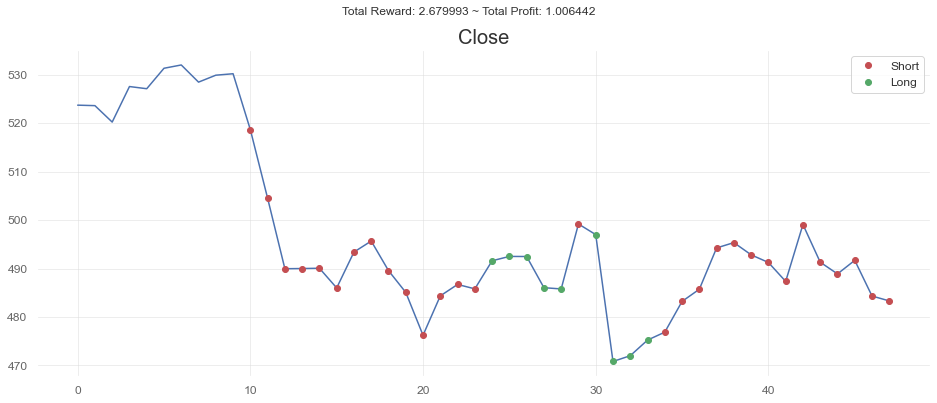

In [39]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


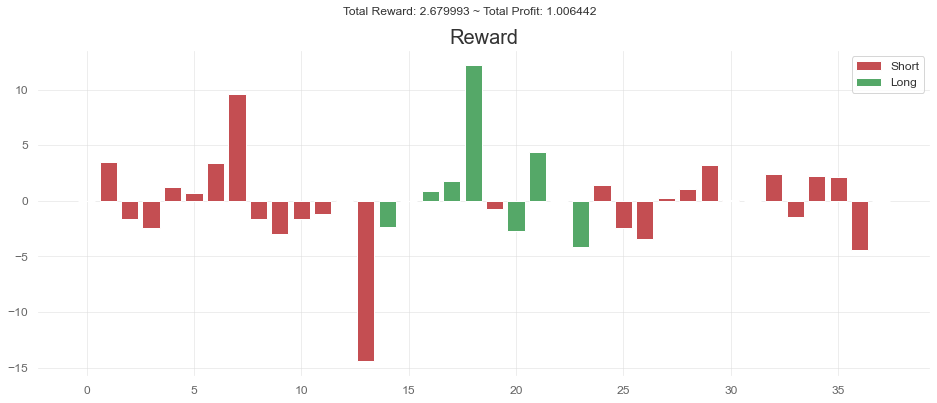

In [40]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


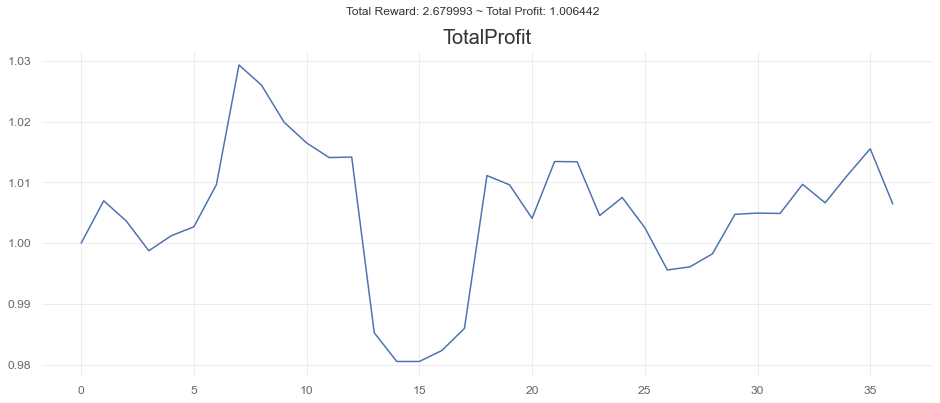

In [41]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [14]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)